# Training on SAE Sparse Features

Loss factor of 0.001, working with the 50 highest activating features per digit

In [1]:
import time

EXPERIMENT_TYPE = "SAE"
RUN_ID = time.time()

## SAE Params

In [2]:
HIDDEN_SIZE = 256
L1_PENALTY = 0.01
loss_factor = 0.001
N = 100

## Imports

In [3]:
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [4]:
from graph_helpers import (plot_weights,
                    plot_activations,
                    plot_losses,
                    plot_saliency_map,
                    plot_sparse_vecs_by_image,
                    plot_top_act_images_by_feature,
                    feature_inversion
                )

In [5]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges, load_intermediate_labels

## Set Device to GPU

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [7]:
# train data
train_images = load_intermediate_labels("first_layer/train_images.pkl")
train_labels = load_intermediate_labels("first_layer/train_labels.pkl")

# val data
val_images = load_intermediate_labels("first_layer/val_images.pkl")
val_labels = load_intermediate_labels("first_layer/val_labels.pkl")

# test data
test_images = load_intermediate_labels("first_layer/test_images.pkl")
test_labels = load_intermediate_labels("first_layer/test_labels.pkl")

# intermediate labels
recon_max_sparse_act_one = load_intermediate_labels(f"first_layer/train_images_recon_max_sparse_top_{N}.pkl")
recon_max_sparse_act_one_ablated = load_intermediate_labels(f"first_layer/train_images_recon_max_sparse_ablated_top_{N}.pkl")

In [8]:
type(recon_max_sparse_act_one[0])

torch.Tensor

In [9]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

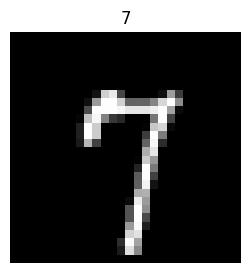

In [10]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Architecture

### NN

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # first hidden layer
        hidden_one_out = self.hidden_one(x)
        hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        hidden_two_out = self.hidden_two(hidden_one_act)
        hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

In [12]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [13]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()
hidden_act_one_loss_fn = nn.MSELoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [14]:
print(f"Model weights (to compare below): {model.hidden_one.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]


### SAE

In [15]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded
    
    def loss(self, x, reconstructed, encoded, l1_lambda=0.001):
        mse_loss = nn.MSELoss()(reconstructed, x)
        l1_loss = l1_lambda * torch.mean(torch.abs(encoded))
        return mse_loss + l1_loss

In [16]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
optimizer_sae_hidden_two = torch.optim.Adam(sae_hidden_two.parameters())

In [17]:
# expectation: SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]
print(f"SAE weights: {sae_hidden_two.encoder.weight[0][:5].detach().cpu().numpy()}")

SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]


In [18]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
optimizer_sae_hidden_one = torch.optim.Adam(sae_hidden_one.parameters())

In [19]:
# expectation: SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]
print(f"SAE weights: {sae_hidden_one.encoder.weight[0][:5].detach().cpu().numpy()}")

SAE weights: [ 0.19113463  0.20750198 -0.05856812  0.22965282 -0.05477589]


### Verify Reproducibility

In [20]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.hidden_one.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.hidden_one.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [21]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, first_layer_acts=None):
        self.images = images
        self.labels = labels
        self.first_layer_acts = first_layer_acts

    def __len__(self):
        assert len(self.images) == len(self.labels)
        if self.first_layer_acts:
            assert(len(self.first_layer_acts) == len(self.images))
            
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx].copy()).float()
        label = torch.tensor(self.labels[idx].copy(), dtype=torch.long)

        if self.first_layer_acts:
            return (image, label, self.first_layer_acts[idx])
        else:
            return (image, label)

In [22]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [23]:
NUM_WORKERS = 4
if device.type.lower() == "cpu":
    NUM_WORKERS = 0

# training data
train_dataset = EdgeDataset(train_images, train_labels, recon_max_sparse_act_one)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)

## Training Loop

Epoch 1/20 [Train]:   0%|                                                                       | 0/782 [00:00<?, ?it/s]/home/alex/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 16])) that is different to the input size (torch.Size([64, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/20 [Train]:  98%|███████████████████████████████████████████████▉ | 766/782 [00:03<00:00, 218.59it/s, loss=19.1]/home/alex/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1, 16])) that is different to the input size (torch.Size([16, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20
  Train Loss: 19.3707
  SAE Train Loss (hidden one): 75.4934
  SAE Train Loss (hidden two): 5.5183
  Val Loss: 0.7110 | Val Acc: 77.46%
  Saved model with Val Acc: 77.46%


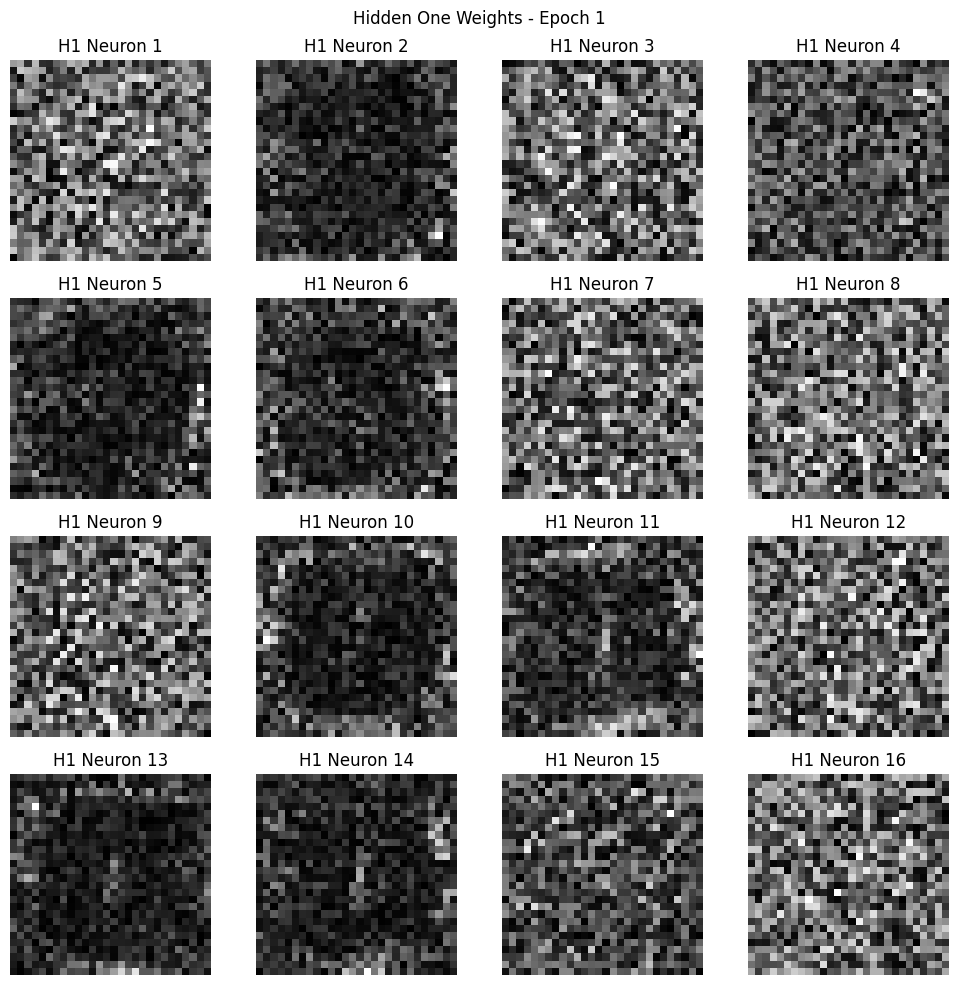

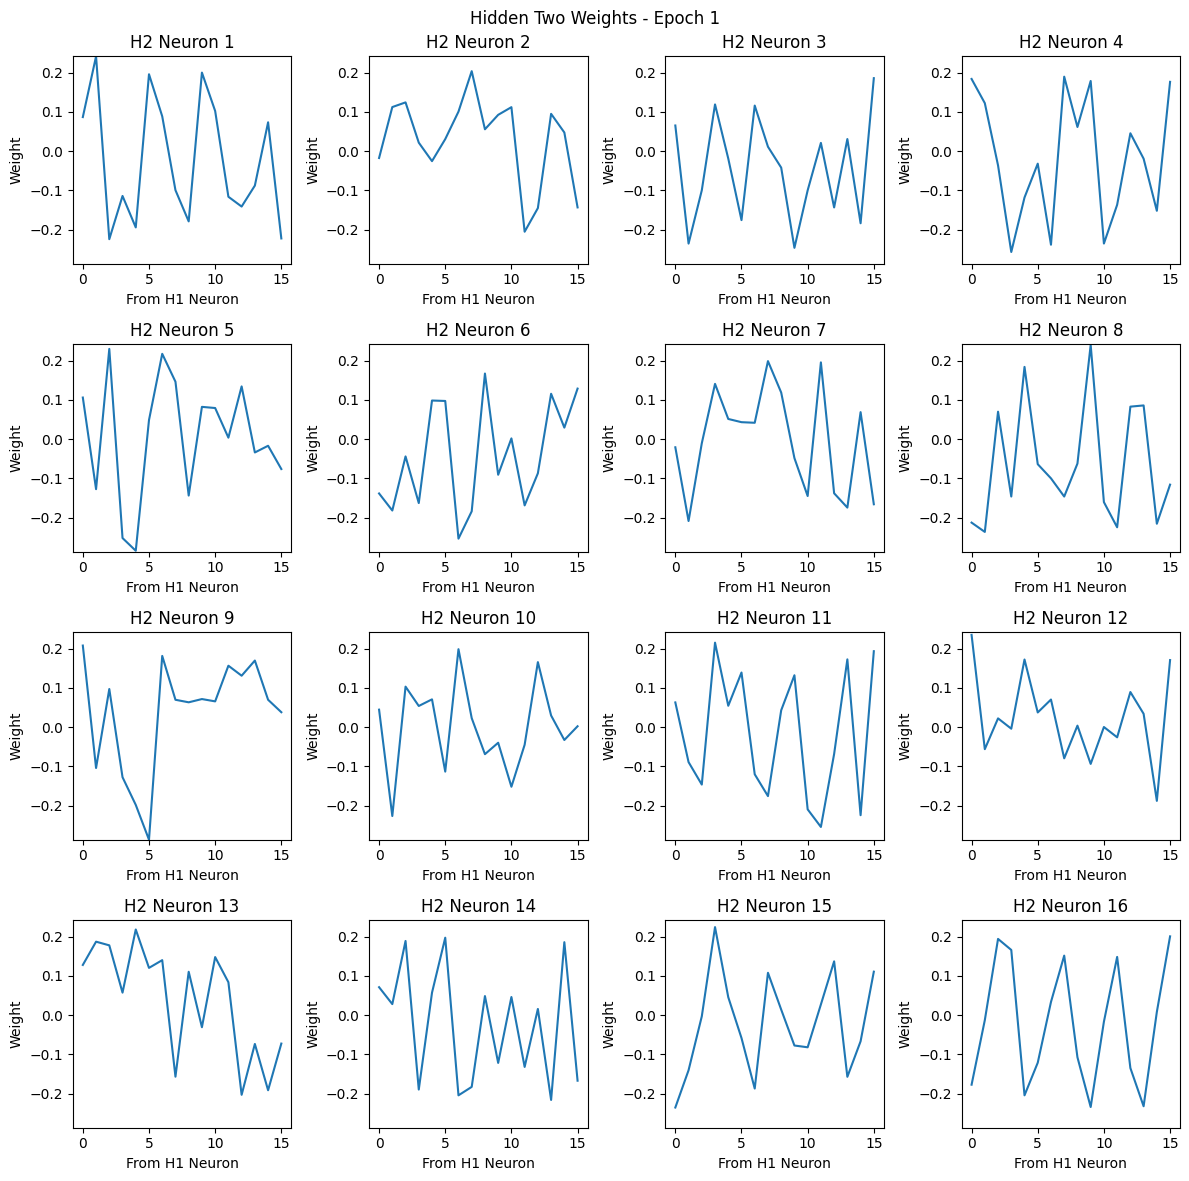

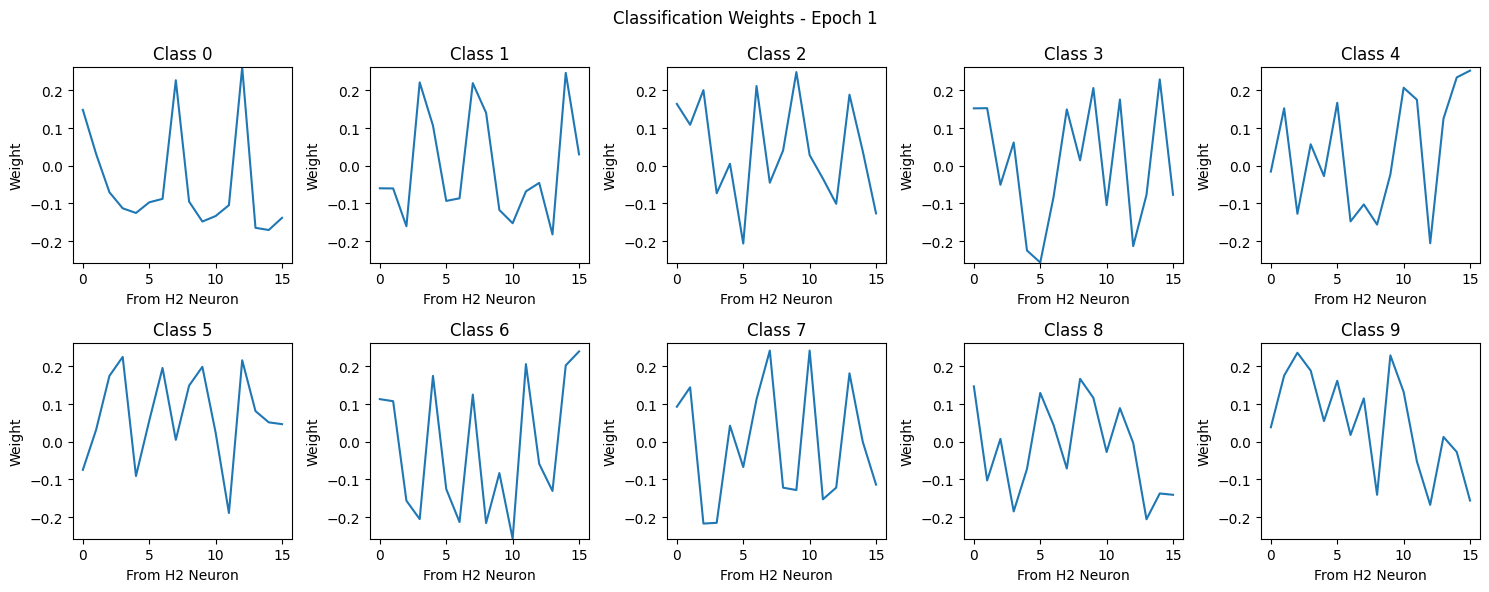

Epoch 2/20
  Train Loss: 18.5918
  SAE Train Loss (hidden one): 0.5629
  SAE Train Loss (hidden two): 0.1670
  Val Loss: 0.5213 | Val Acc: 84.86%
  Saved model with Val Acc: 84.86%


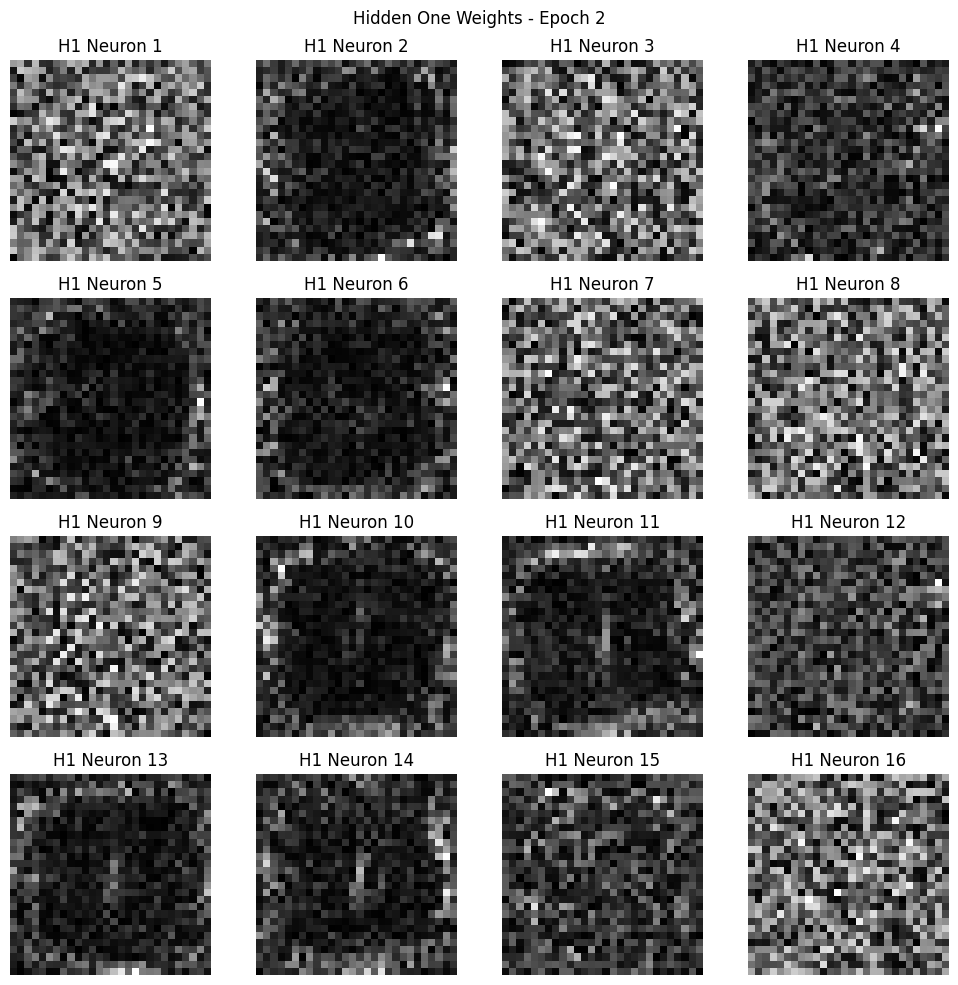

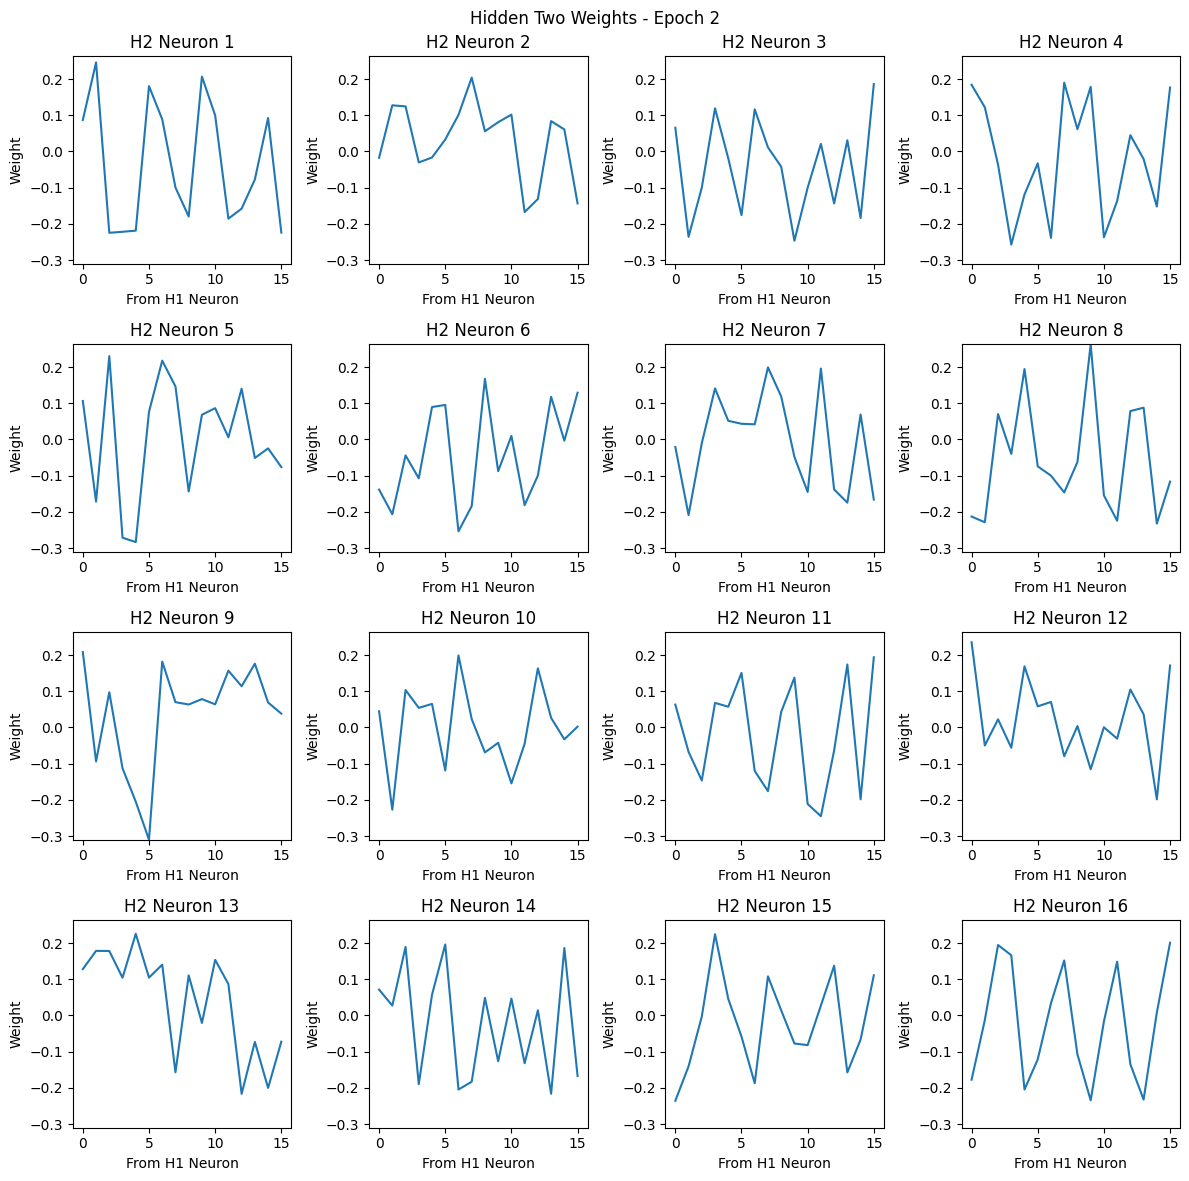

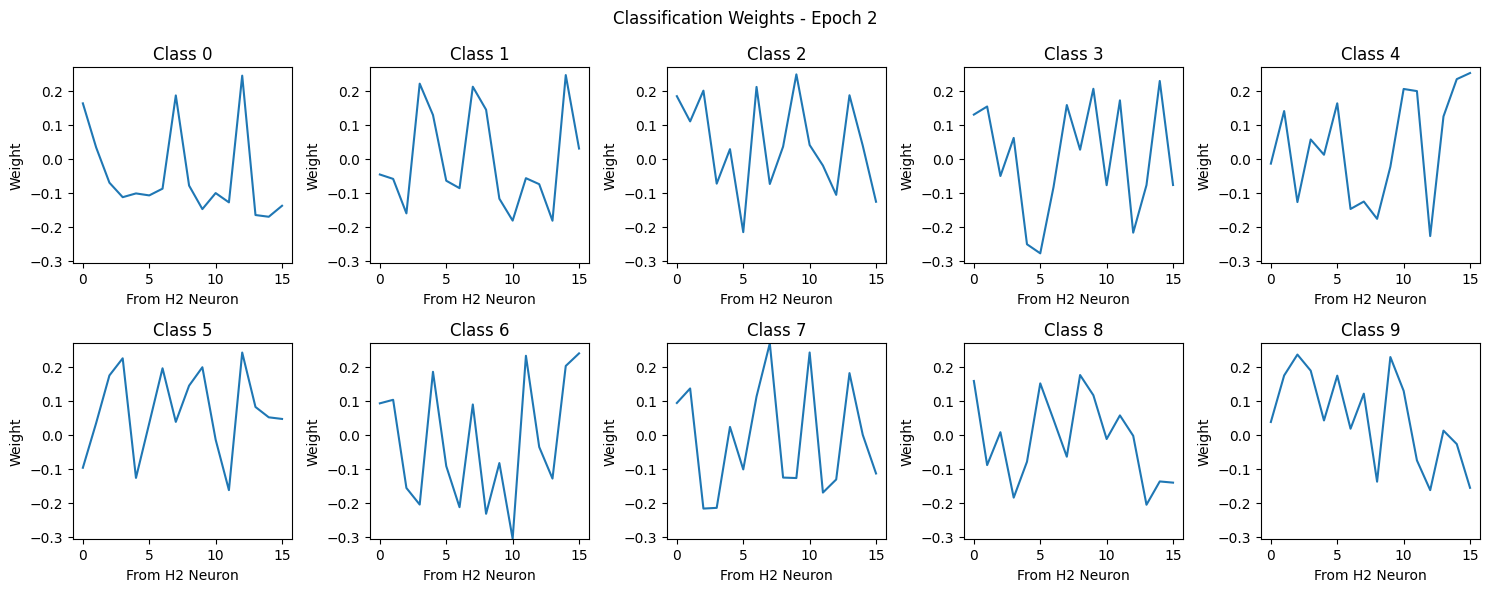

Epoch 3/20
  Train Loss: 18.5345
  SAE Train Loss (hidden one): 0.4299
  SAE Train Loss (hidden two): 0.1221
  Val Loss: 0.7388 | Val Acc: 77.49%


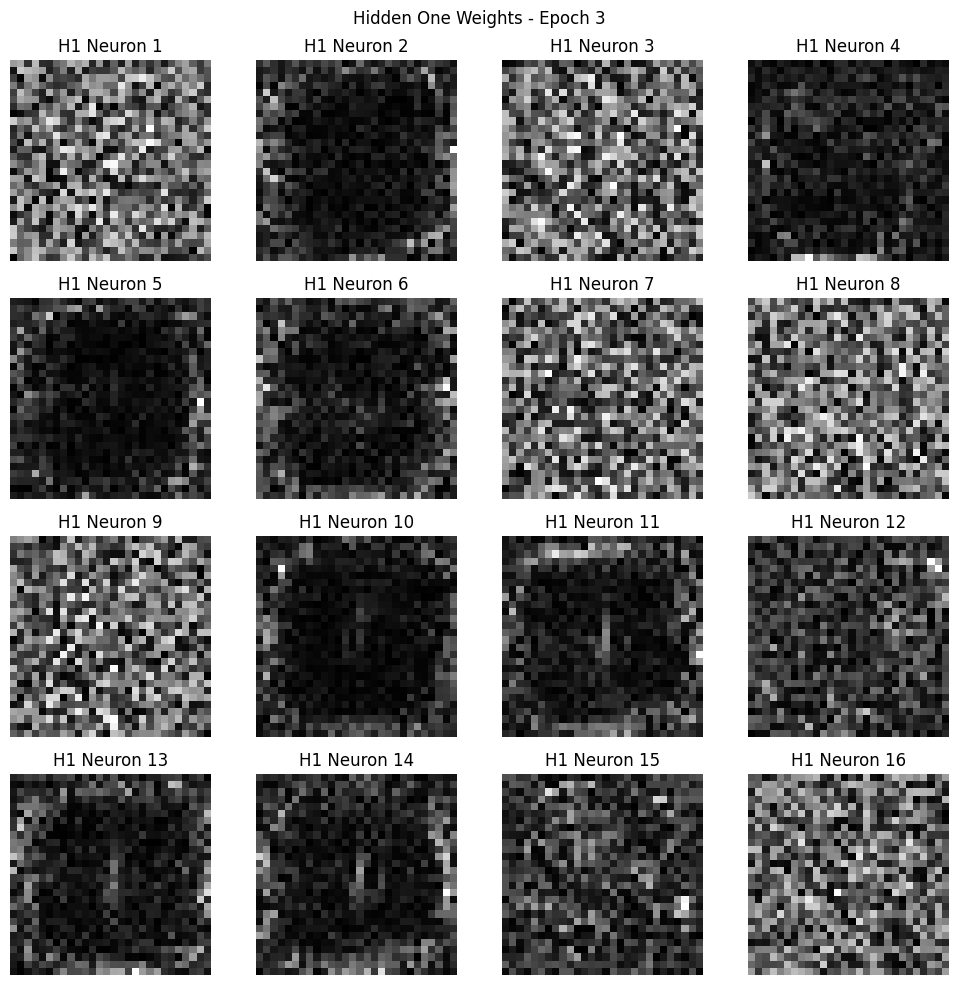

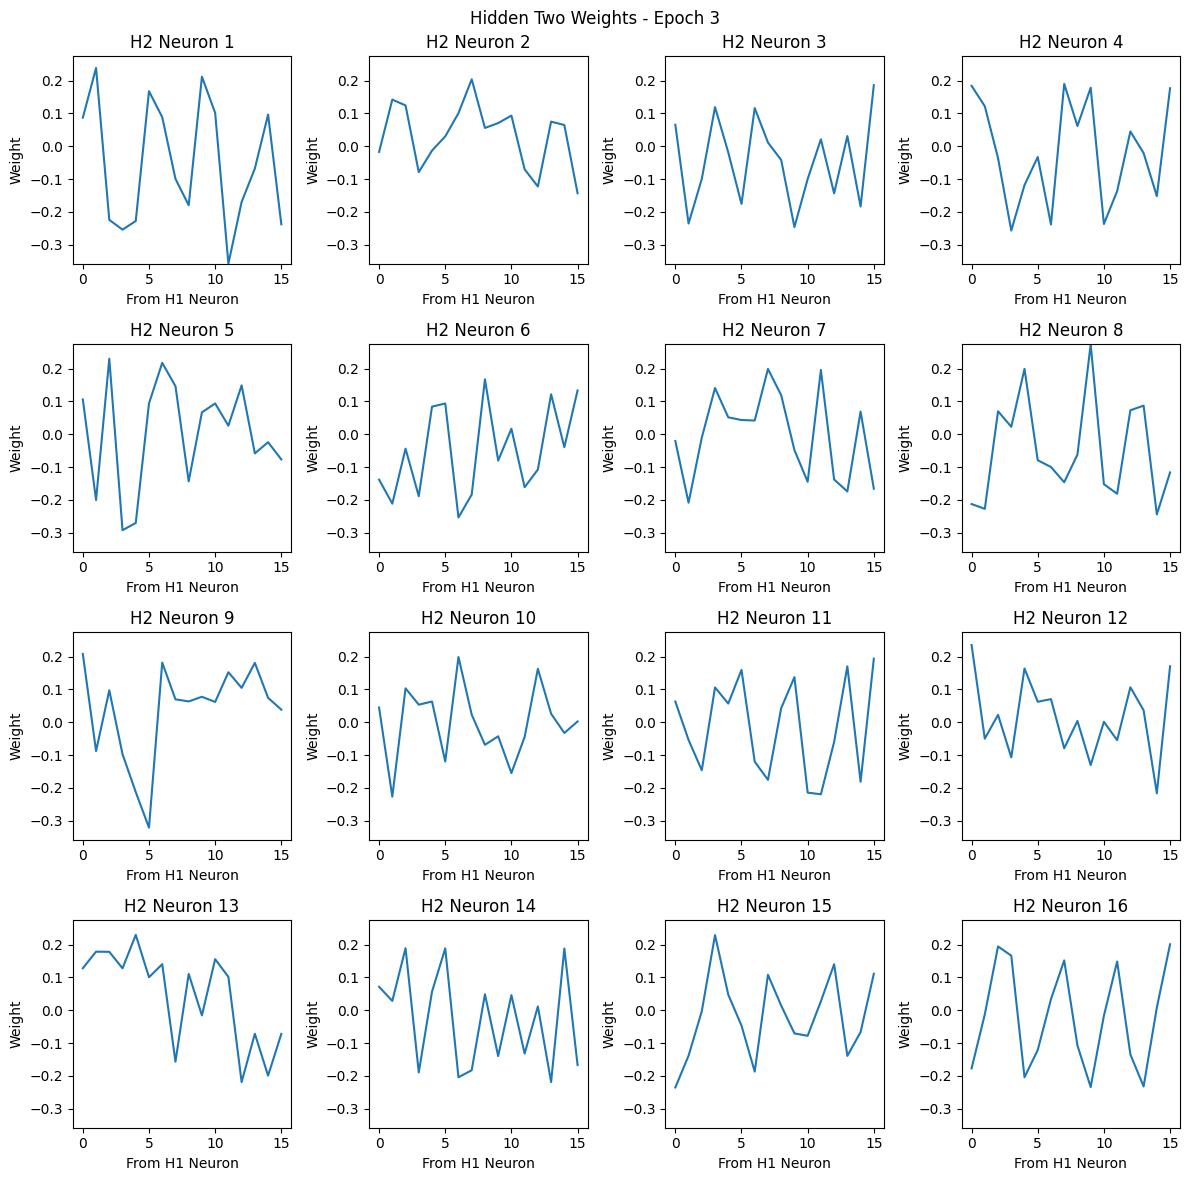

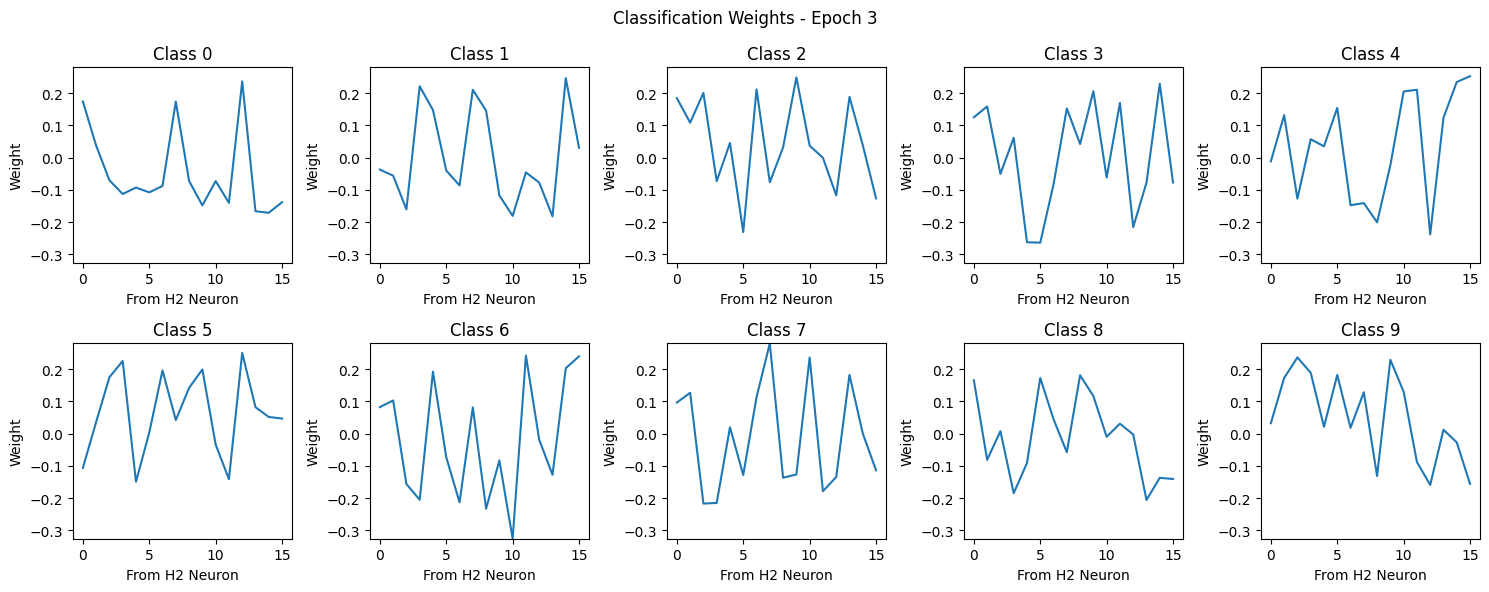

Epoch 4/20
  Train Loss: 18.4786
  SAE Train Loss (hidden one): 0.3835
  SAE Train Loss (hidden two): 0.1136
  Val Loss: 0.6880 | Val Acc: 78.77%


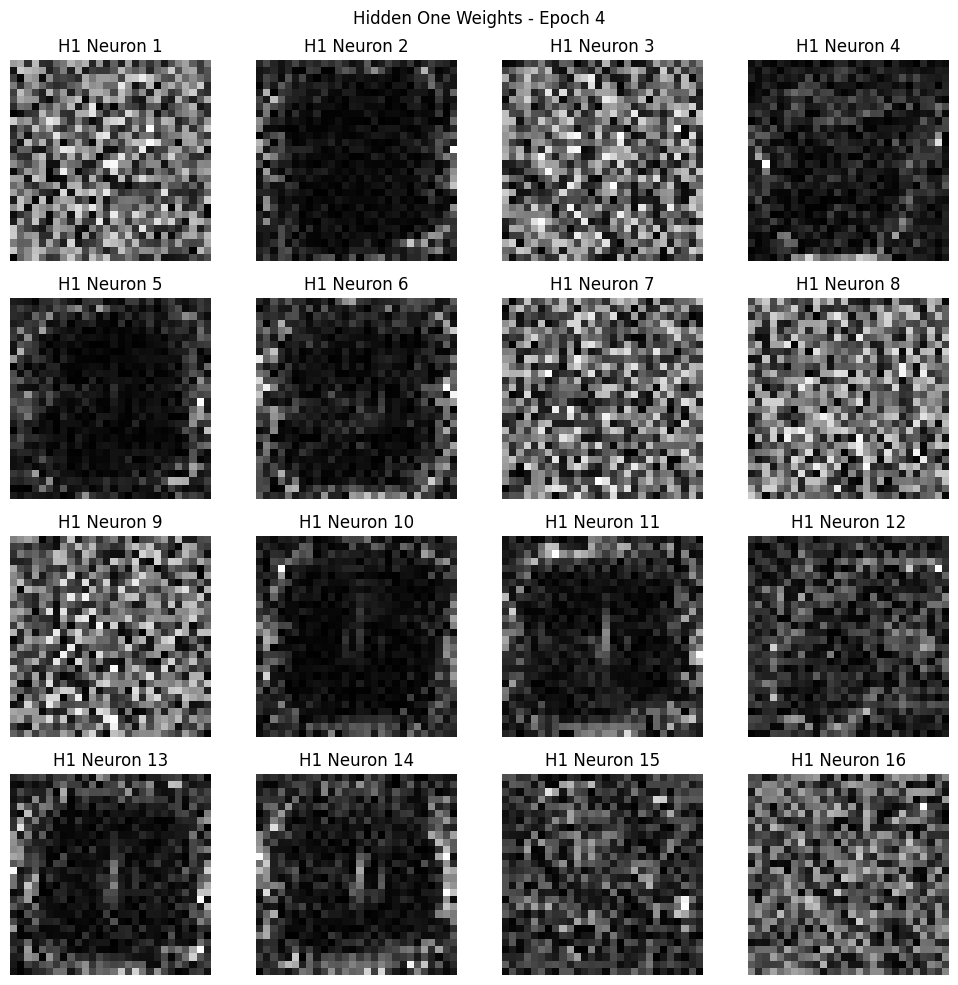

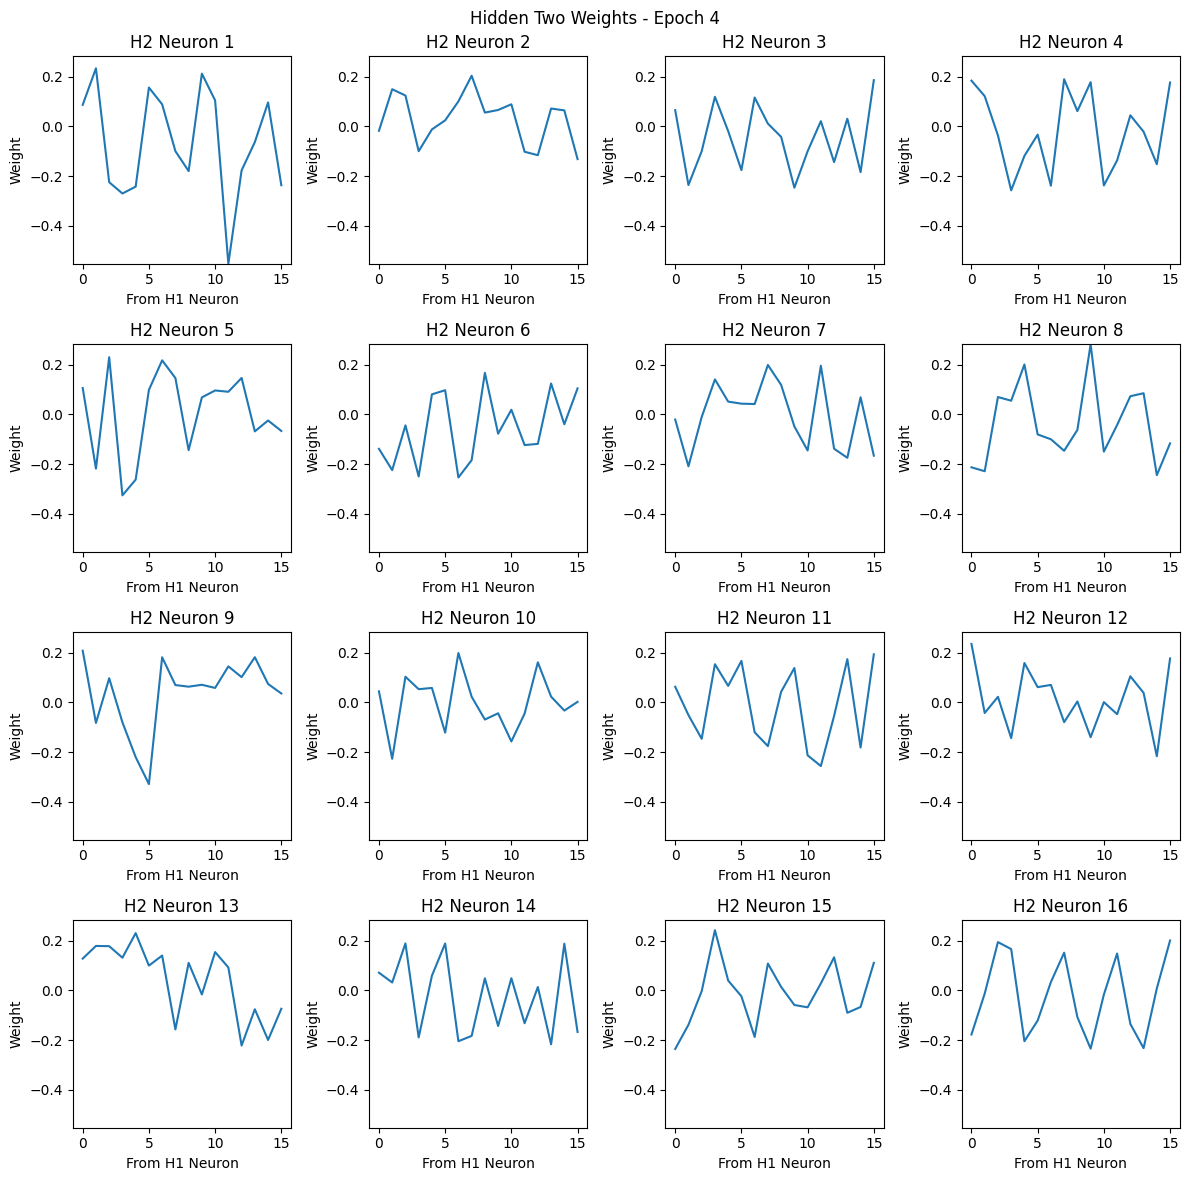

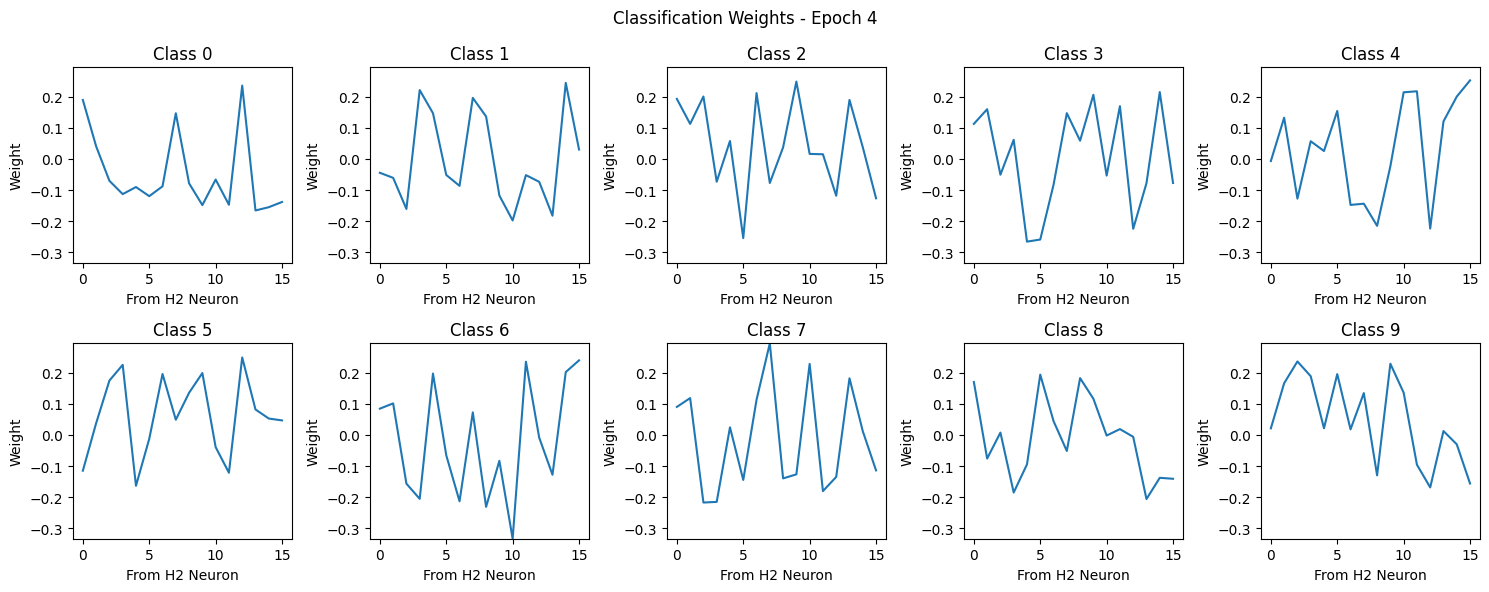

Epoch 5/20
  Train Loss: 18.4954
  SAE Train Loss (hidden one): 0.3795
  SAE Train Loss (hidden two): 0.0986
  Val Loss: 0.5516 | Val Acc: 82.88%


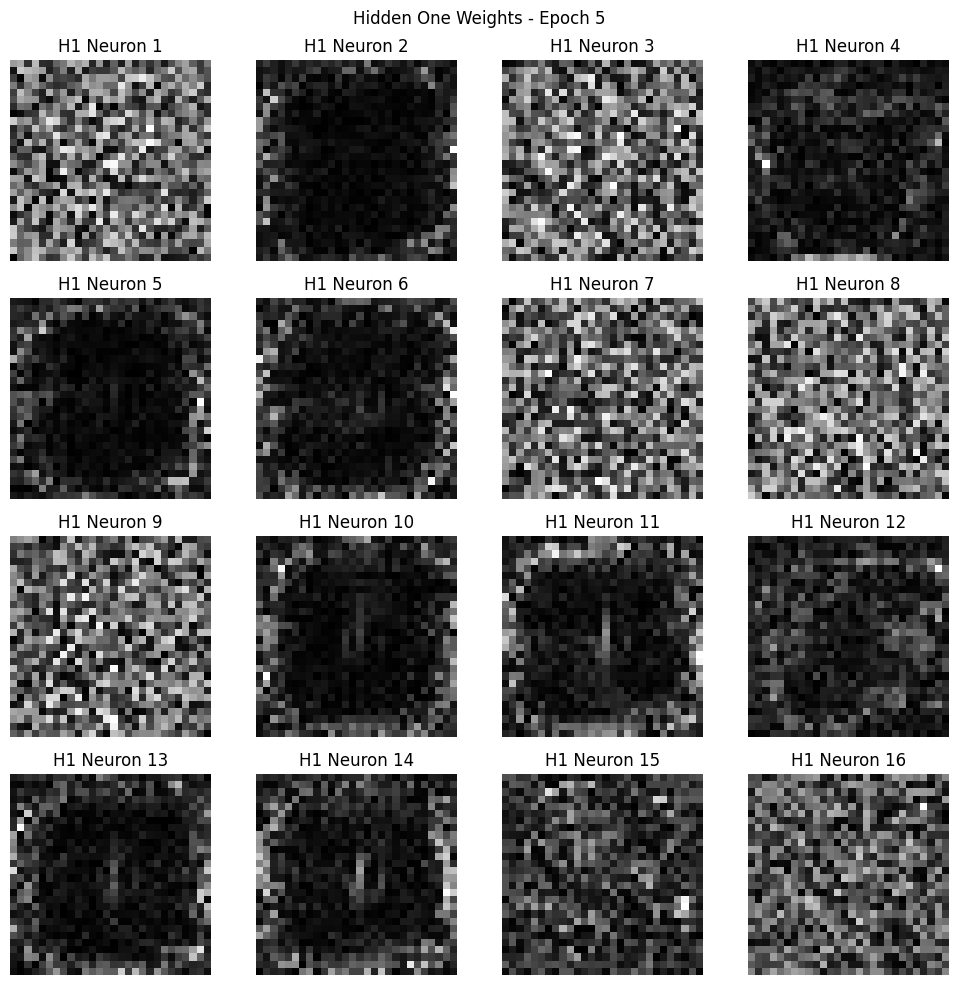

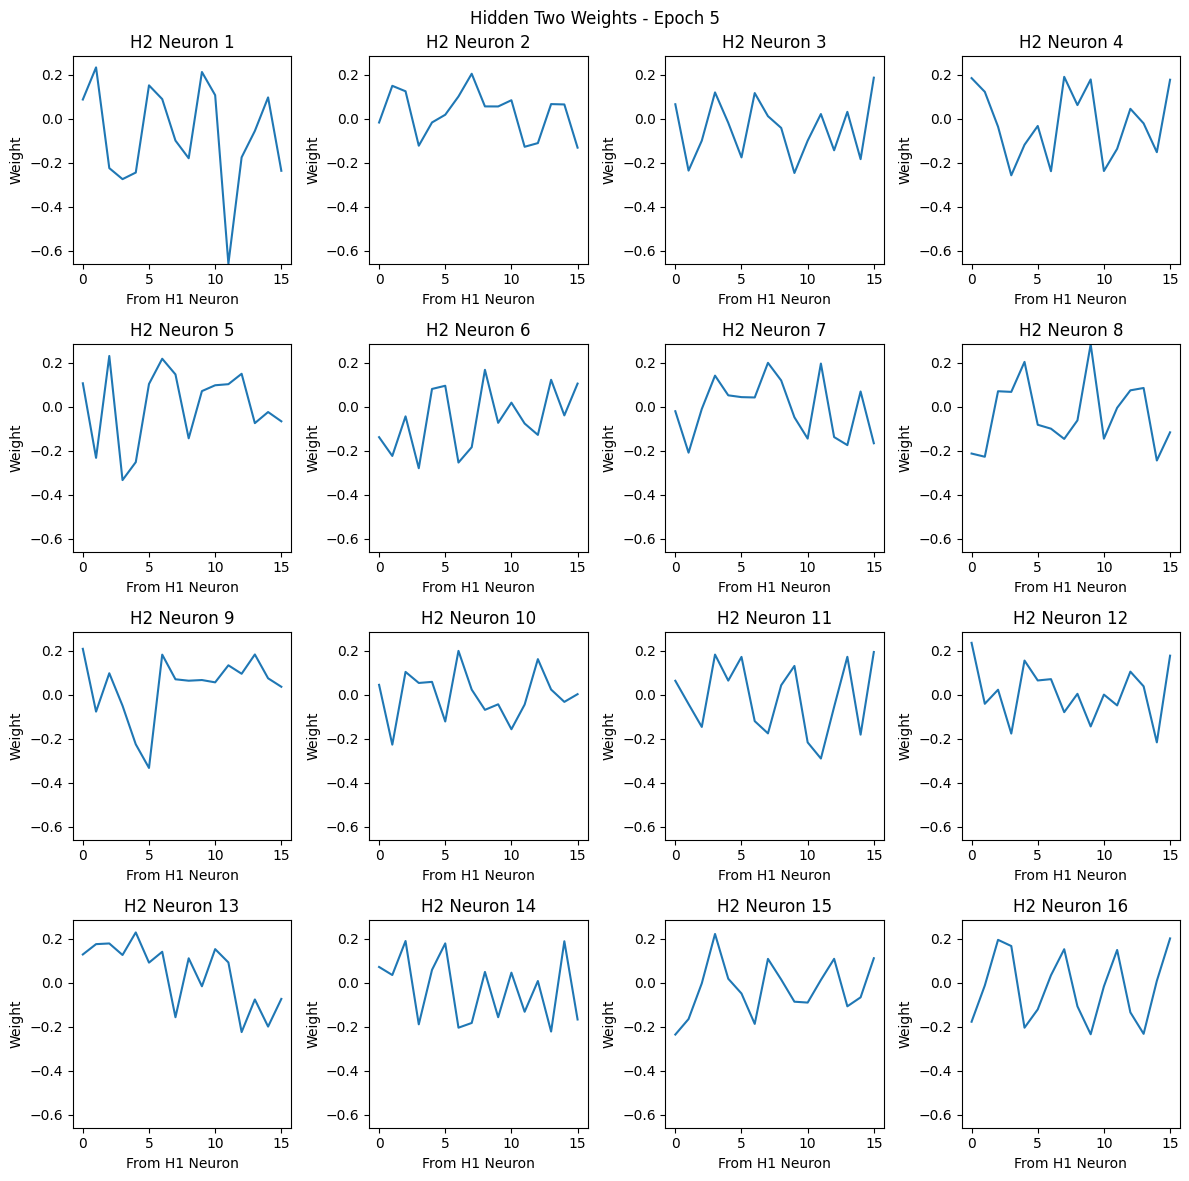

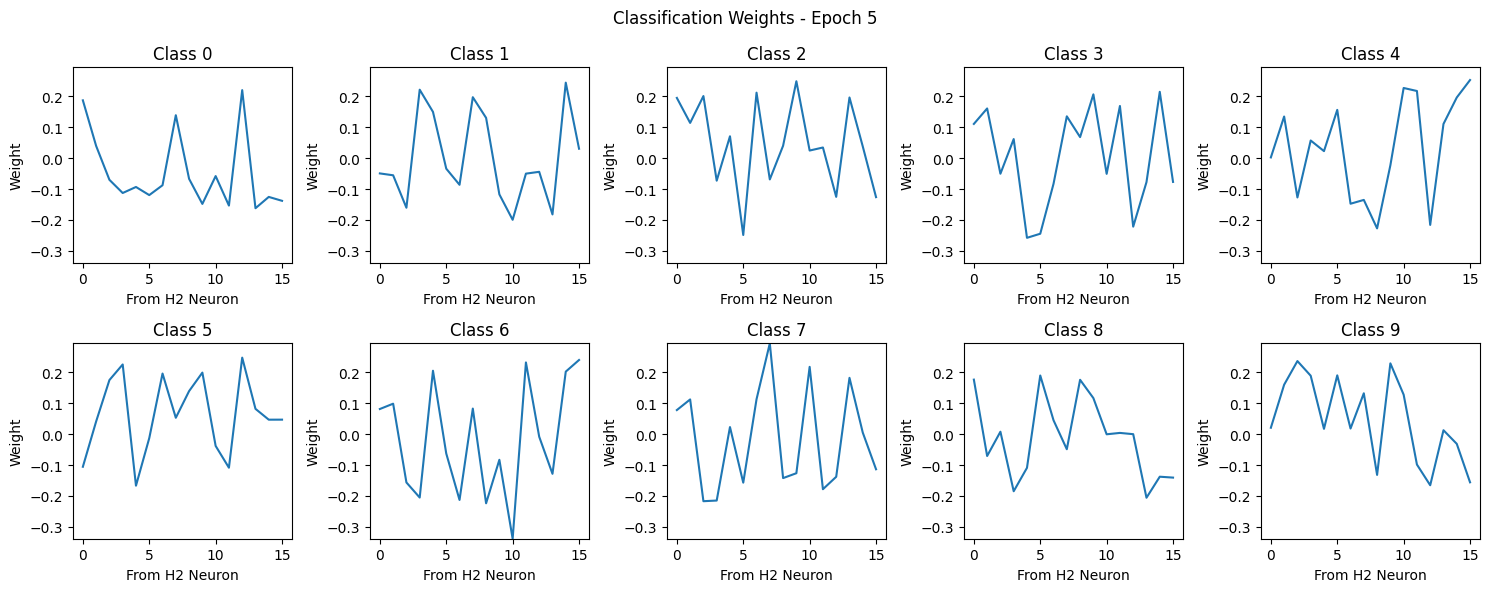

Epoch 6/20
  Train Loss: 18.4684
  SAE Train Loss (hidden one): 0.3942
  SAE Train Loss (hidden two): 0.0874
  Val Loss: 0.4760 | Val Acc: 85.80%
  Saved model with Val Acc: 85.80%


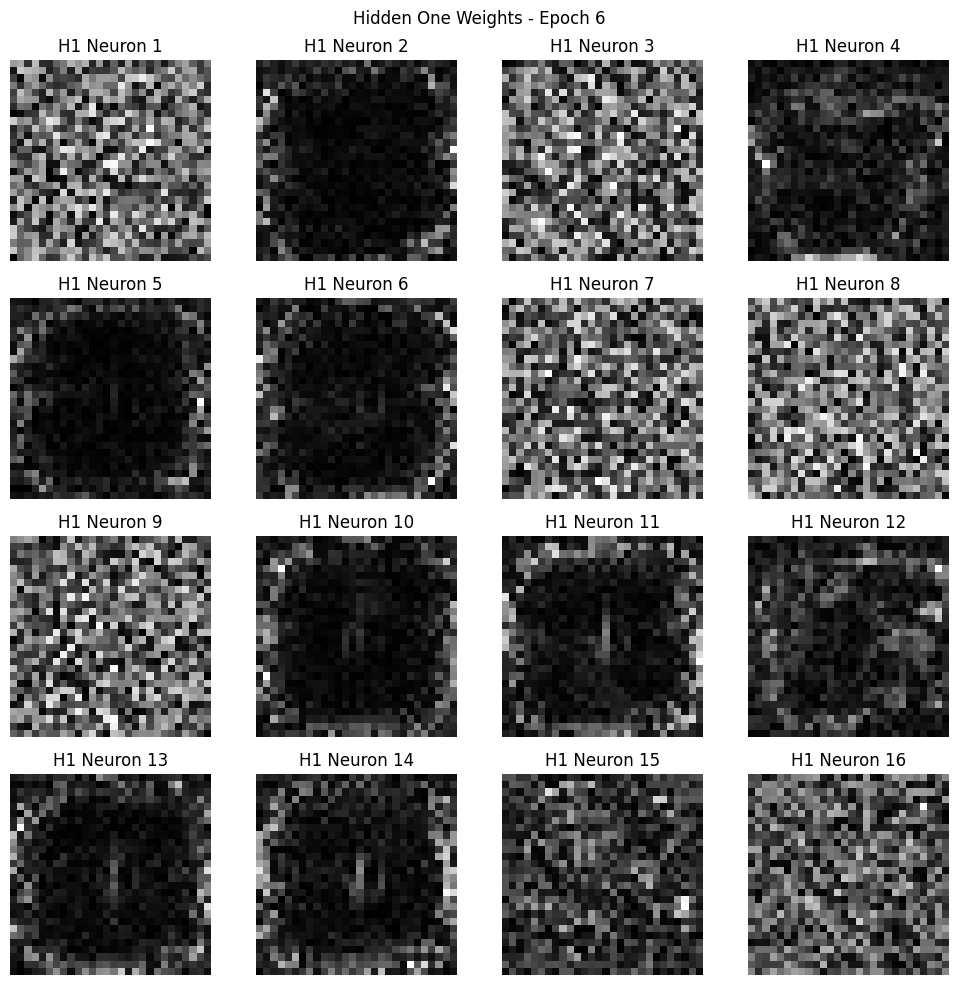

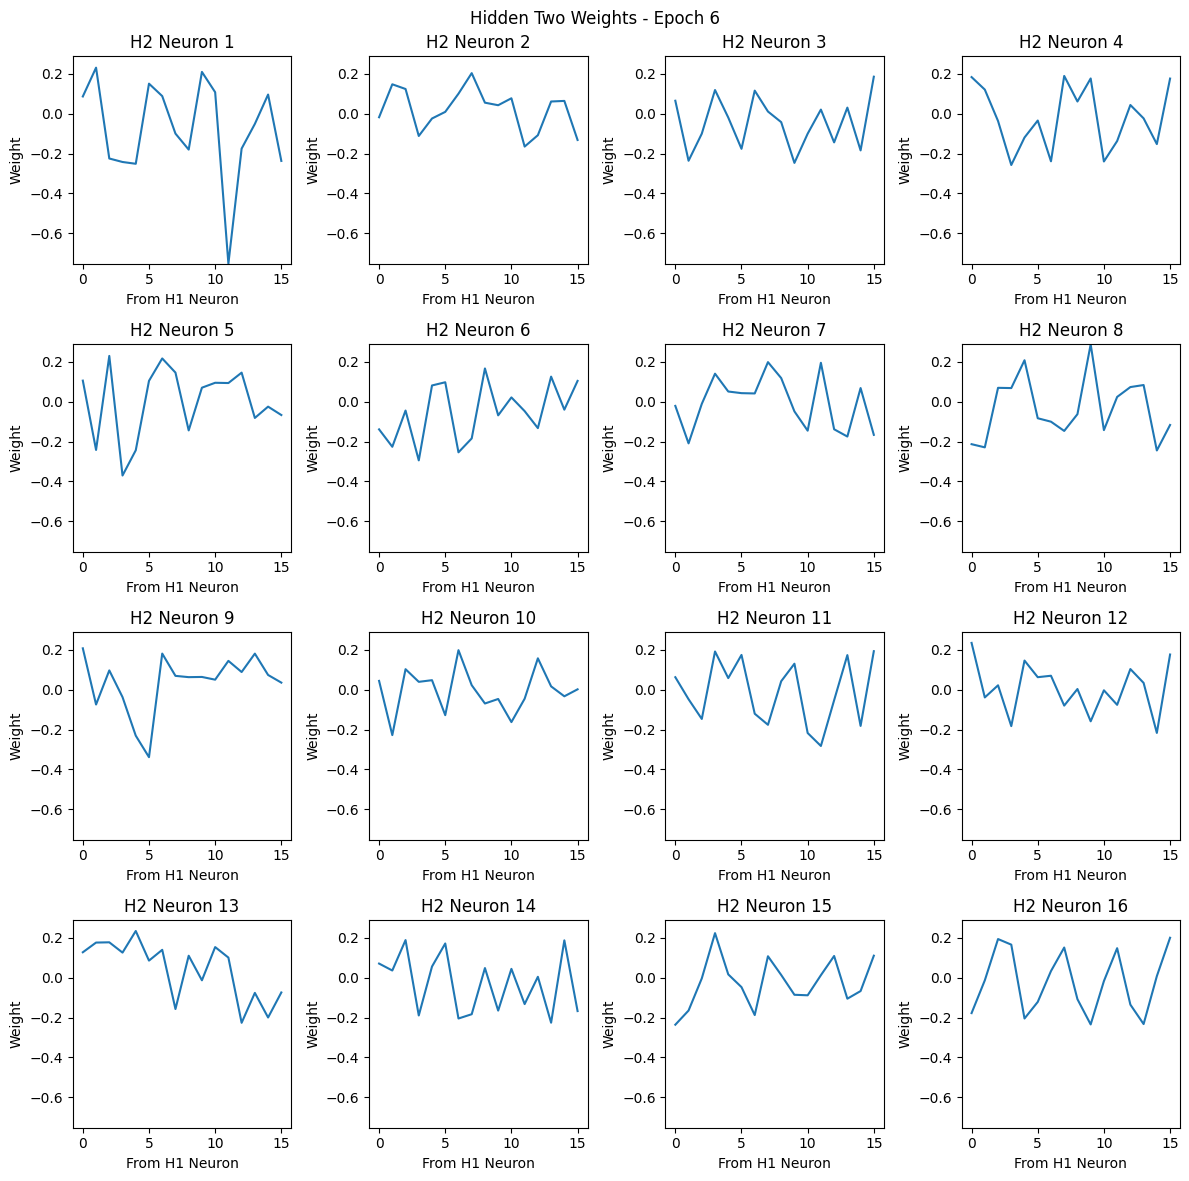

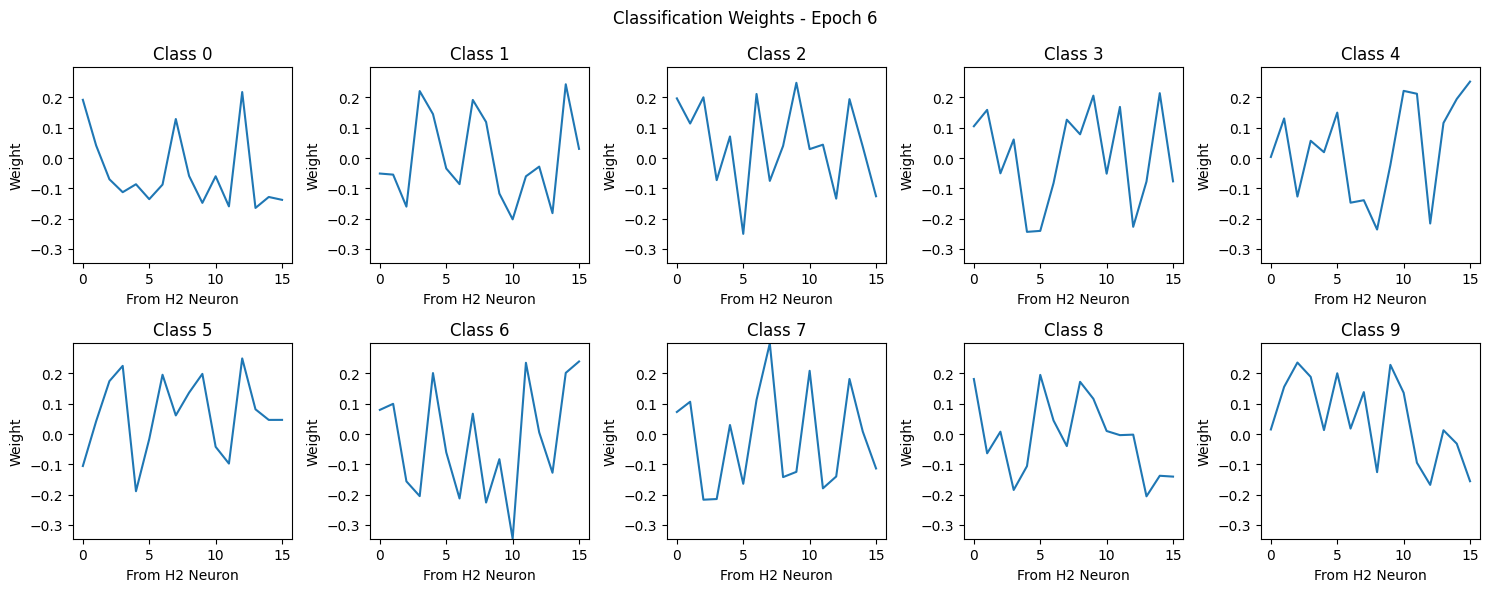

Epoch 7/20
  Train Loss: 18.4791
  SAE Train Loss (hidden one): 0.3563
  SAE Train Loss (hidden two): 0.0793
  Val Loss: 0.5078 | Val Acc: 84.90%


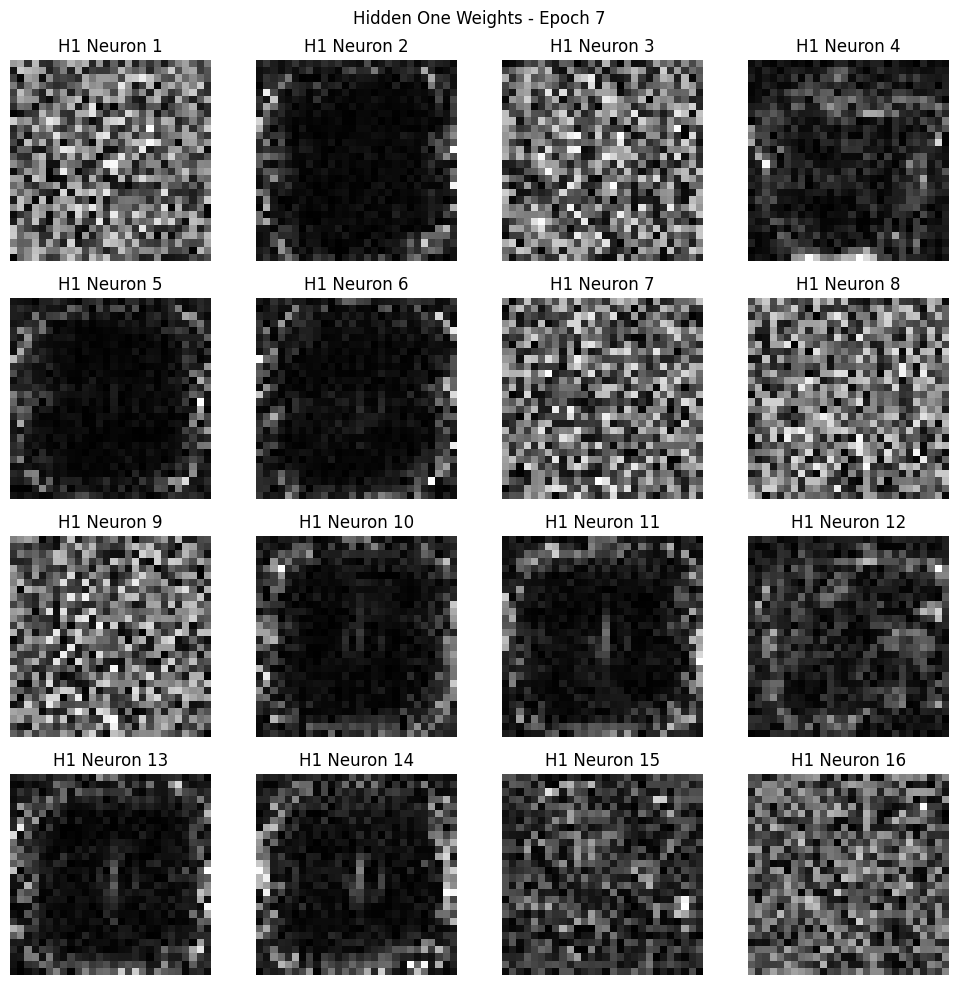

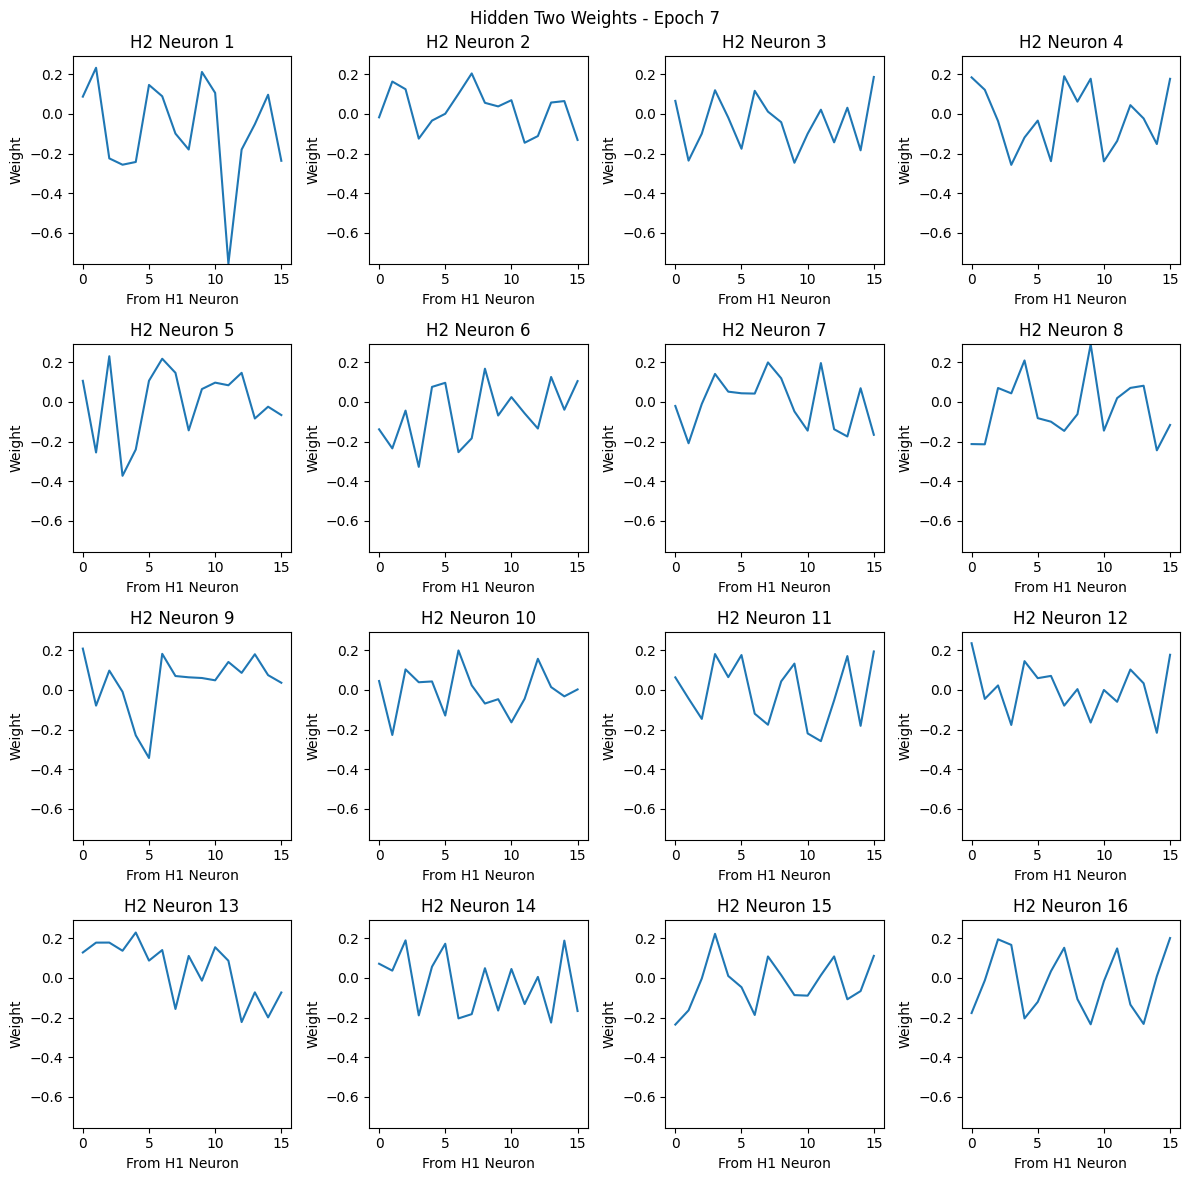

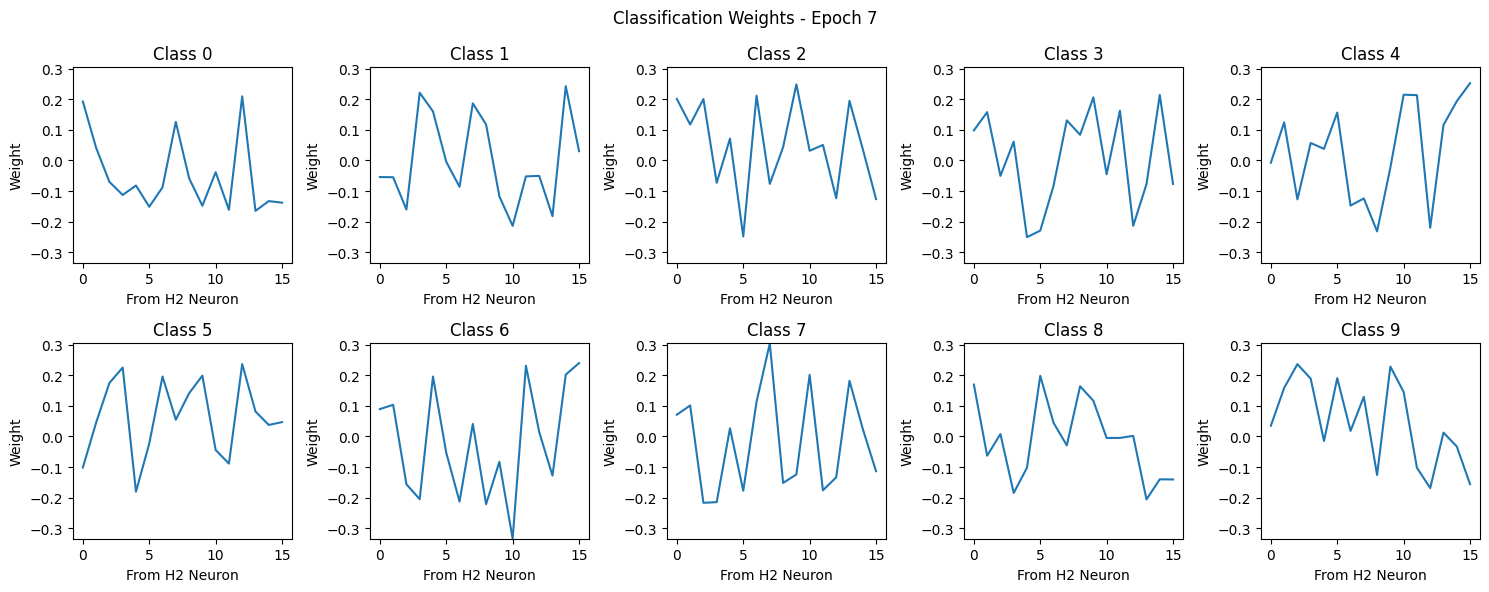

Epoch 8/20
  Train Loss: 18.4591
  SAE Train Loss (hidden one): 0.3666
  SAE Train Loss (hidden two): 0.0827
  Val Loss: 0.4867 | Val Acc: 85.13%


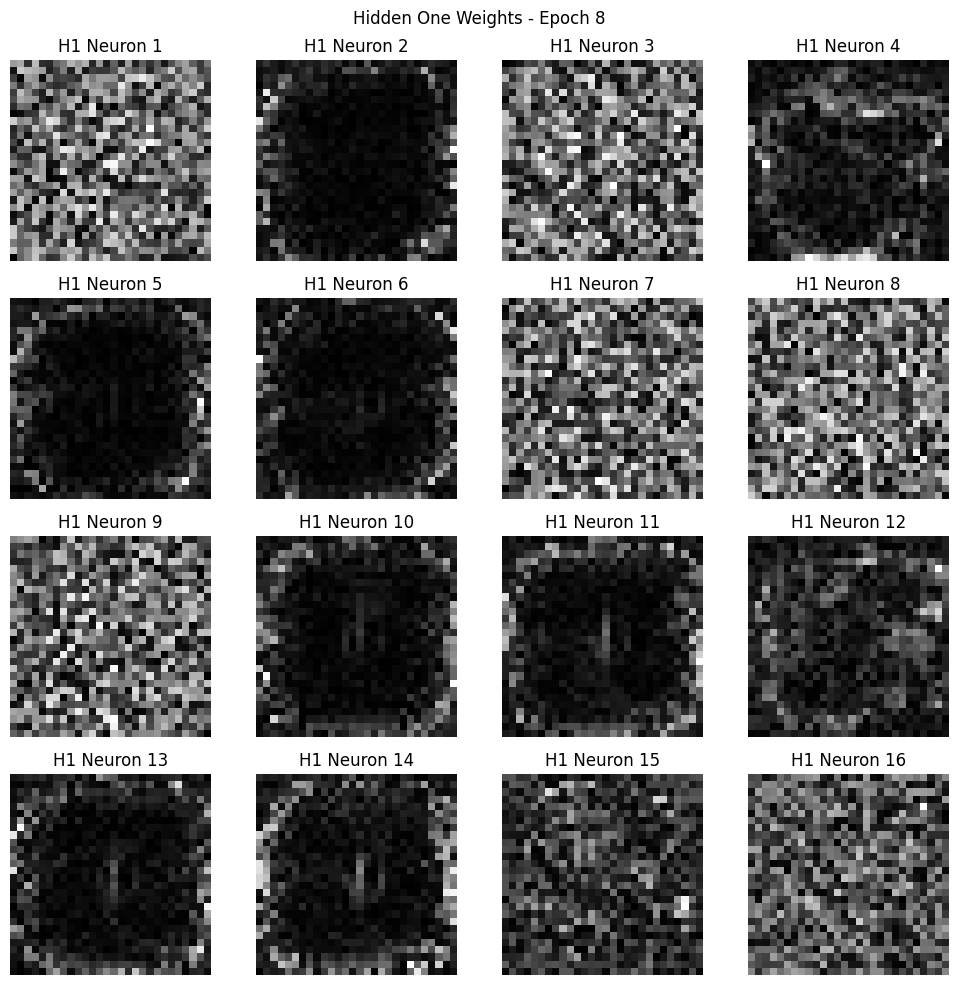

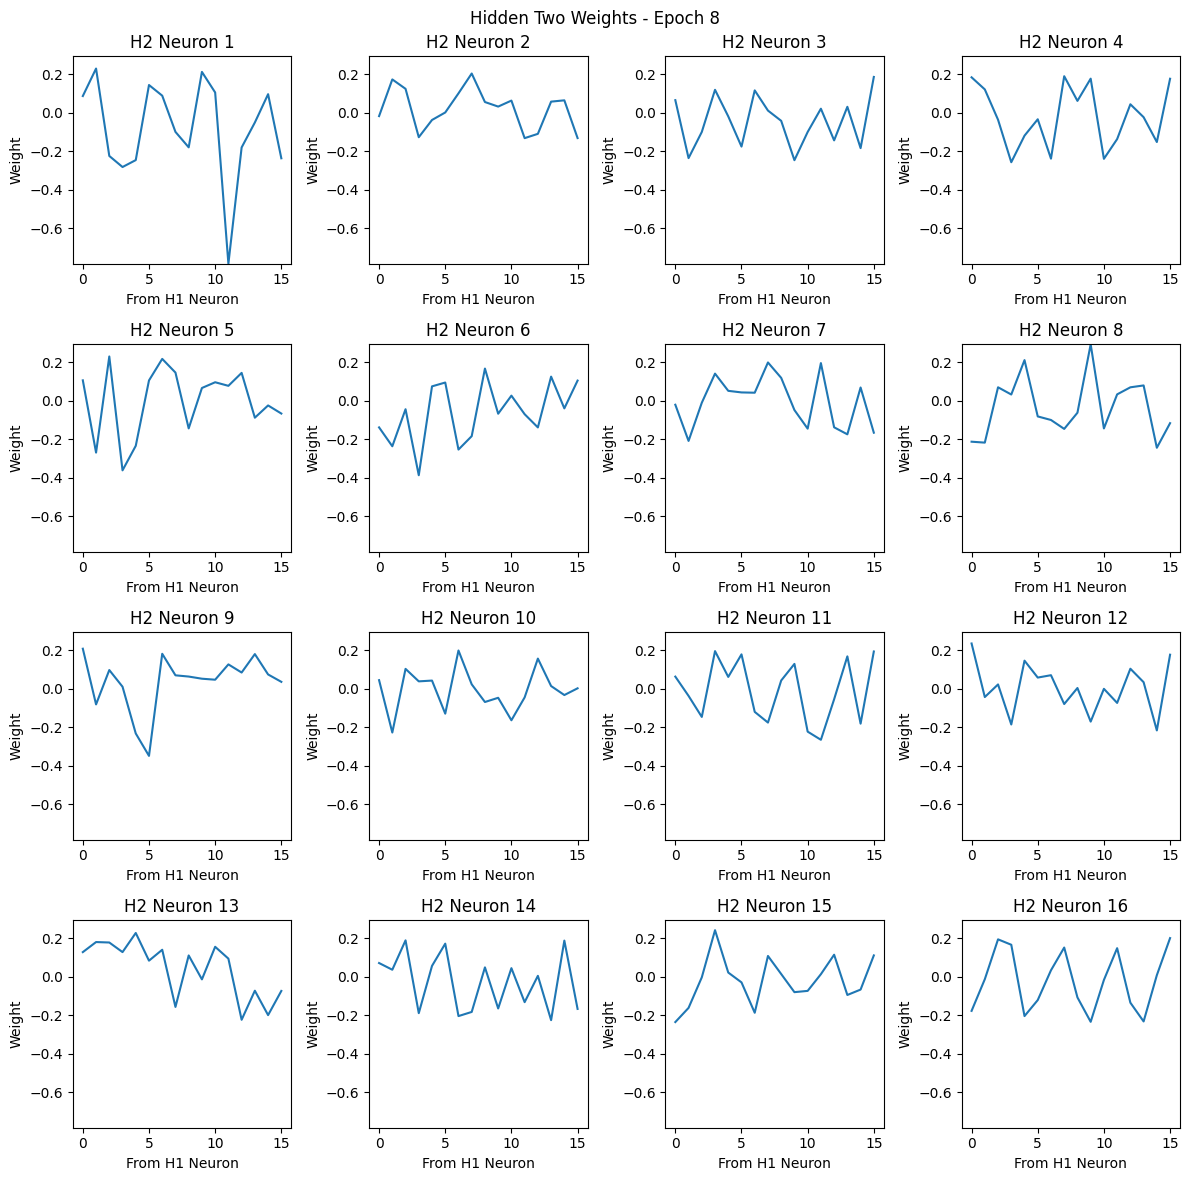

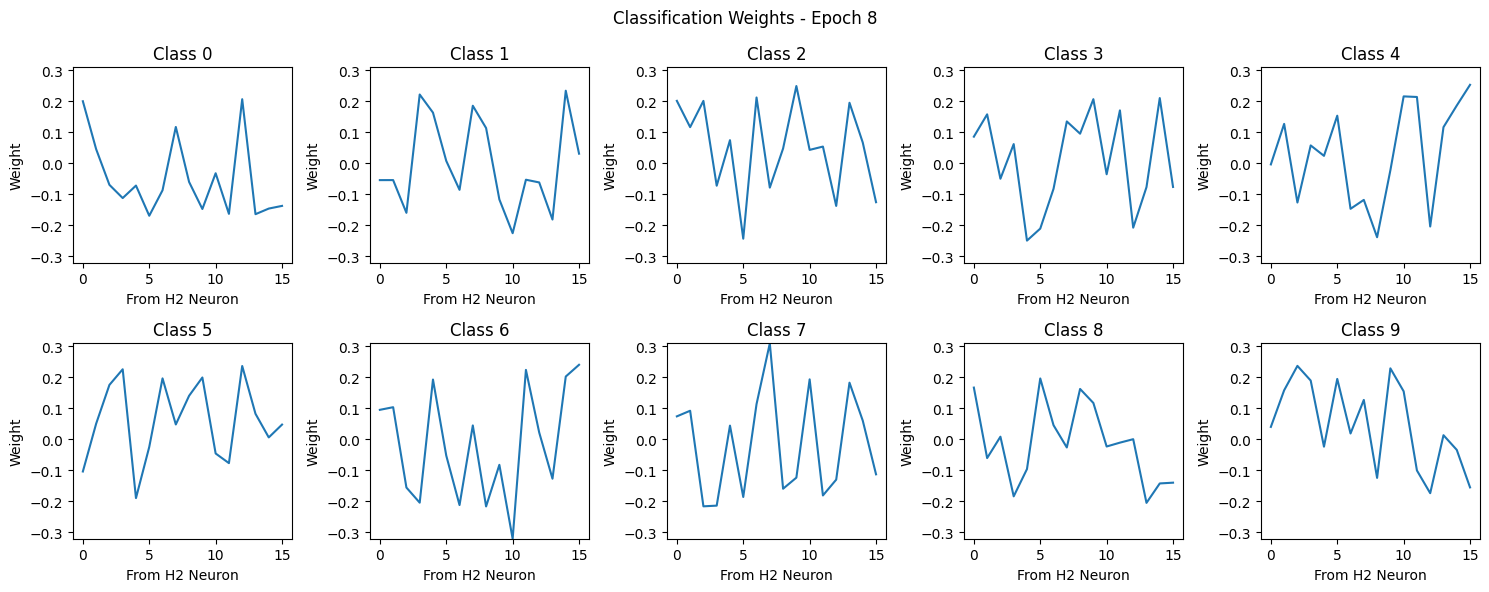

Epoch 9/20
  Train Loss: 18.4575
  SAE Train Loss (hidden one): 0.3502
  SAE Train Loss (hidden two): 0.0613
  Val Loss: 0.5014 | Val Acc: 85.05%


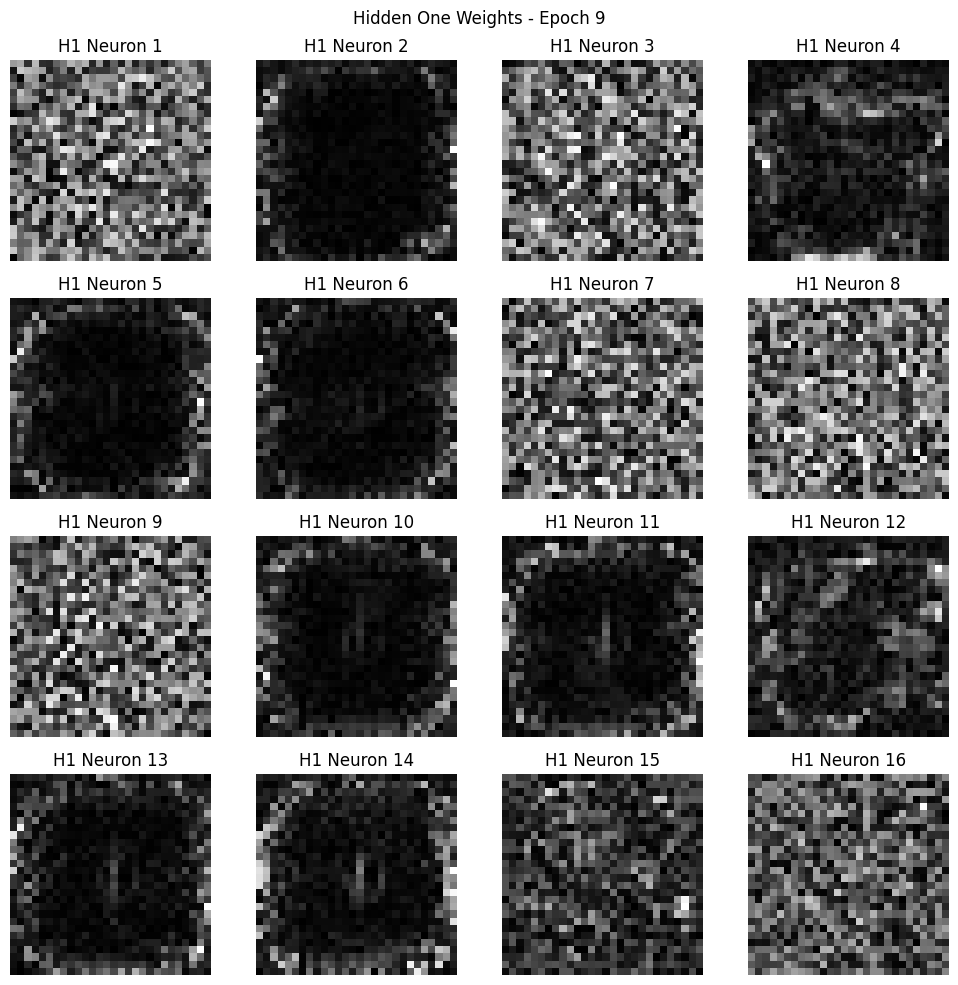

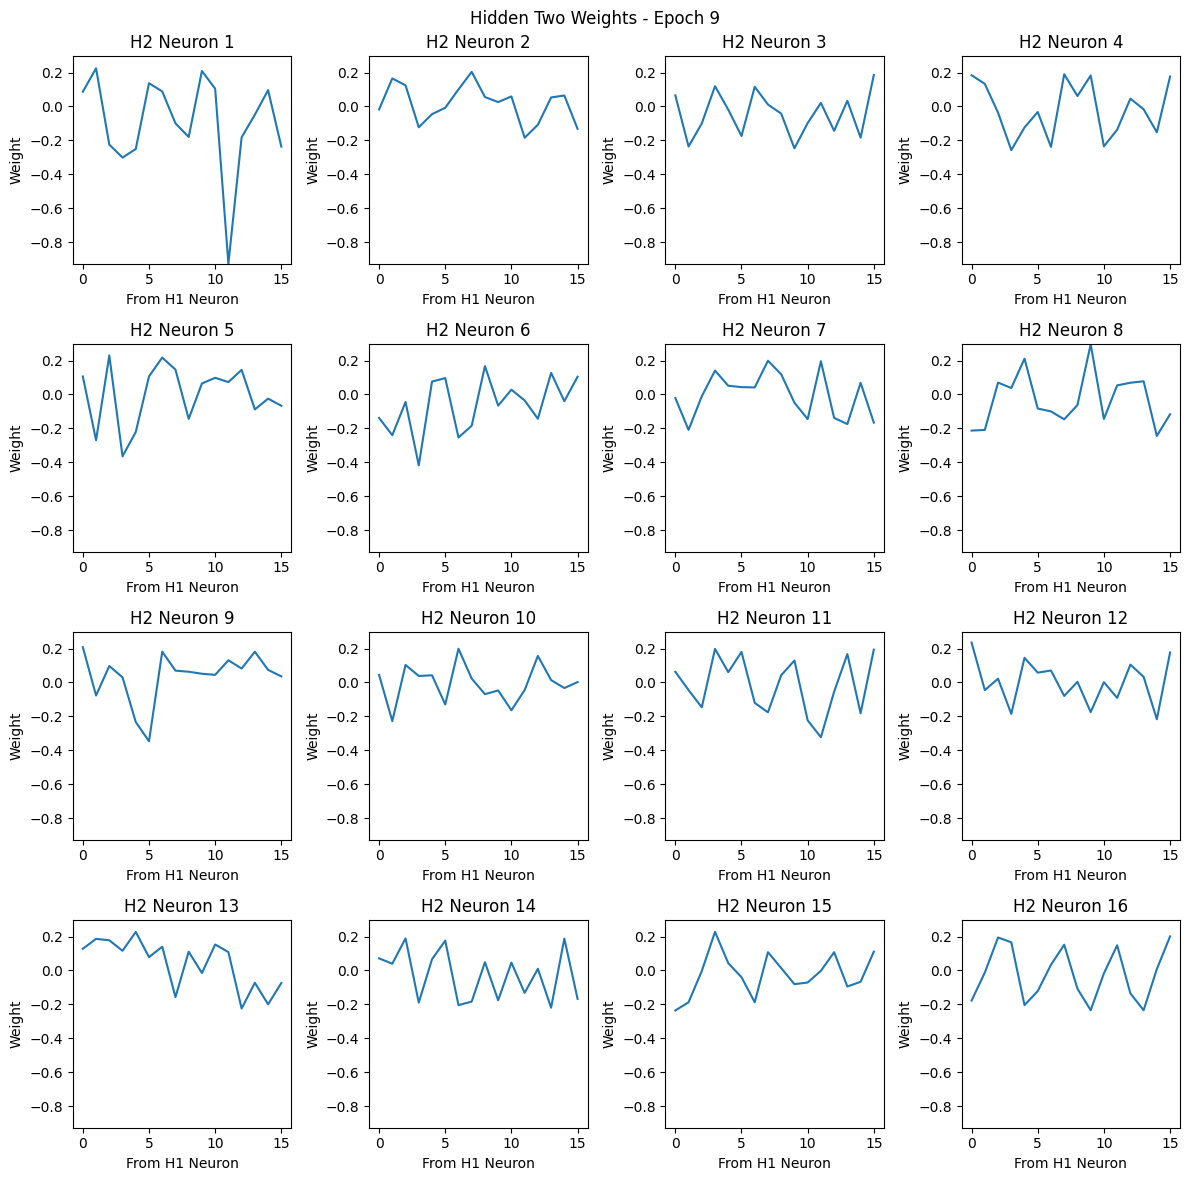

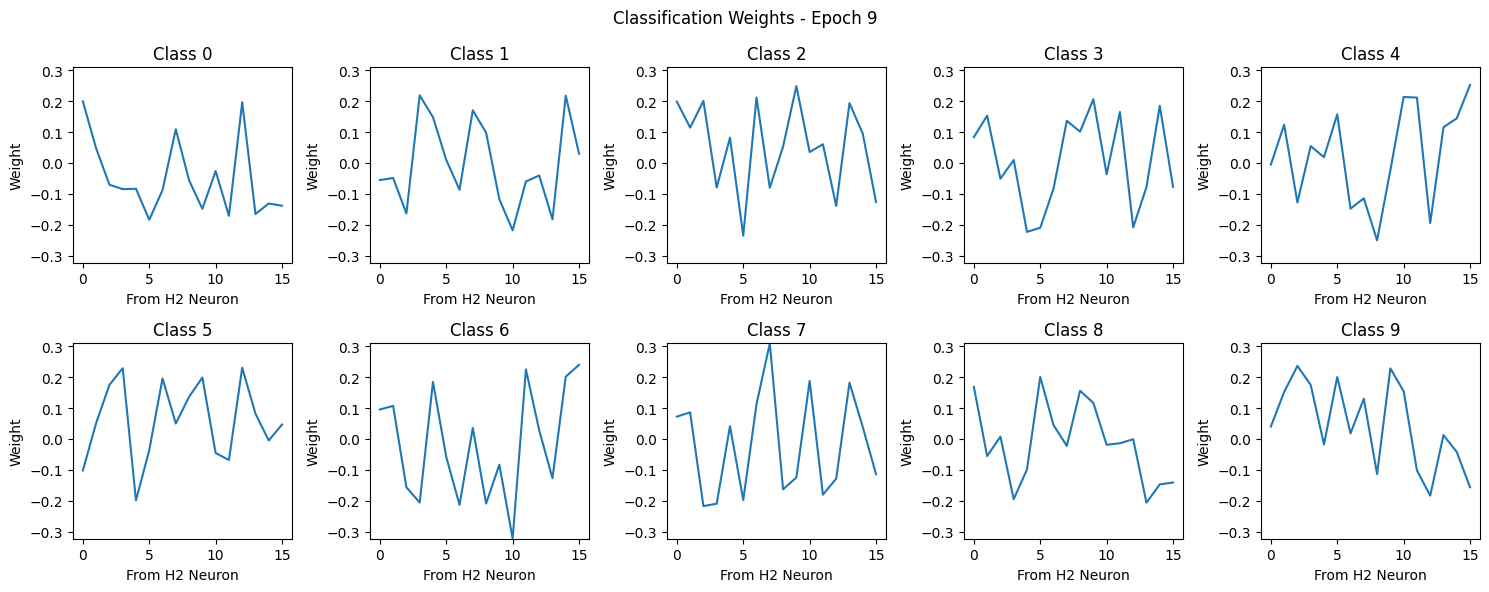

Epoch 10/20
  Train Loss: 18.4431
  SAE Train Loss (hidden one): 0.3335
  SAE Train Loss (hidden two): 0.0406
  Val Loss: 0.6601 | Val Acc: 79.32%


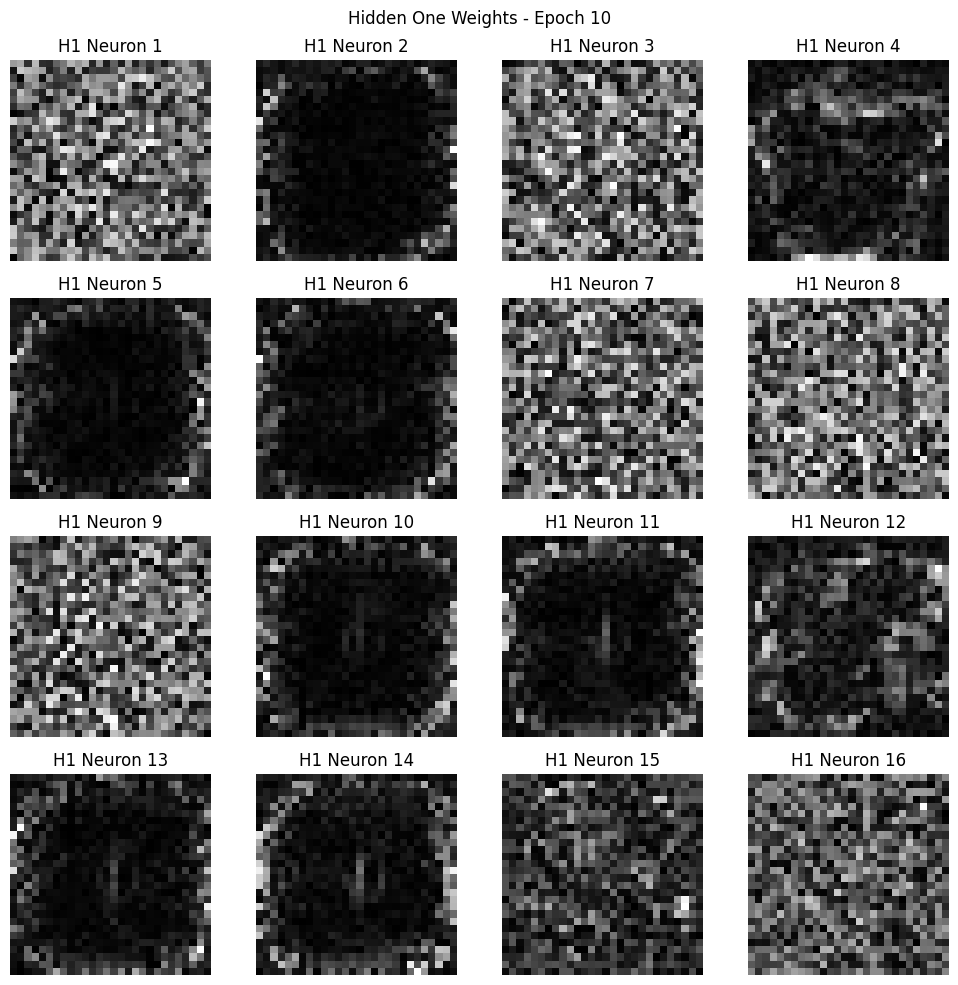

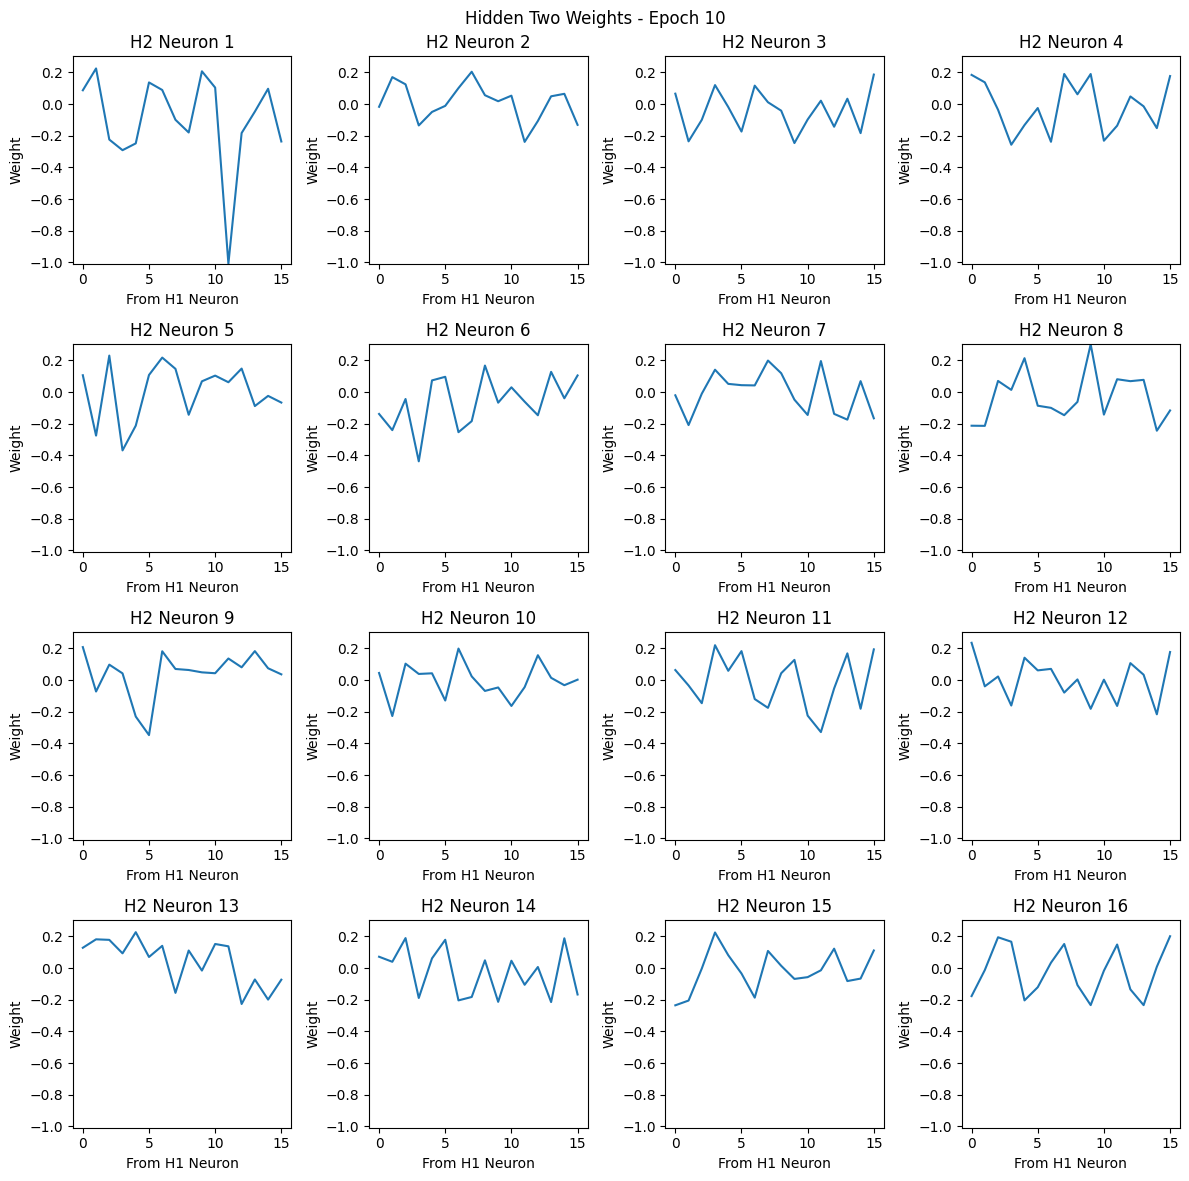

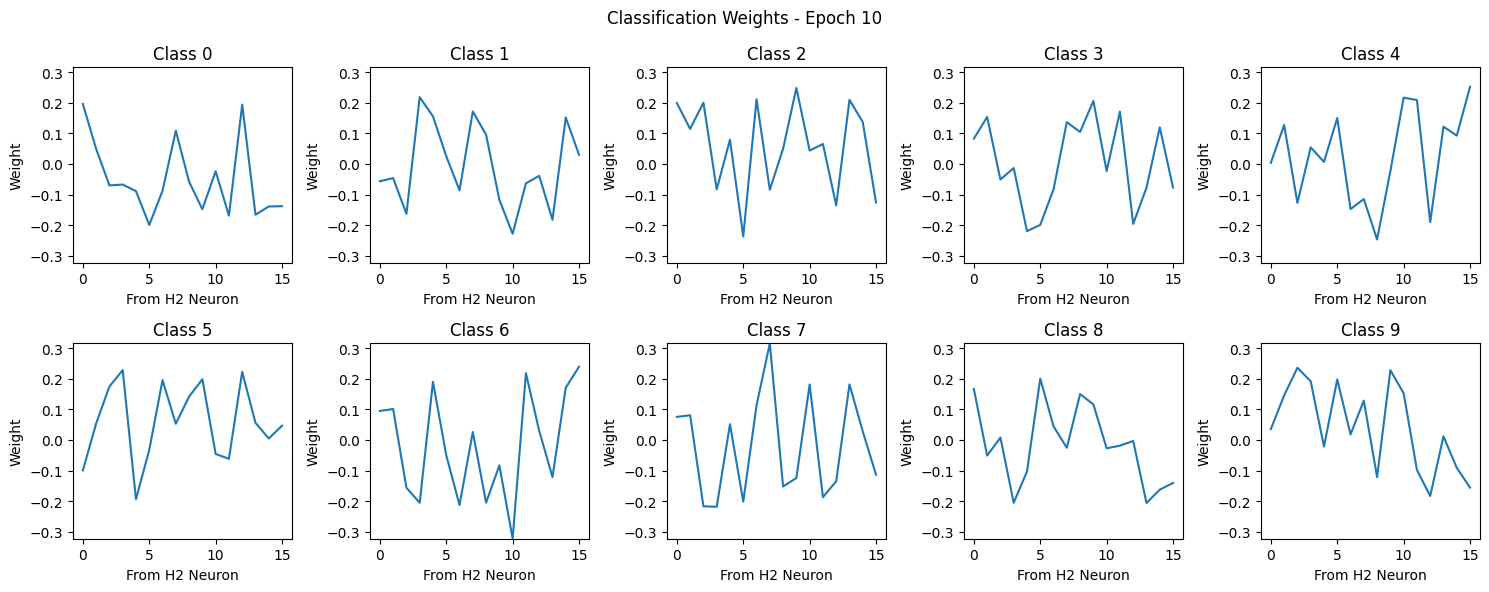

Epoch 11/20
  Train Loss: 18.4340
  SAE Train Loss (hidden one): 0.3335
  SAE Train Loss (hidden two): 0.0360
  Val Loss: 0.4957 | Val Acc: 85.21%


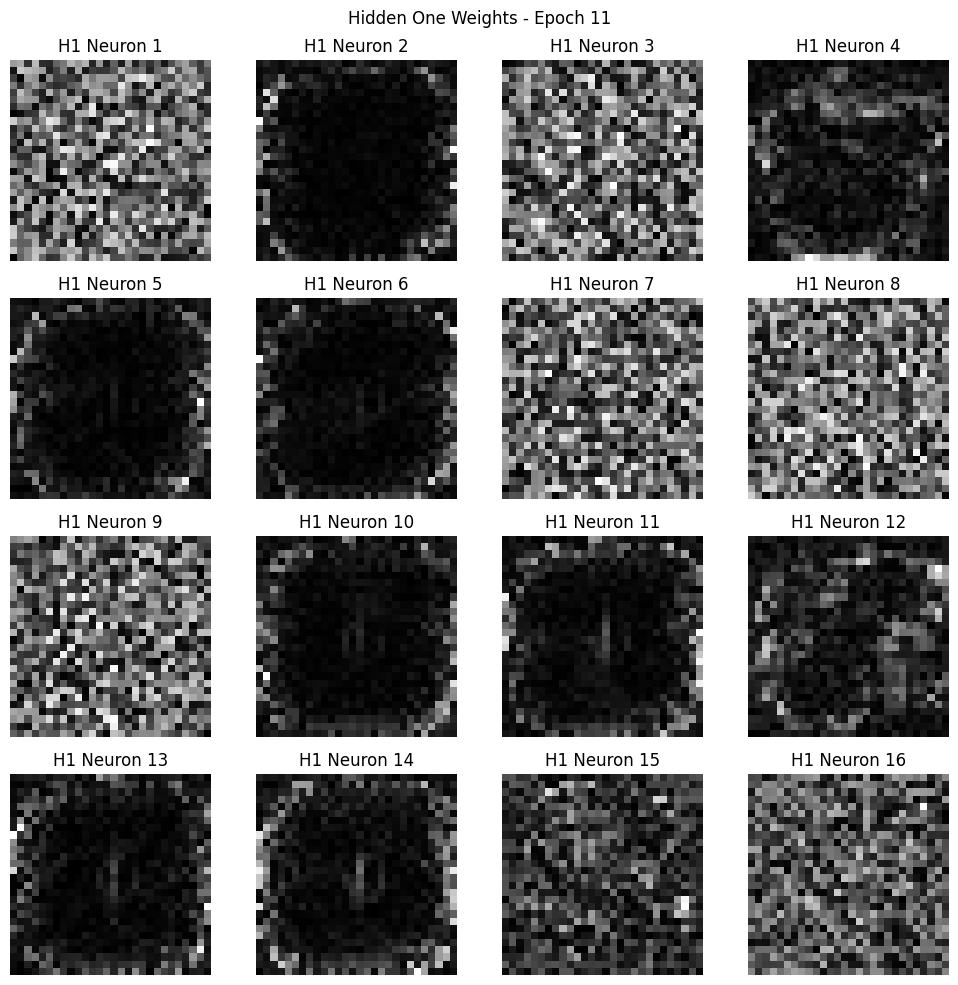

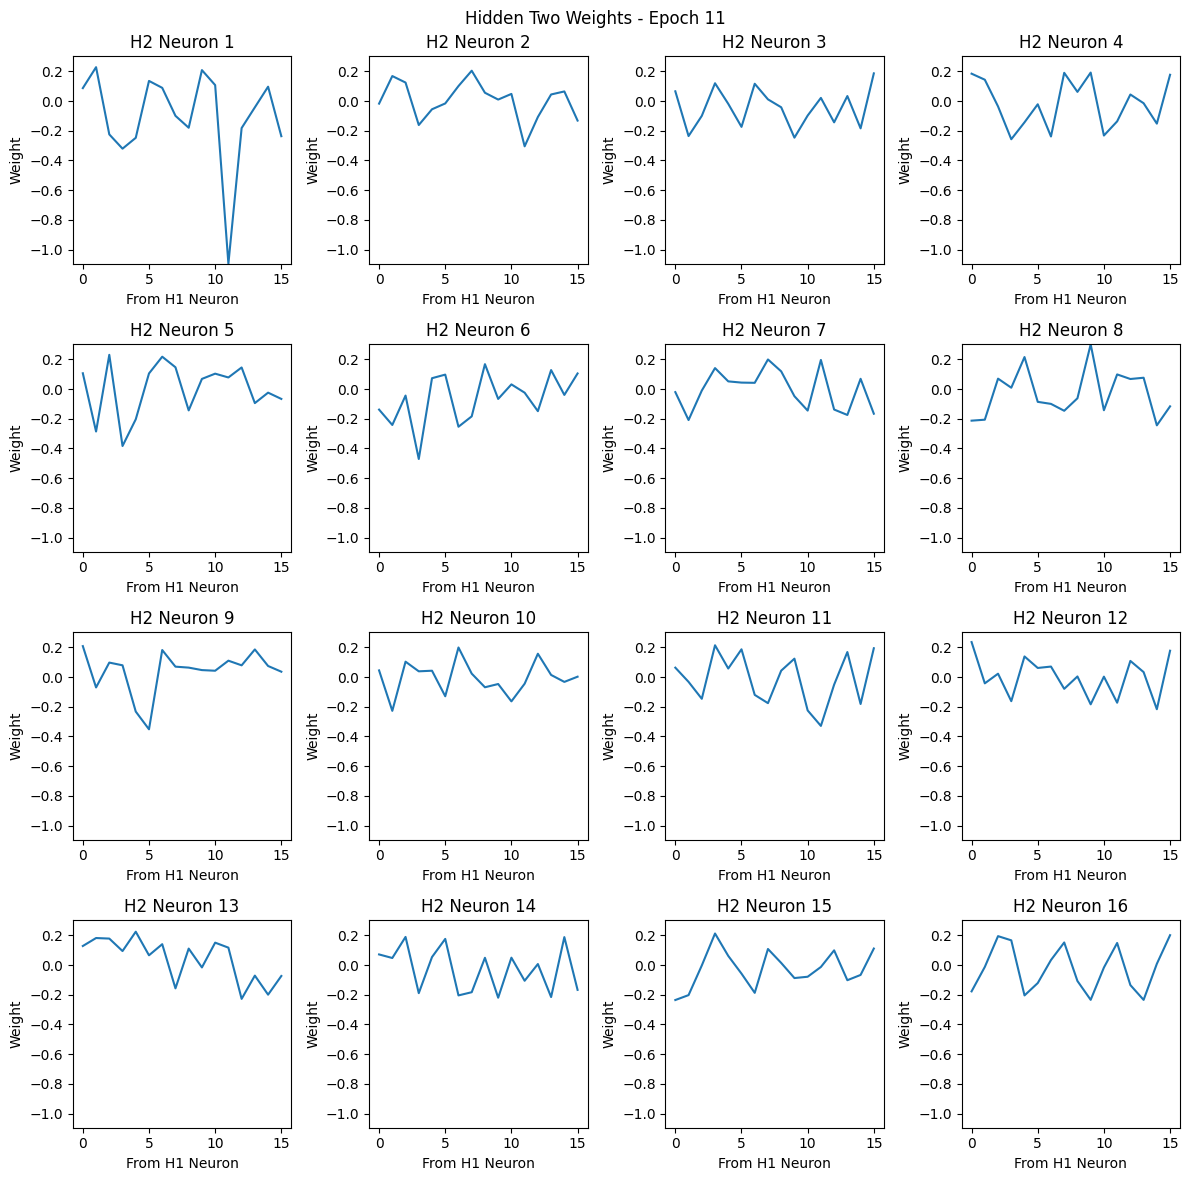

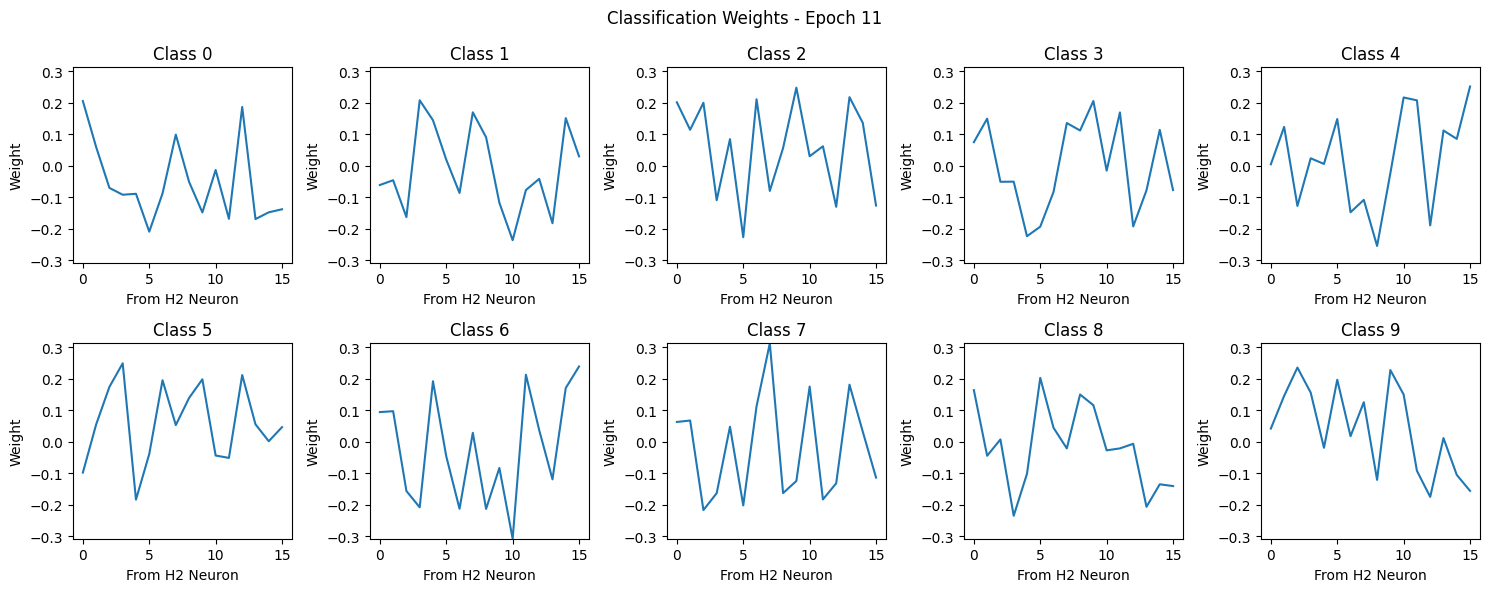

Epoch 12/20
  Train Loss: 18.4449
  SAE Train Loss (hidden one): 0.3088
  SAE Train Loss (hidden two): 0.0329
  Val Loss: 0.5338 | Val Acc: 84.28%


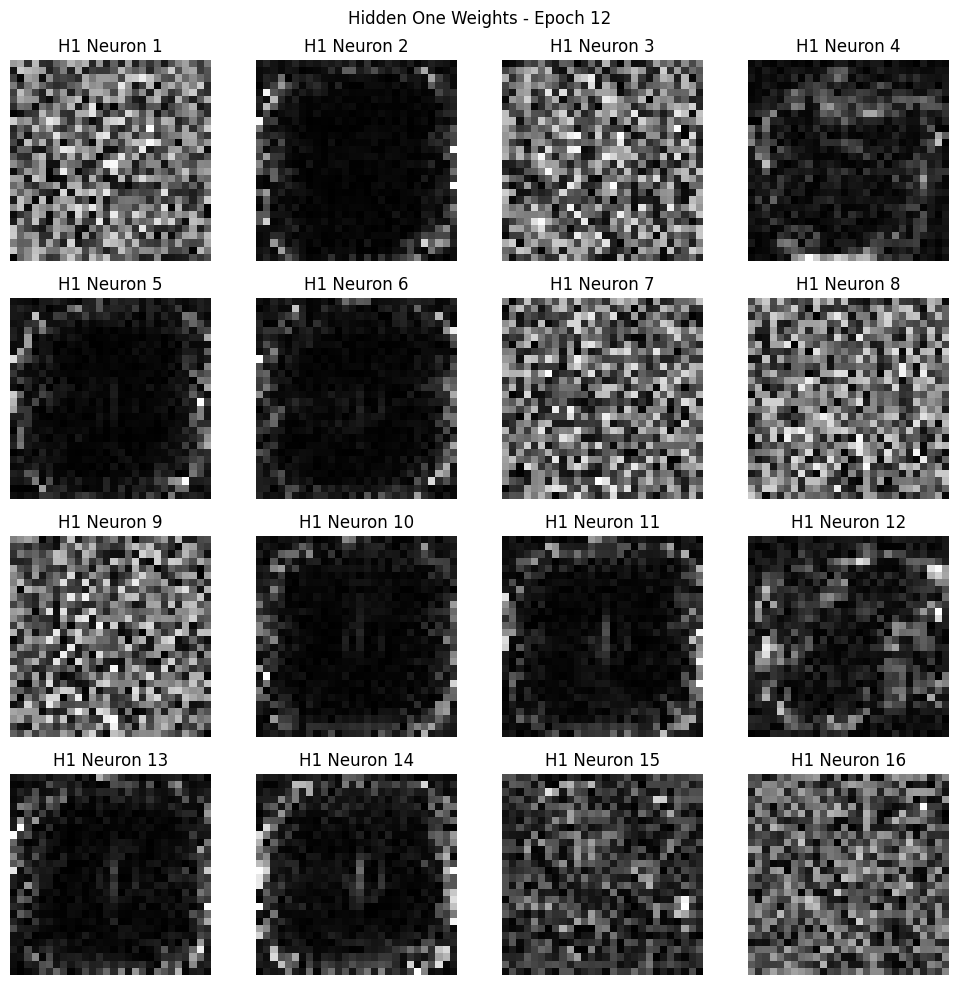

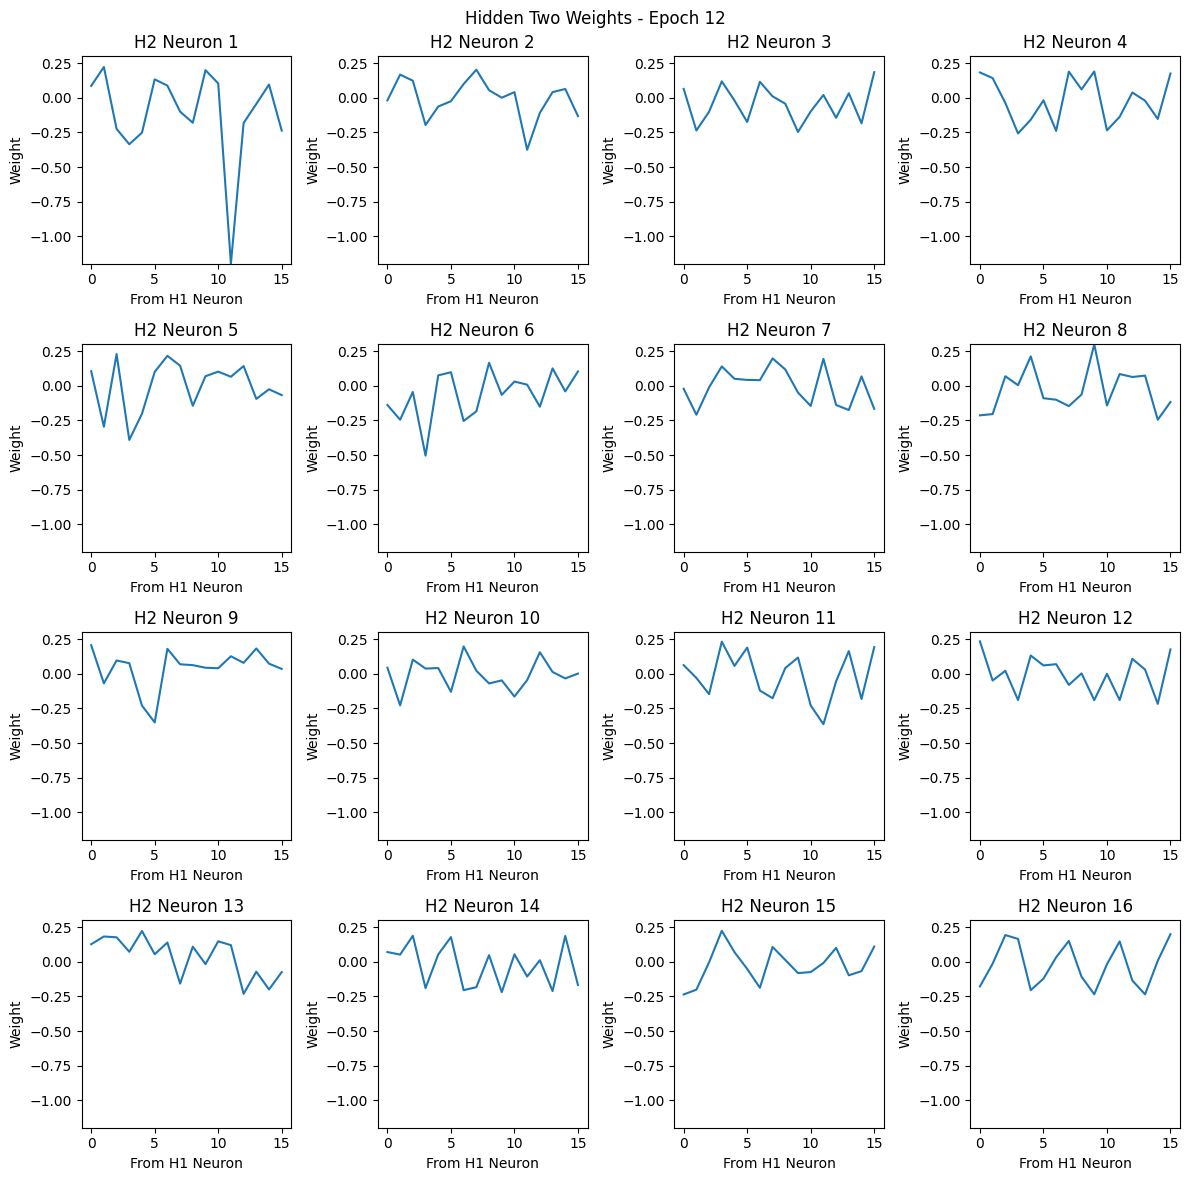

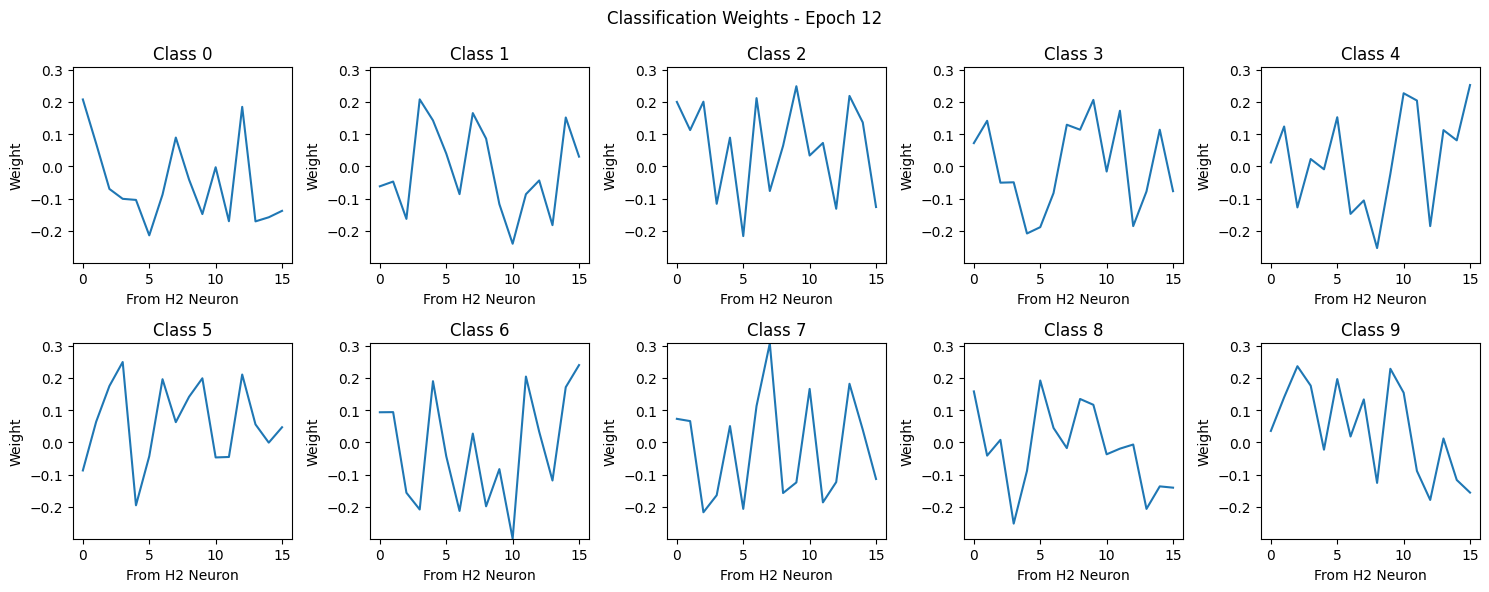

Epoch 13/20
  Train Loss: 18.4267
  SAE Train Loss (hidden one): 0.3122
  SAE Train Loss (hidden two): 0.0298
  Val Loss: 0.5623 | Val Acc: 82.99%


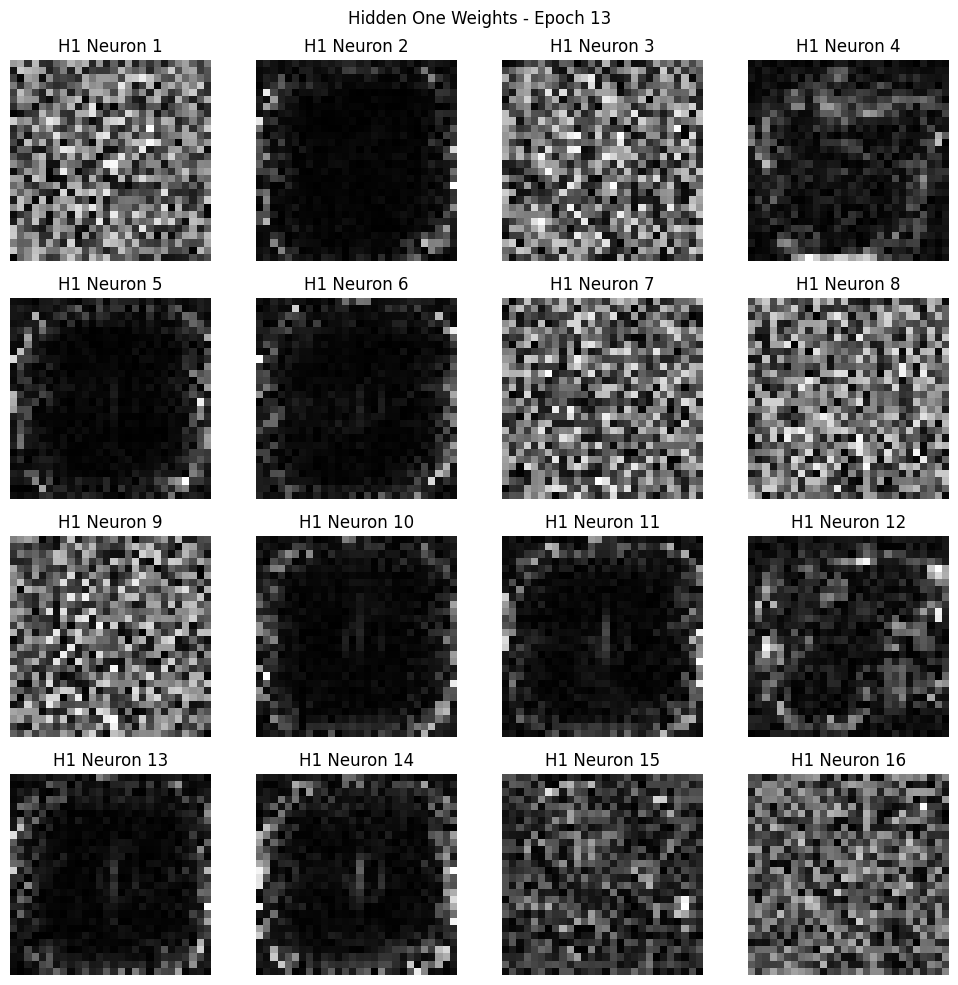

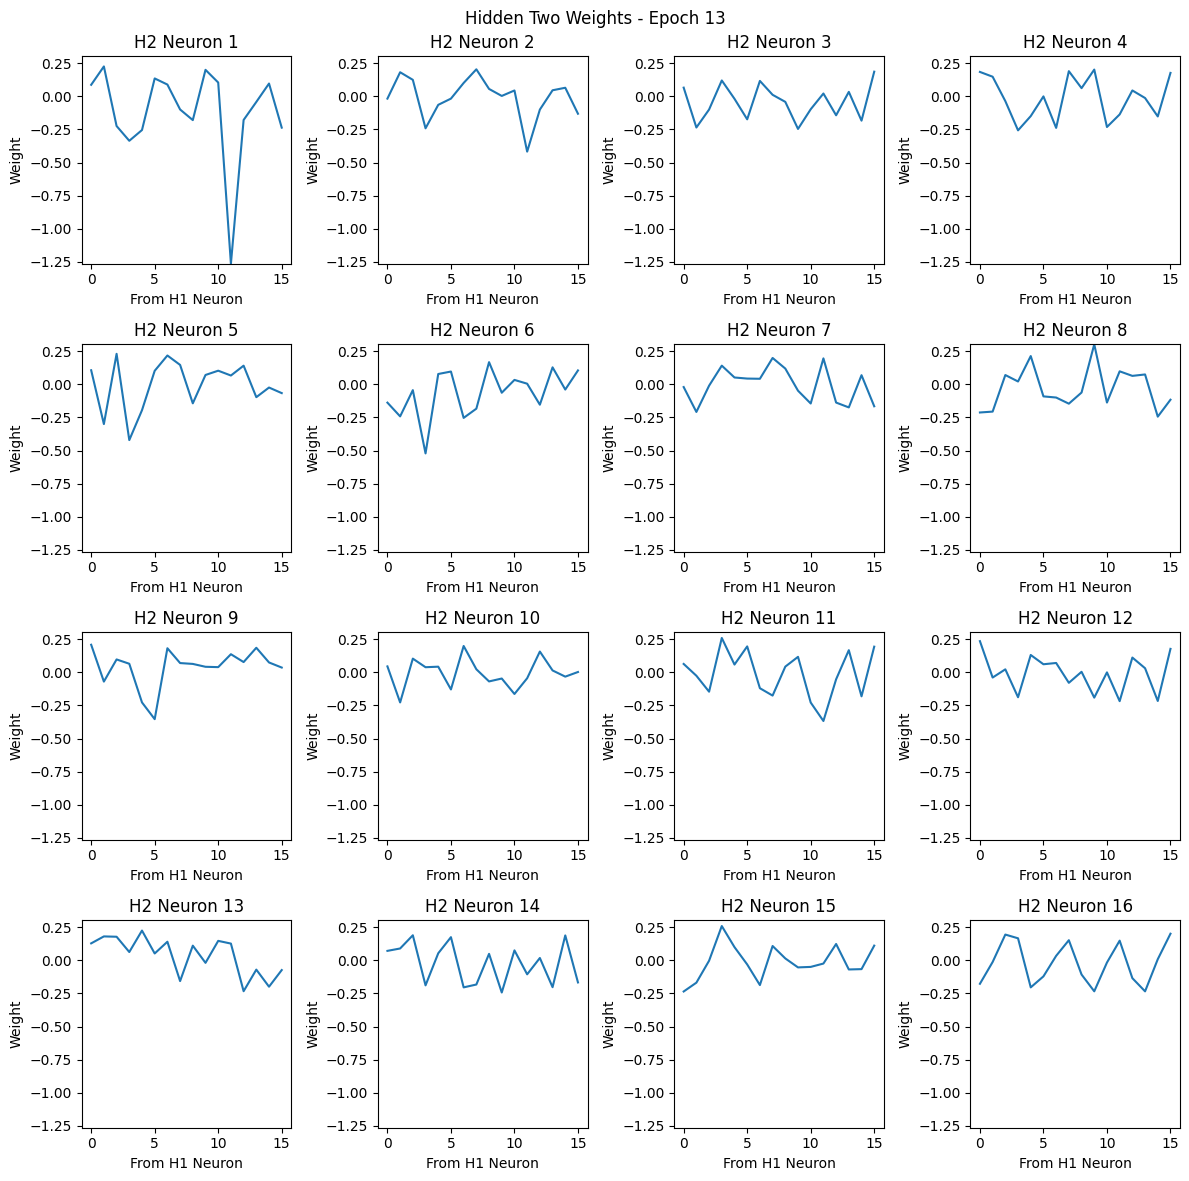

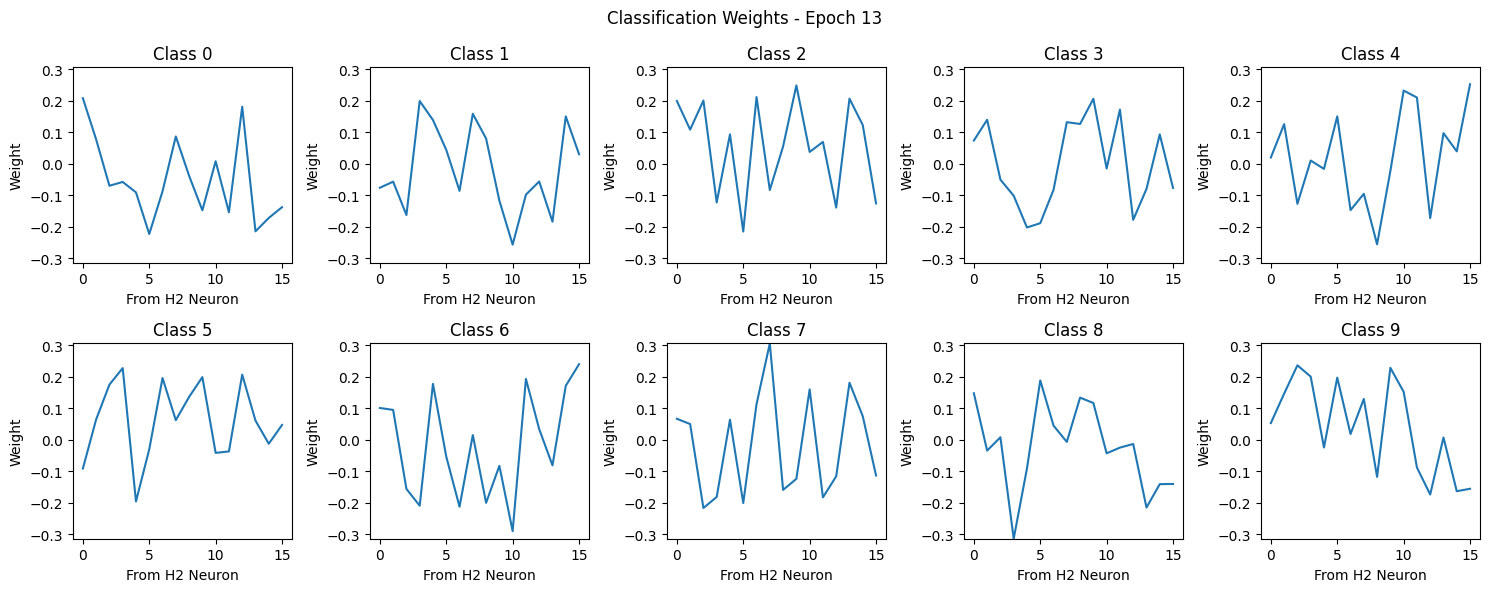

Epoch 14/20
  Train Loss: 18.4478
  SAE Train Loss (hidden one): 0.3125
  SAE Train Loss (hidden two): 0.0276
  Val Loss: 0.5808 | Val Acc: 82.79%


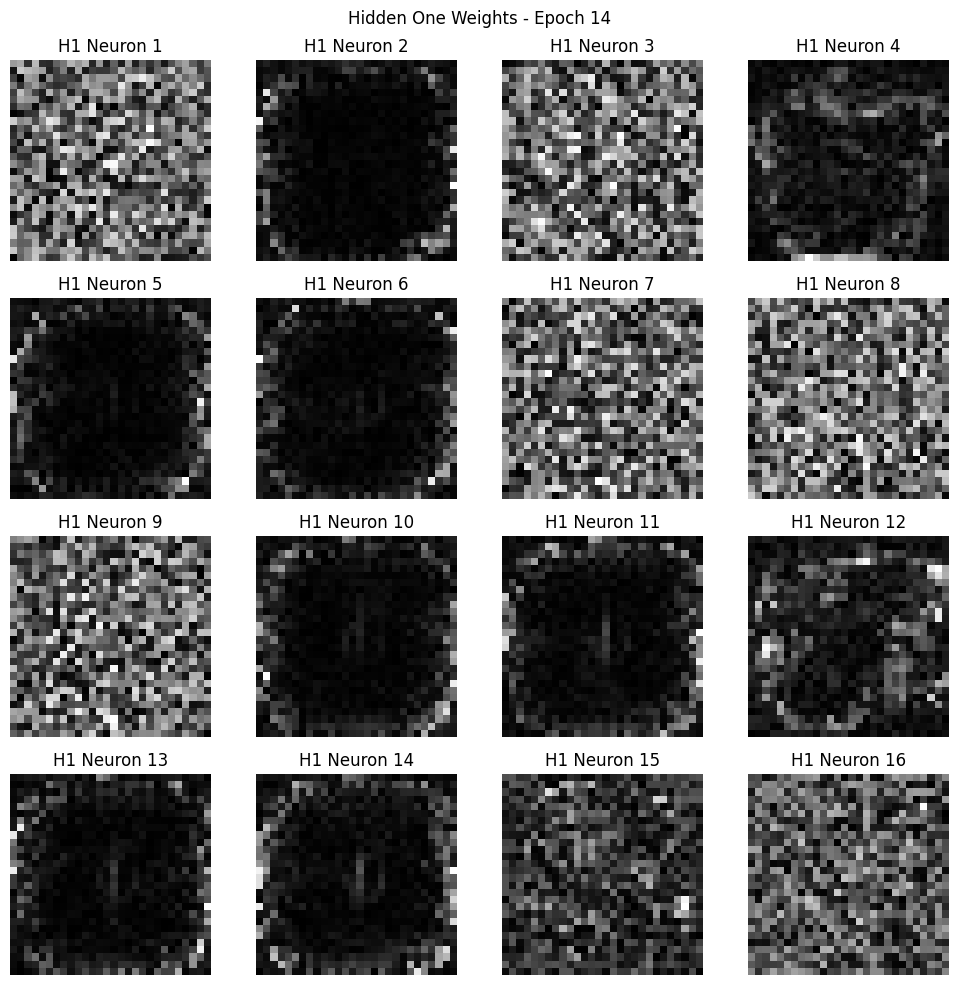

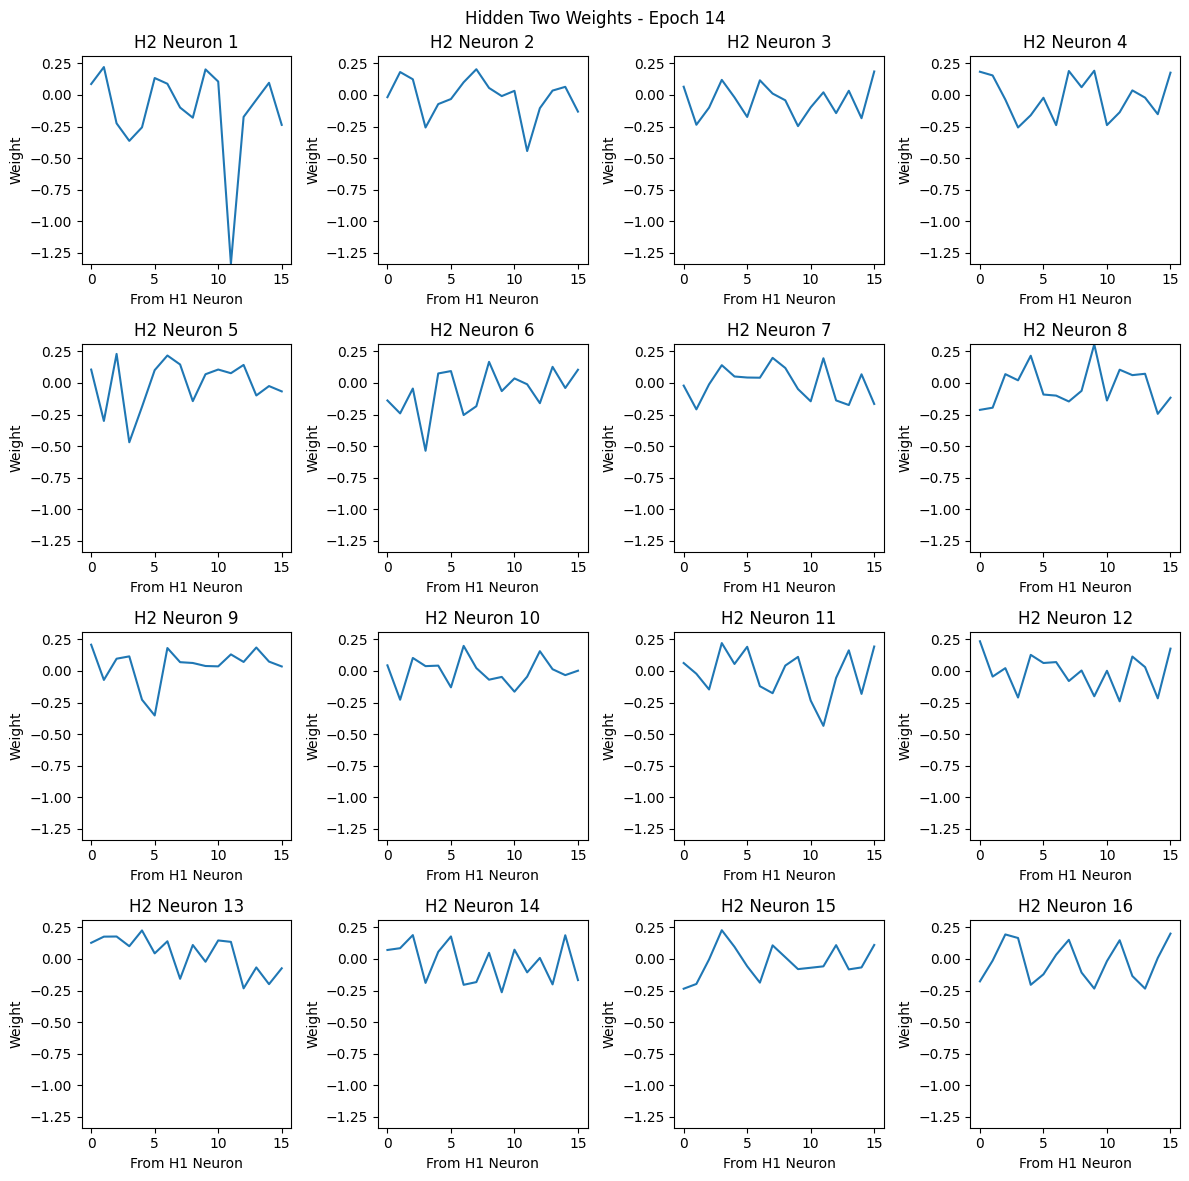

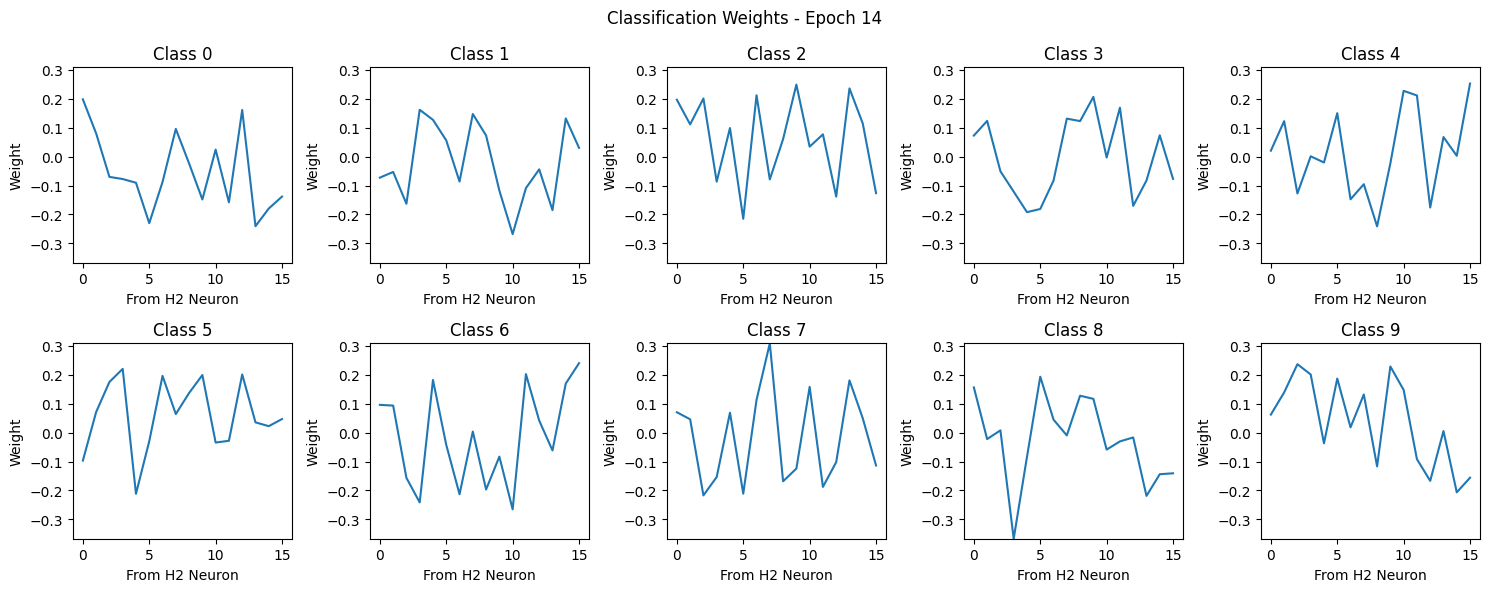

Epoch 15/20
  Train Loss: 18.4280
  SAE Train Loss (hidden one): 0.2921
  SAE Train Loss (hidden two): 0.0245
  Val Loss: 0.4734 | Val Acc: 86.47%
  Saved model with Val Acc: 86.47%


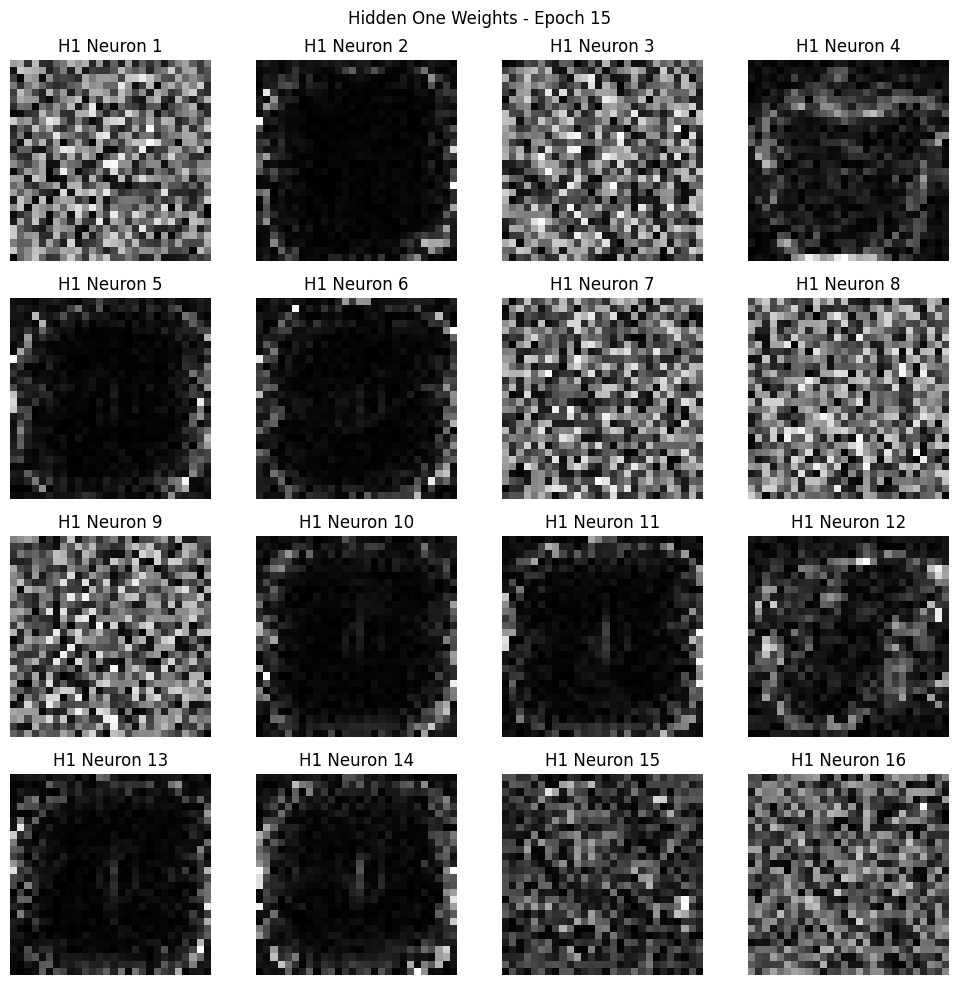

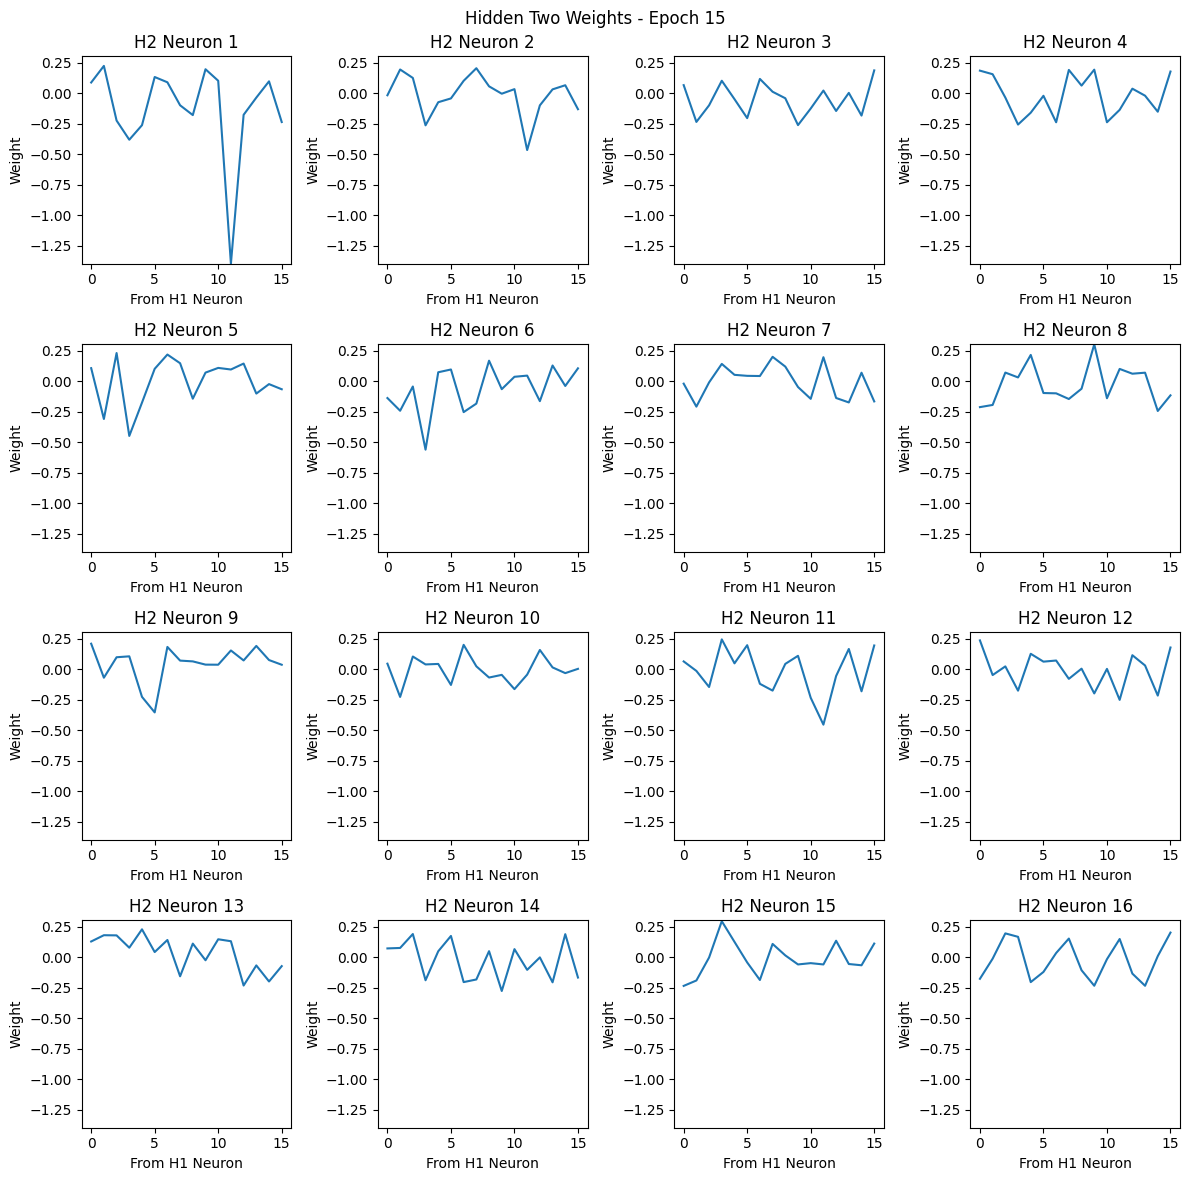

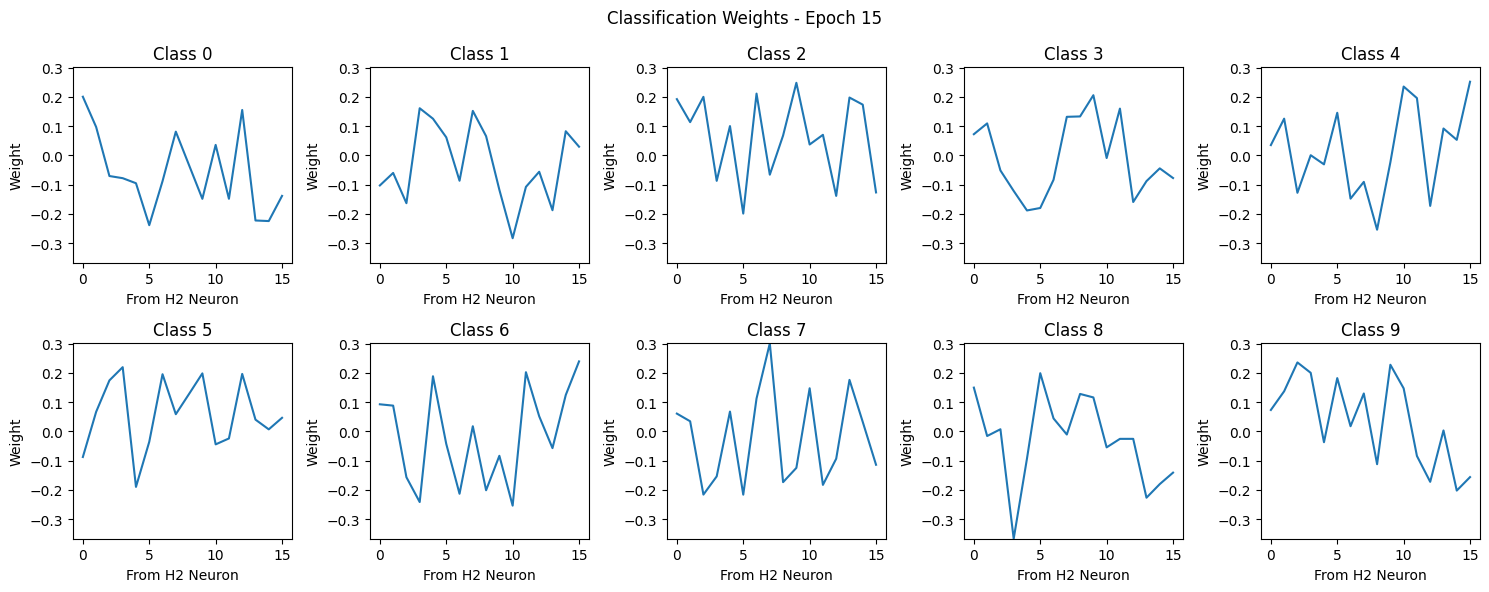

Epoch 16/20
  Train Loss: 18.4468
  SAE Train Loss (hidden one): 0.2838
  SAE Train Loss (hidden two): 0.0238
  Val Loss: 0.4492 | Val Acc: 86.92%
  Saved model with Val Acc: 86.92%


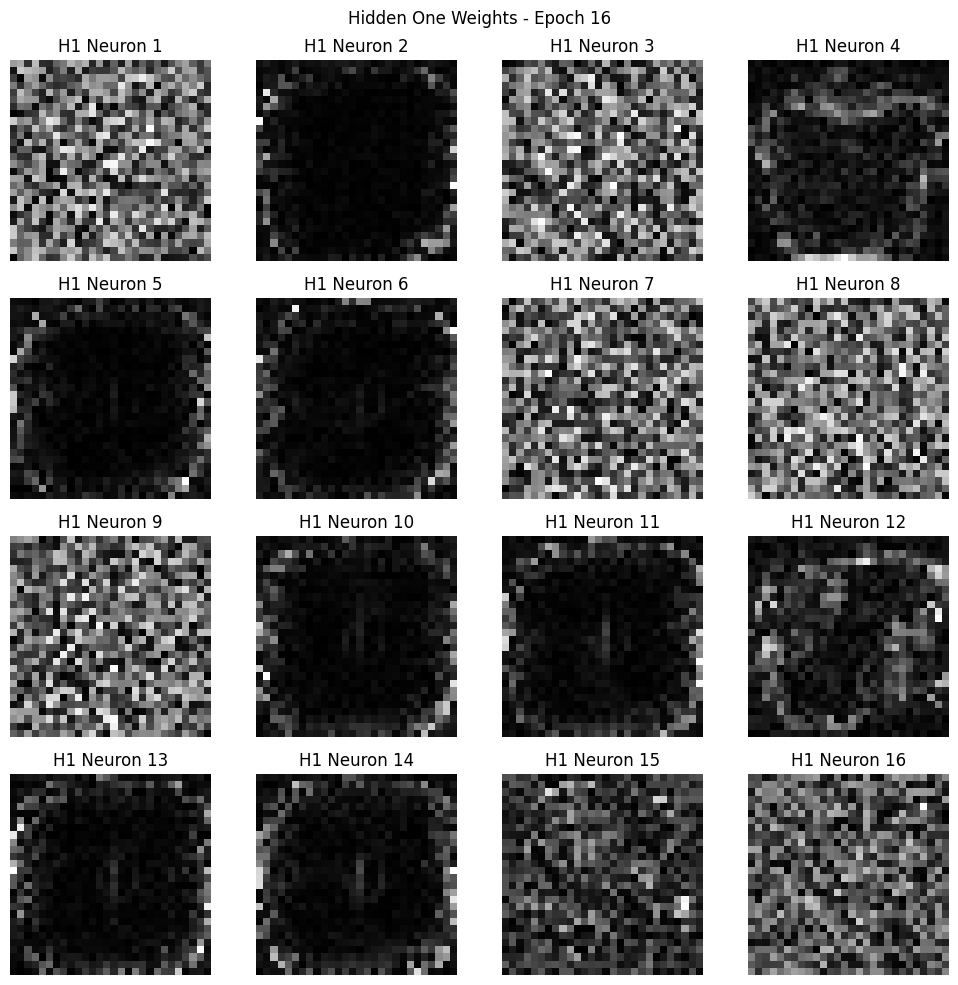

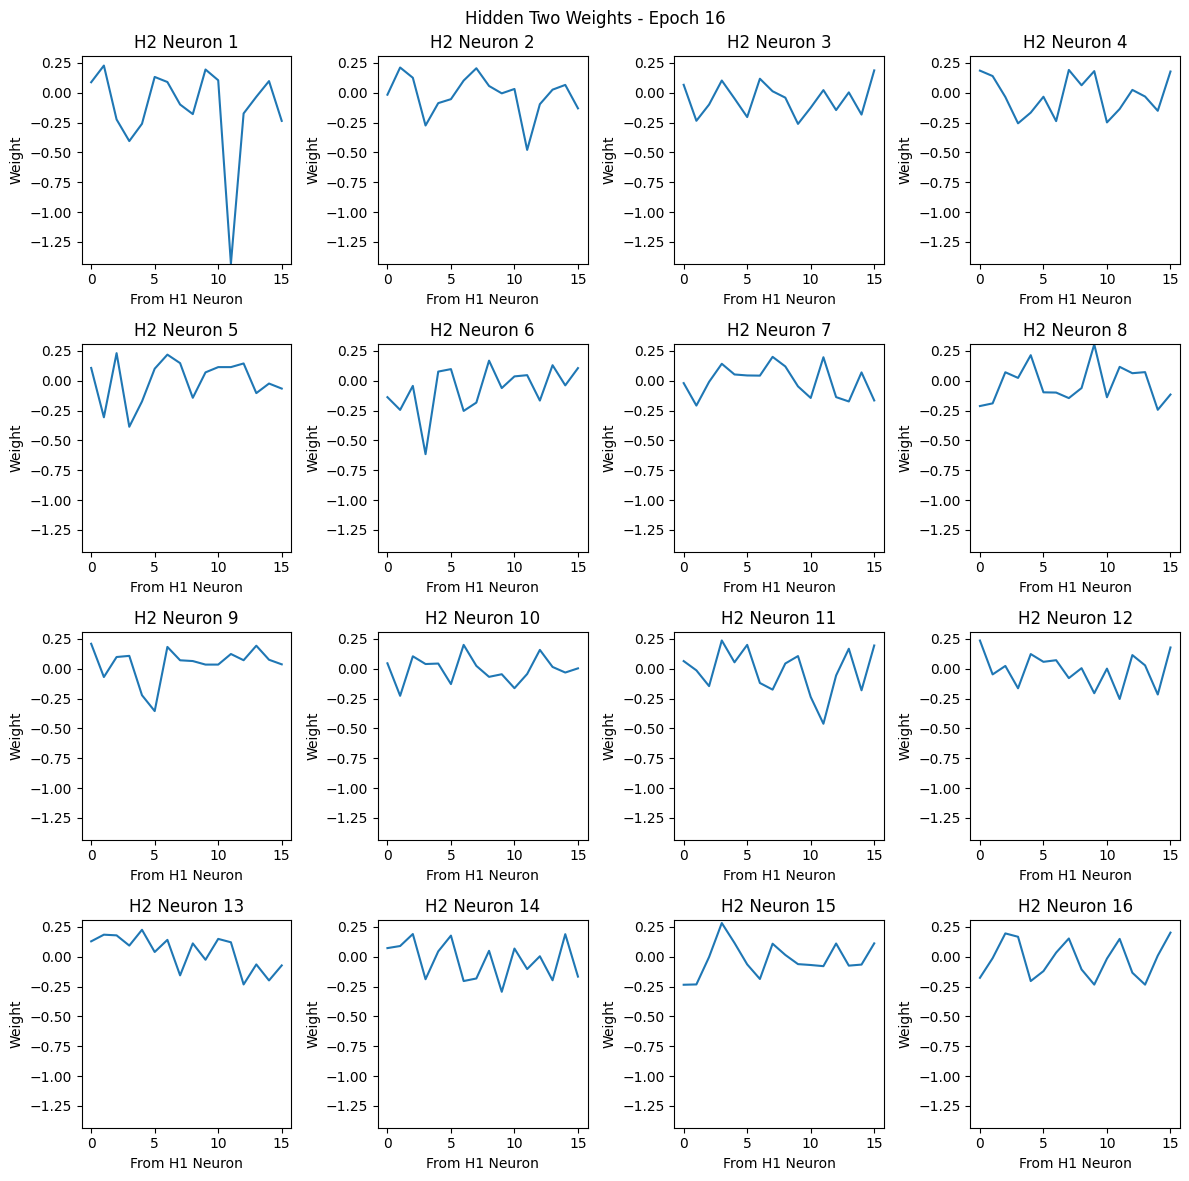

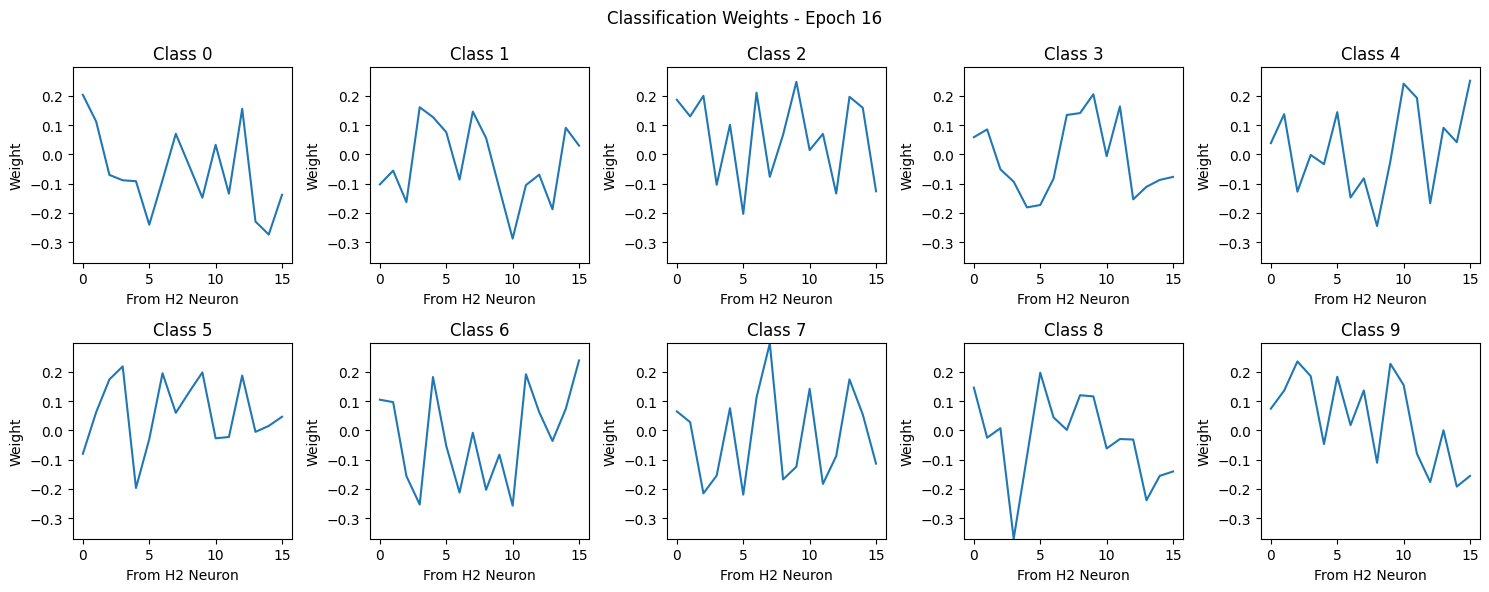

Epoch 17/20
  Train Loss: 18.4431
  SAE Train Loss (hidden one): 0.2787
  SAE Train Loss (hidden two): 0.0216
  Val Loss: 0.5934 | Val Acc: 82.60%


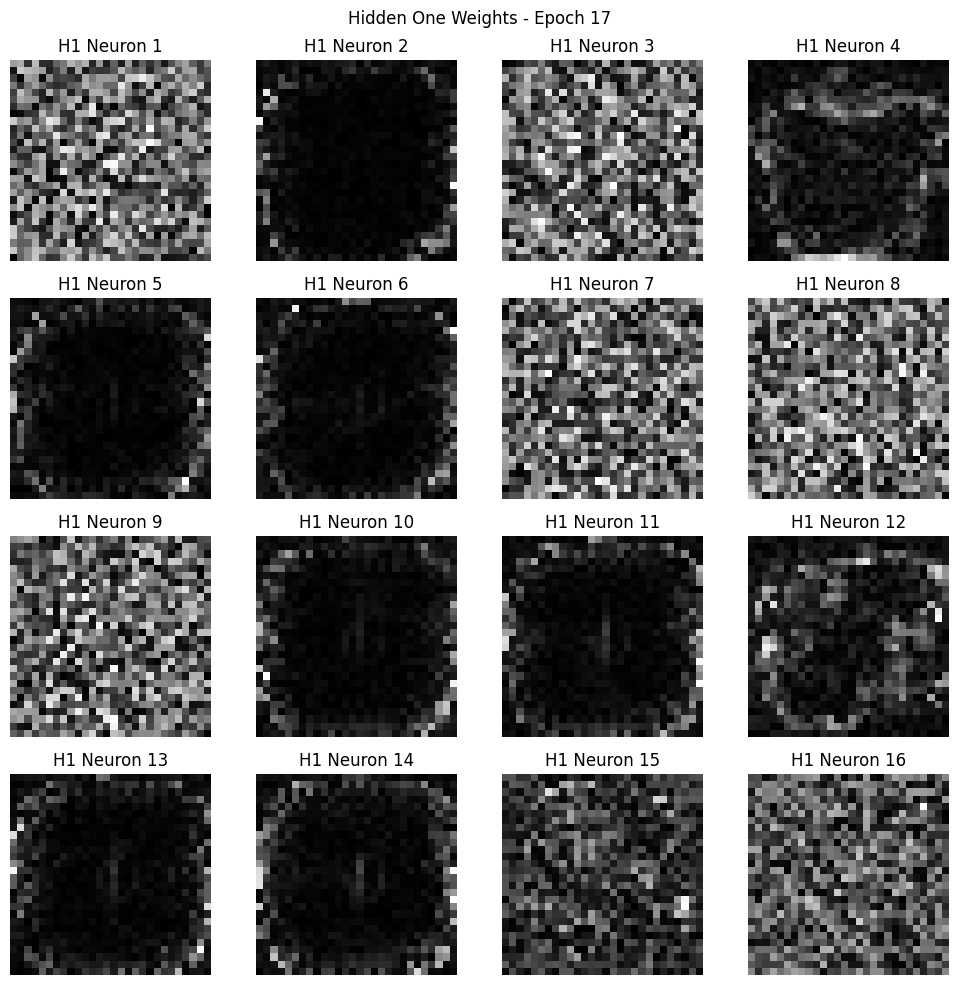

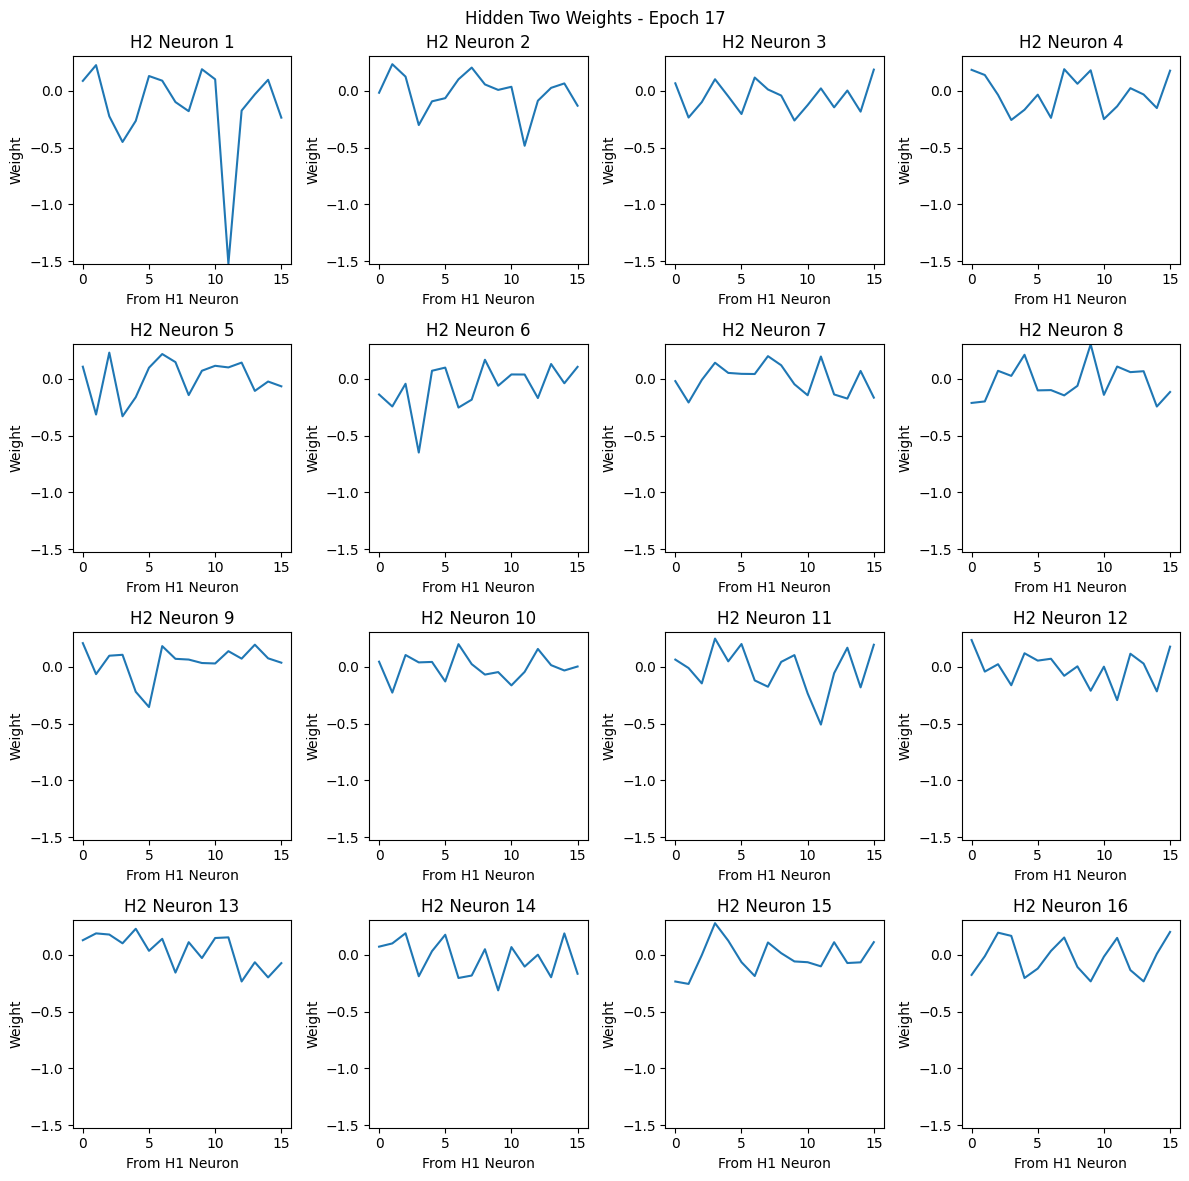

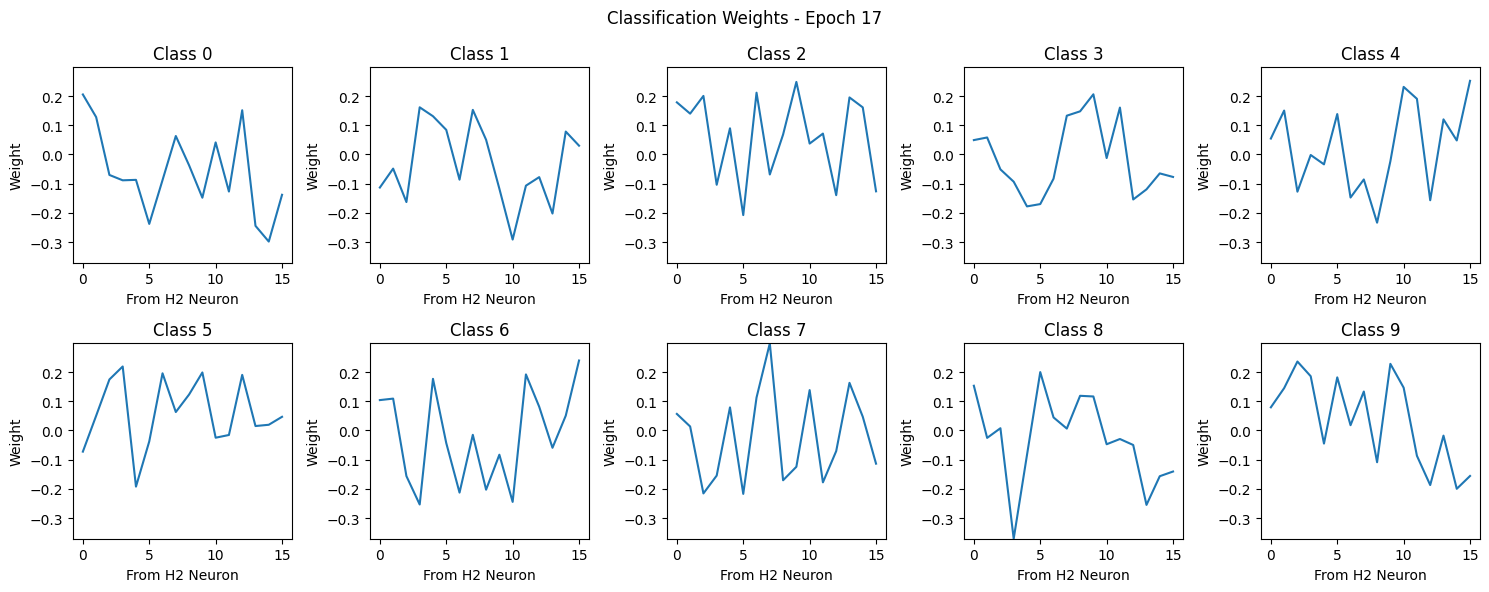

Epoch 18/20
  Train Loss: 18.4438
  SAE Train Loss (hidden one): 0.2899
  SAE Train Loss (hidden two): 0.0191
  Val Loss: 0.4286 | Val Acc: 87.54%
  Saved model with Val Acc: 87.54%


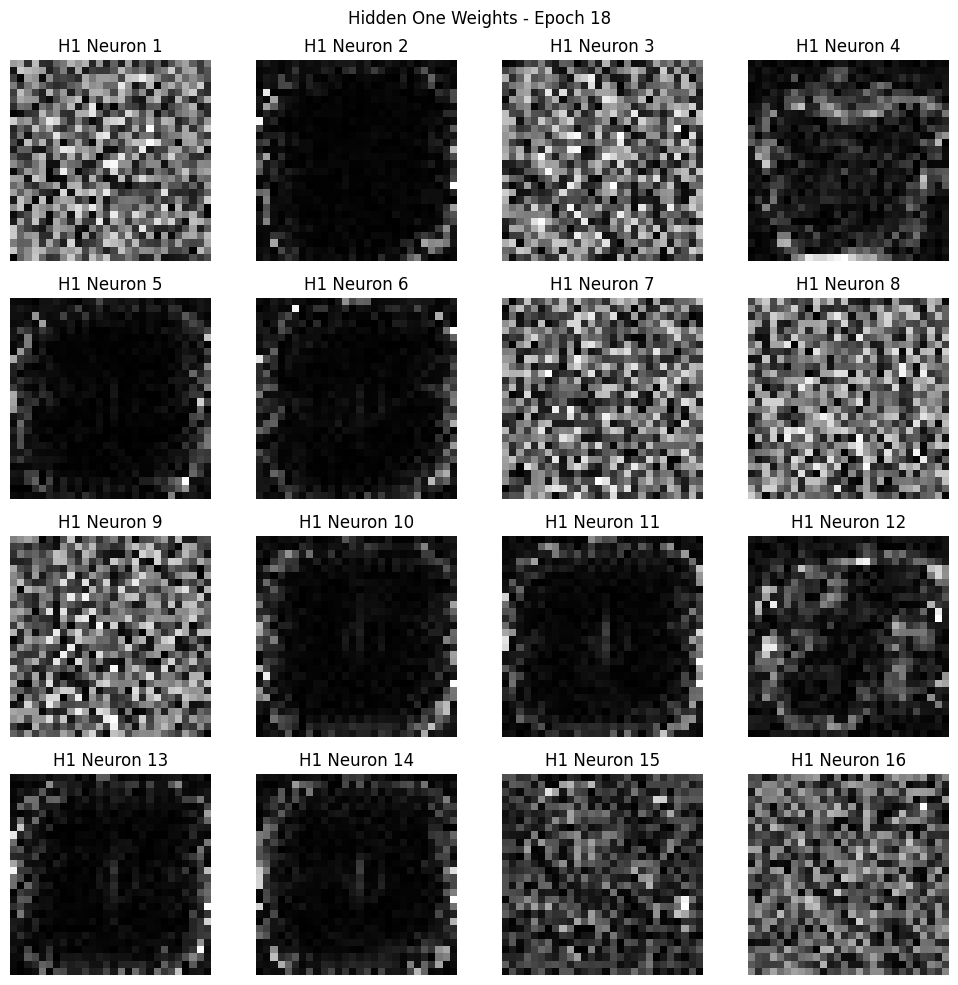

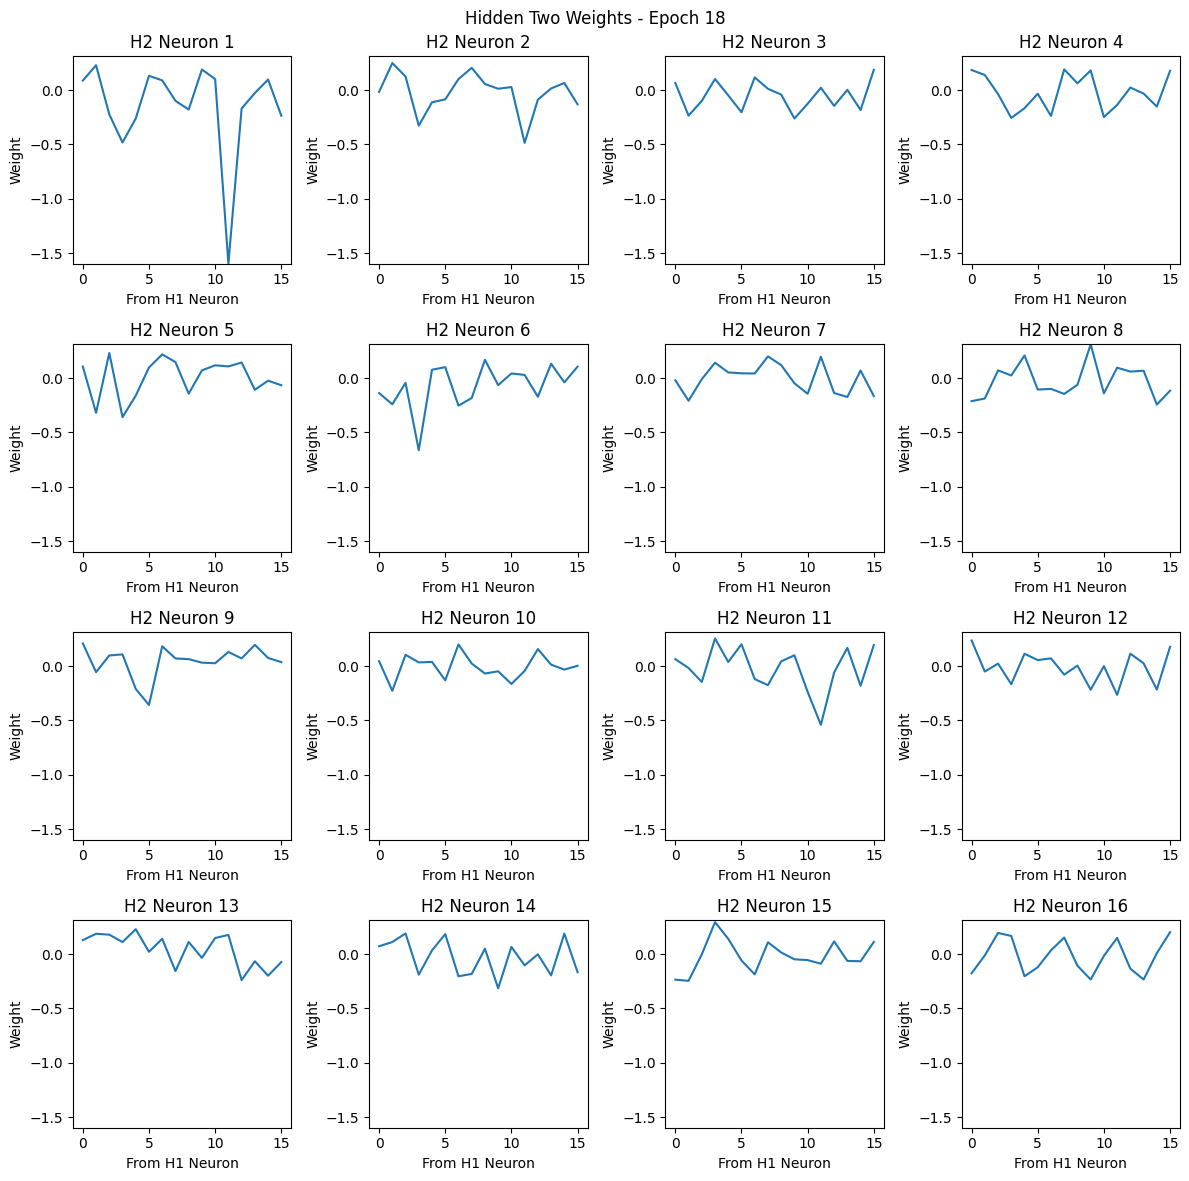

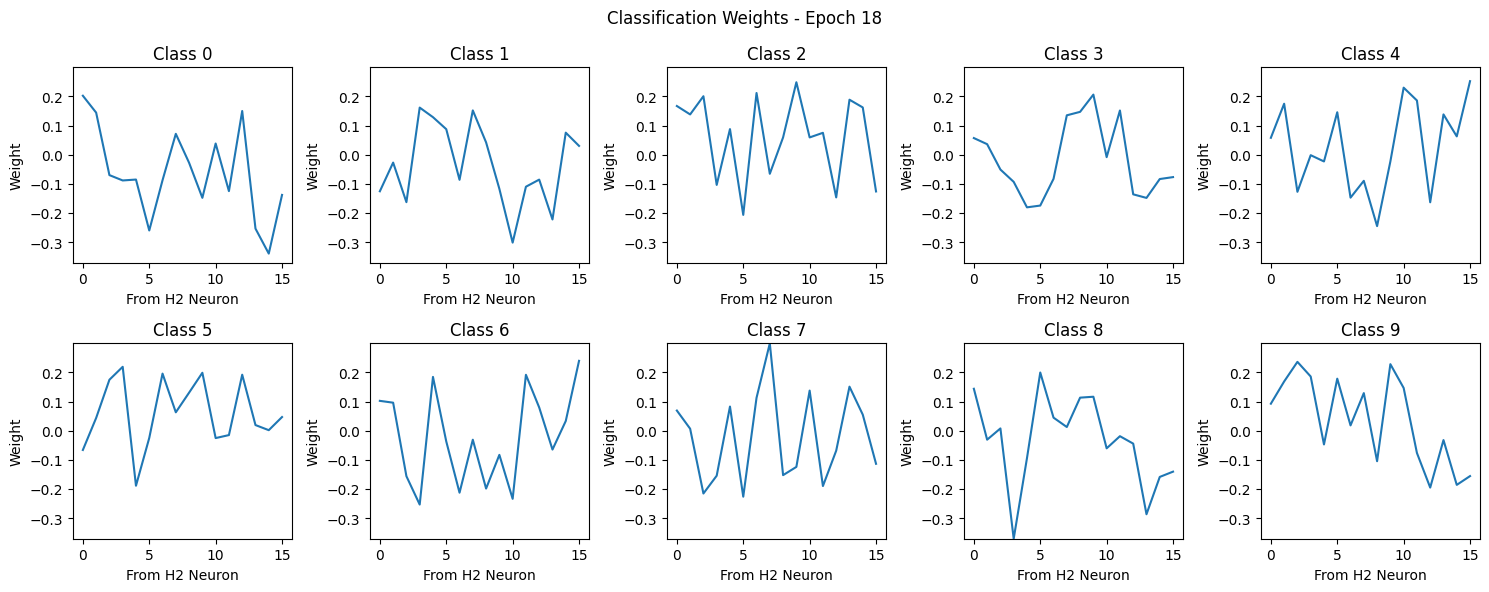

Epoch 19/20
  Train Loss: 18.4377
  SAE Train Loss (hidden one): 0.2651
  SAE Train Loss (hidden two): 0.0176
  Val Loss: 0.5195 | Val Acc: 82.99%


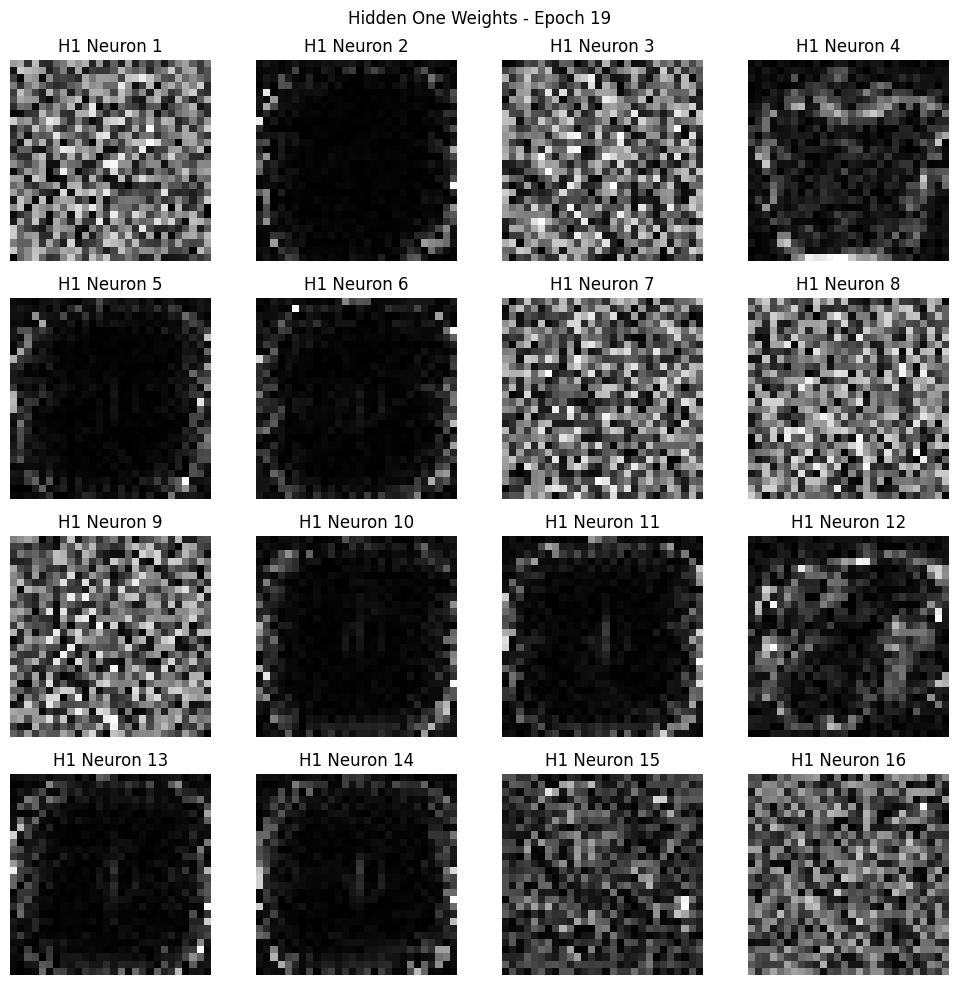

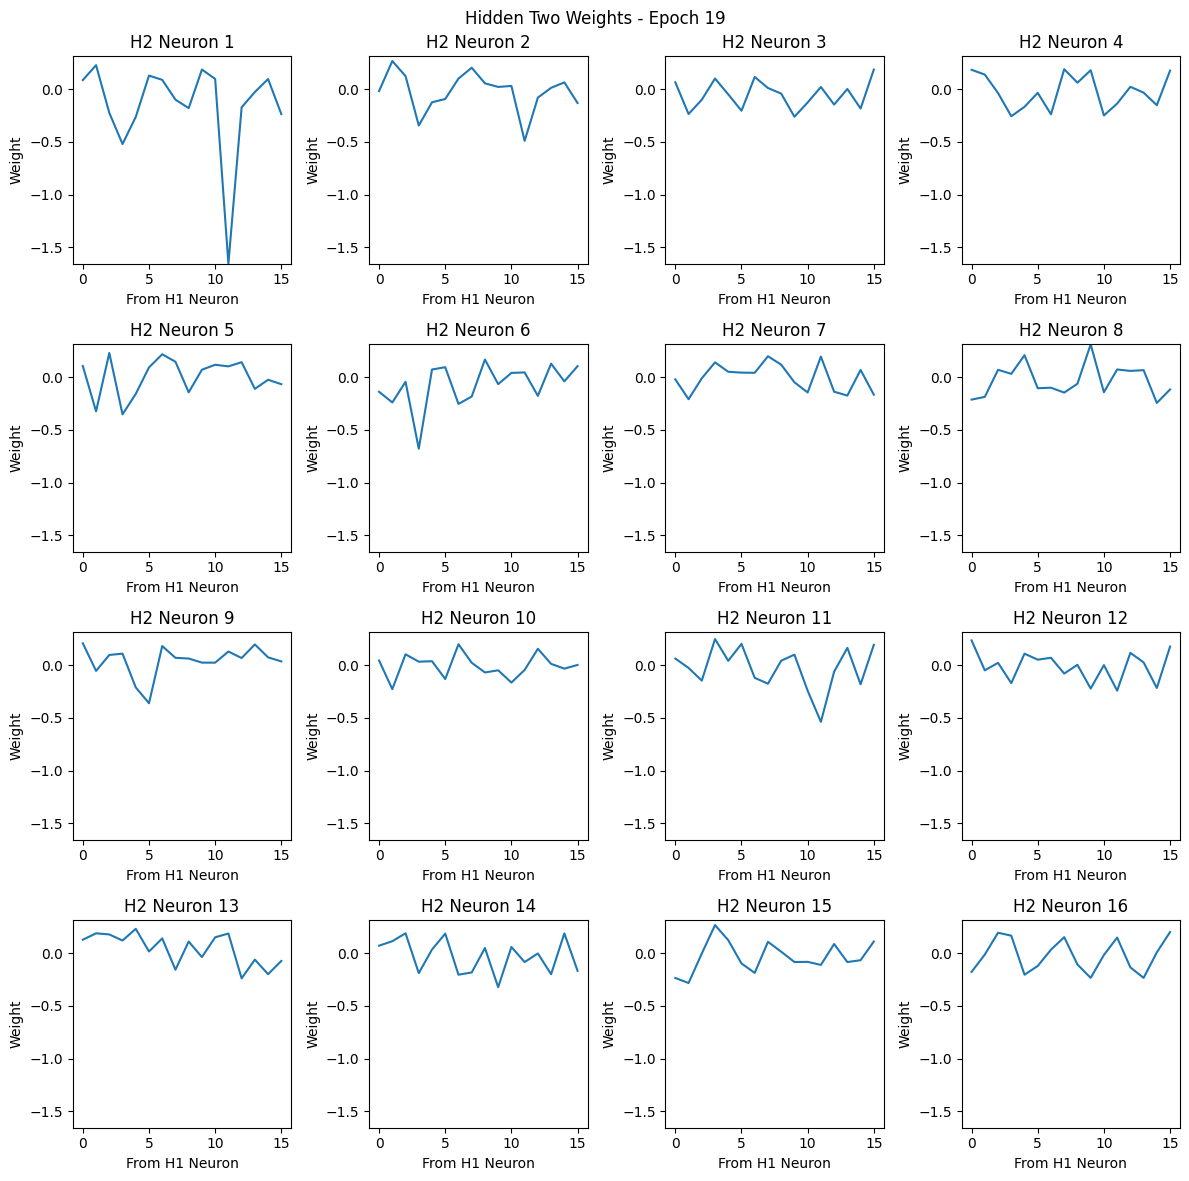

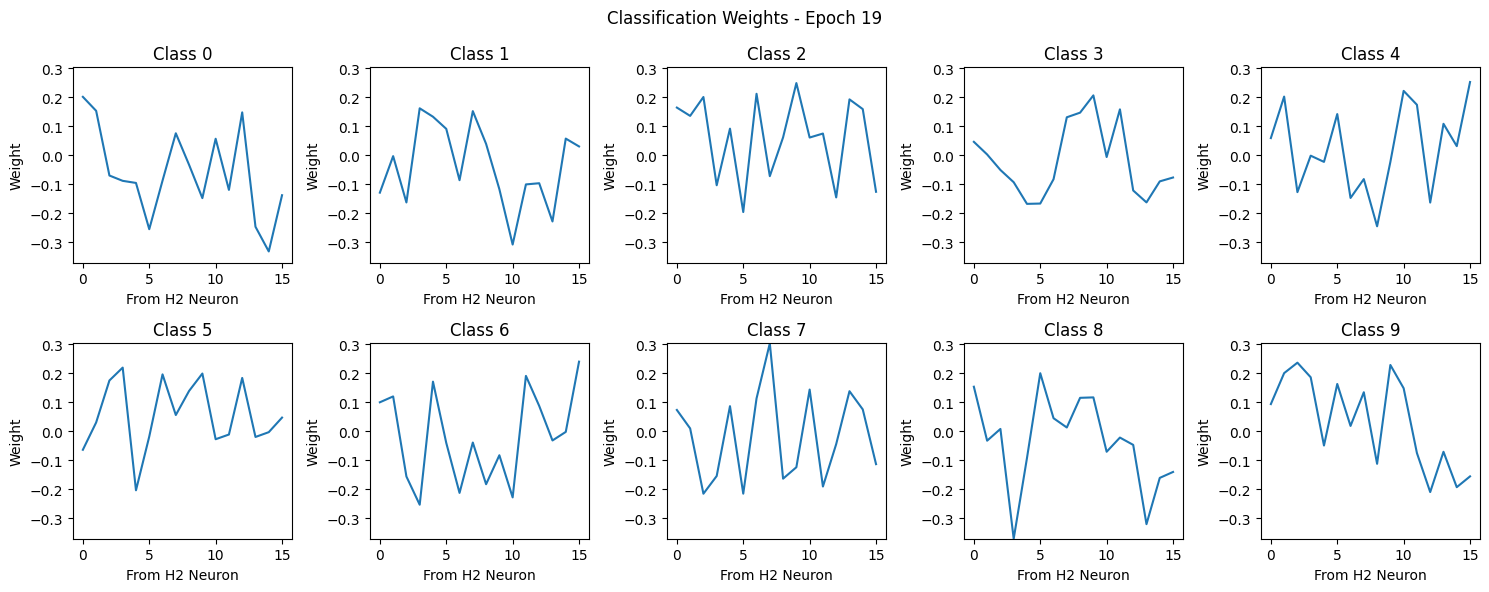

Epoch 20/20
  Train Loss: 18.4304
  SAE Train Loss (hidden one): 0.2663
  SAE Train Loss (hidden two): 0.0185
  Val Loss: 0.4306 | Val Acc: 87.22%


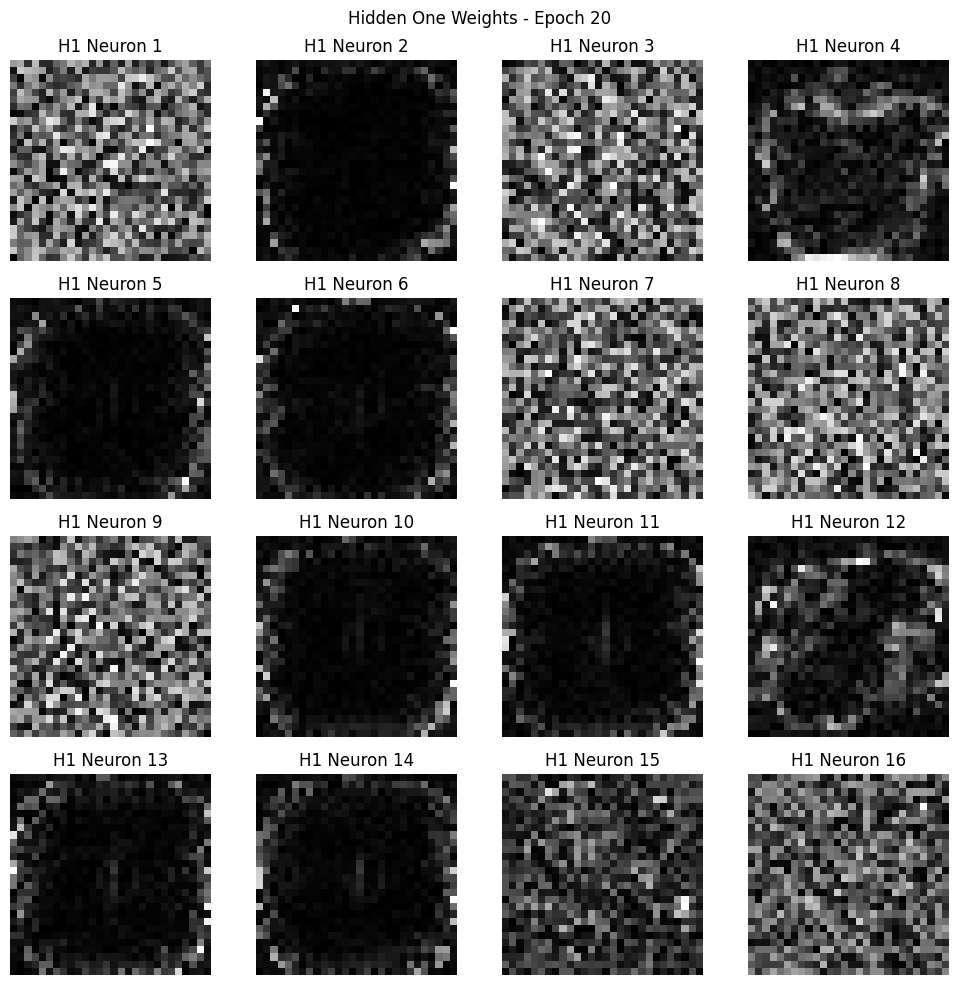

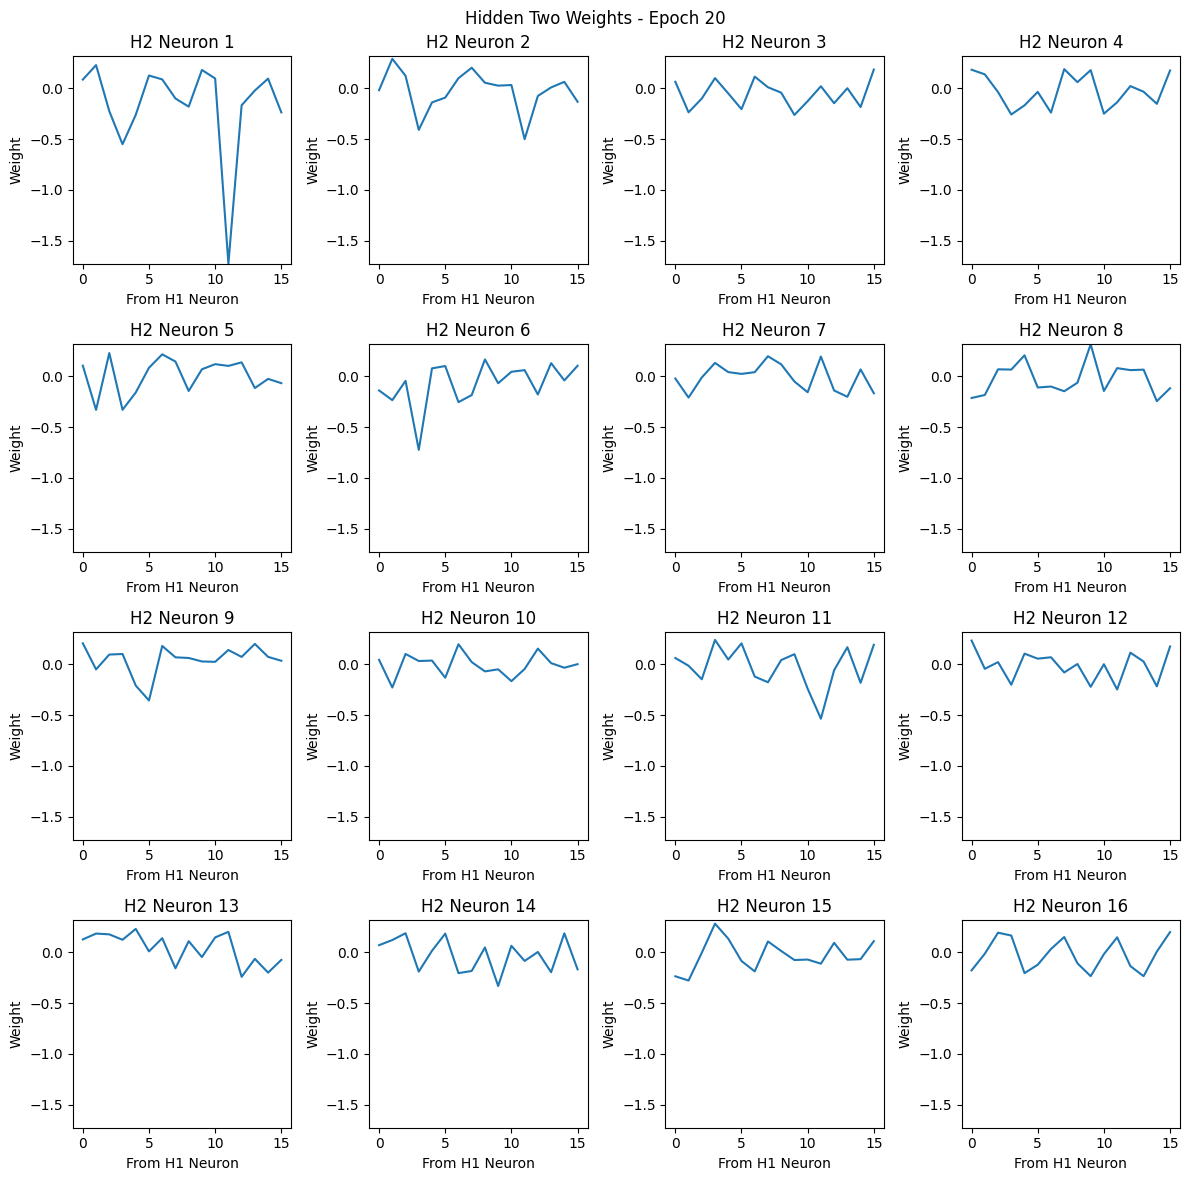

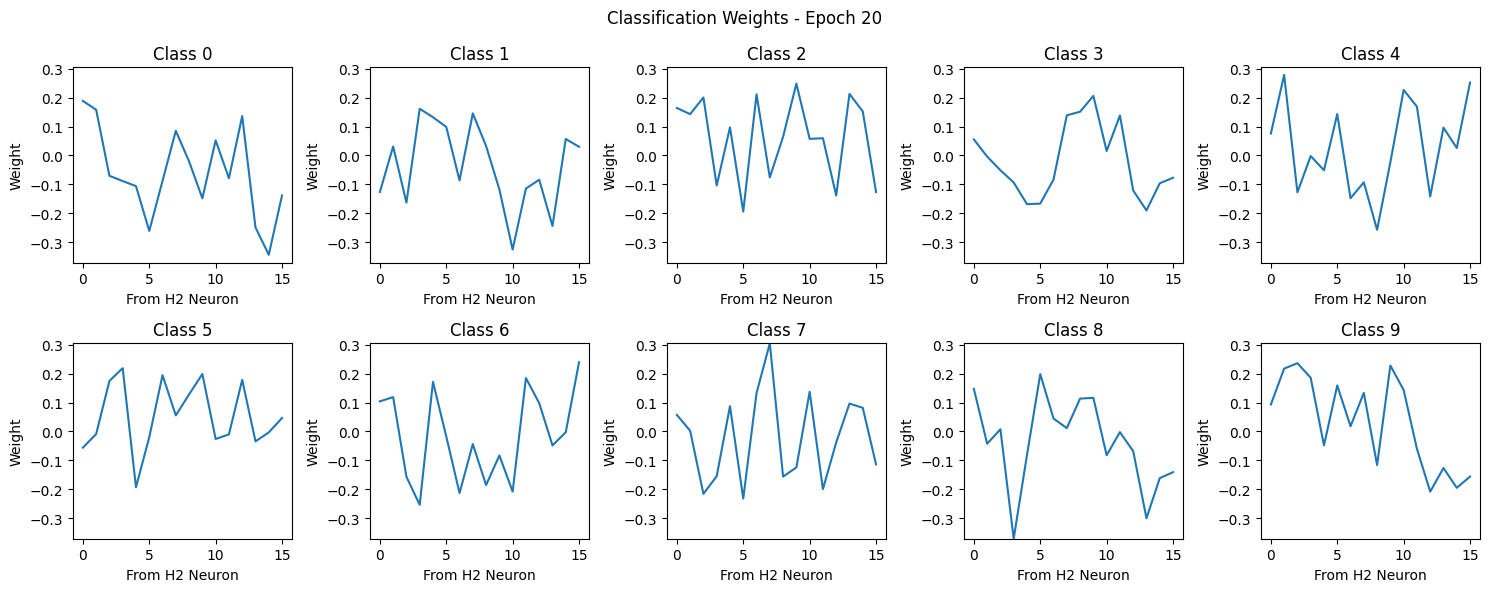

In [24]:
best_model = None
best_sae_one = None
best_sae_two = None
num_epochs = 20

best_val_acc = 0.0
best_val_loss = float('inf')

validation_losses = []
training_losses = []
SAE_hidden_one_losses = []
SAE_hidden_two_losses = []

# Initialize storage for training features and labels
feature_activations_one_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
feature_activations_two_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
labels_train = torch.zeros(len(train_loader.dataset), dtype=torch.long)

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    sae_hidden_two.train()
    sae_hidden_one.train()
    
    train_loss = 0.0
    total_sae_loss_hidden_two = 0.0
    total_sae_loss_hidden_one = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch_idx, batch in enumerate(train_bar):
        # deconstruct batch items
        images, labels, acts_one = batch
        images, labels, acts_one = images.to(device), labels.to(device), acts_one.to(device)
        
        # forward pass
        classification_out, hidden_act_one, hidden_act_two = model(images)

        # Classification loss and backprop
        optimizer.zero_grad()
        
        sub_loss = hidden_act_one_loss_fn(hidden_act_one, acts_one)
        total_loss = classification_loss_fn(classification_out, labels) + loss_factor * (sub_loss)
        total_loss.backward()
        
        optimizer.step()
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=total_loss.item())

        # to prevent backprop on both graphs:
        hidden_act_one_detached = hidden_act_one.detach()
        hidden_act_two_detached = hidden_act_two.detach()

        # SAE loss and backprop - hidden layer one
        optimizer_sae_hidden_one.zero_grad()
        reconstructed_one, encoded_one = sae_hidden_one(hidden_act_one_detached)
        sae_loss_hidden_one = sae_hidden_one.loss(hidden_act_one_detached,
                                                  reconstructed_one,
                                                  encoded_one,
                                                  l1_lambda=L1_PENALTY
                                                 )
        sae_loss_hidden_one.backward()
        optimizer_sae_hidden_one.step()
        total_sae_loss_hidden_one += sae_loss_hidden_one.item()
        
        # SAE loss and backprop - hidden layer two
        optimizer_sae_hidden_two.zero_grad()
        reconstructed_two, encoded_two = sae_hidden_two(hidden_act_two_detached)
        sae_loss_hidden_two = sae_hidden_two.loss(hidden_act_two_detached,
                                                  reconstructed_two,
                                                  encoded_two,
                                                  l1_lambda=L1_PENALTY
                                                 )
        sae_loss_hidden_two.backward()
        optimizer_sae_hidden_two.step()
        total_sae_loss_hidden_two += sae_loss_hidden_two.item()

        # Store training features and labels
        start_idx = batch_idx * train_loader.batch_size
        end_idx = start_idx + images.size(0)
        feature_activations_one_train[:, start_idx:end_idx] = encoded_one.T.cpu()
        feature_activations_two_train[:, start_idx:end_idx] = encoded_two.T.cpu()
        labels_train[start_idx:end_idx] = labels.cpu()

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_sae_train_loss_hidden_one = total_sae_loss_hidden_one / len(train_loader)
    avg_sae_train_loss_hidden_two = total_sae_loss_hidden_two / len(train_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  SAE Train Loss (hidden one): {avg_sae_train_loss_hidden_one:.4f}")
    print(f"  SAE Train Loss (hidden two): {avg_sae_train_loss_hidden_two:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_val_loss = avg_val_loss  # Update loss for reference
        torch.save(model.state_dict(), model_path)
        print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")

        best_model = copy.deepcopy(model)
        best_sae_one = copy.deepcopy(sae_hidden_one)
        best_sae_two = copy.deepcopy(sae_hidden_two)
        
    # Optional: Save if accuracy is equal but loss is lower
    elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_path)
        print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")

        best_model = copy.deepcopy(model)
        best_sae_one = copy.deepcopy(sae_hidden_one)
        best_sae_two = copy.deepcopy(sae_hidden_two)

    validation_losses.append(avg_val_loss)
    training_losses.append(avg_train_loss)
    SAE_hidden_one_losses.append(avg_sae_train_loss_hidden_one)
    SAE_hidden_two_losses.append(avg_sae_train_loss_hidden_two)

    plot_weights(model, epoch, EXPERIMENT_TYPE, RUN_ID)

In [25]:
Z_train_one = feature_activations_one_train.detach().T.numpy()
Z_train_two = feature_activations_two_train.detach().T.numpy()
y_train = labels_train.numpy()

# Training Exploration

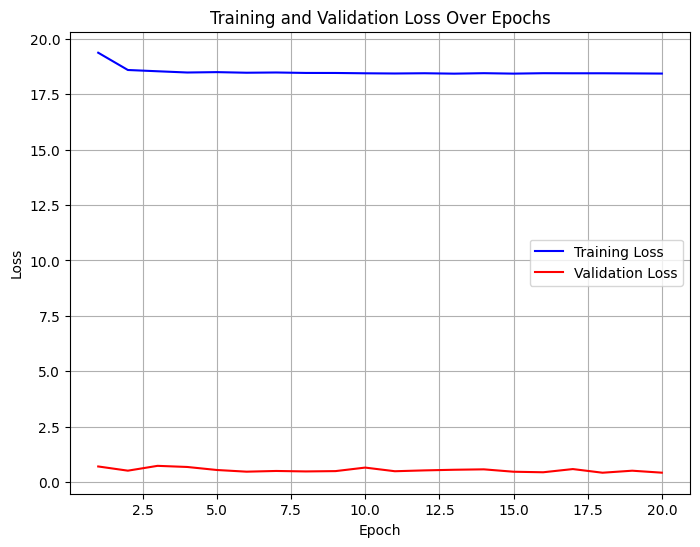

In [26]:
plot_losses(training_losses, validation_losses, label_one="Training", label_two="Validation")

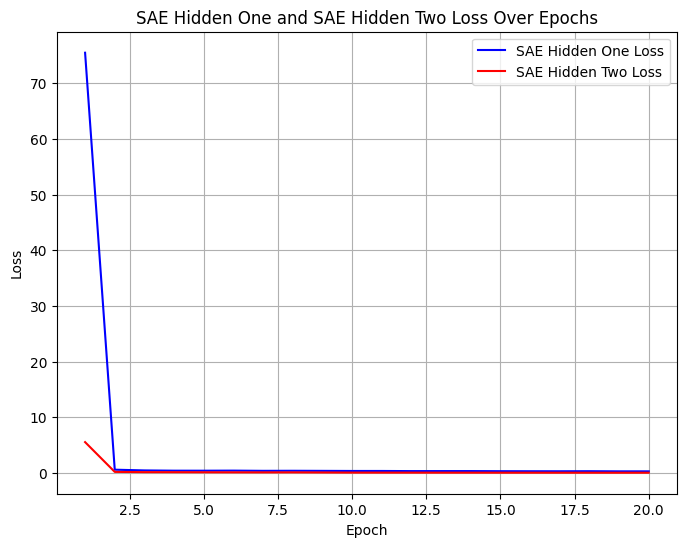

In [27]:
plot_losses(SAE_hidden_one_losses, SAE_hidden_two_losses, 
            label_one="SAE Hidden One", label_two="SAE Hidden Two")

## Eval

Evaluating our classification model accuracy, in addition to the reconstruction and sparisty metrics of each SAE.

In [28]:
best_model.eval()  # again currently a no-op
best_sae_one.eval()
best_sae_two.eval()

test_correct = 0
test_total = 0

feature_activations_one_test = torch.zeros(HIDDEN_SIZE, len(test_images))
feature_activations_two_test = torch.zeros(HIDDEN_SIZE, len(test_images))
labels_test = torch.zeros(len(test_images), dtype=torch.long)

recon_errors_one = []
recon_errors_two = []

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for i, batch in enumerate(test_bar):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, hidden_one_act, hidden_two_act = best_model(images)
        reconstructed_one, encoded_one = best_sae_one(hidden_one_act)
        reconstructed_two, encoded_two = best_sae_two(hidden_two_act)

        # SAE reconstruction
        recon_errors_one.append(torch.mean((hidden_one_act - reconstructed_one) ** 2).item())
        recon_errors_two.append(torch.mean((hidden_two_act - reconstructed_two) ** 2).item())

        start_idx = i * test_loader.batch_size
        end_idx = start_idx + images.size(0)
        feature_activations_one_test[:, start_idx:end_idx] = encoded_one.T.cpu()
        feature_activations_two_test[:, start_idx:end_idx] = encoded_two.T.cpu()
        labels_test[start_idx:end_idx] = labels.cpu()

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

Z_test_one = feature_activations_one_test.T.numpy()
Z_test_two = feature_activations_two_test.T.numpy()
y_test = labels_test.numpy()

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# reconstruction accuracy of SAE at each layer
avg_recon_error_one = np.mean(recon_errors_one)
avg_recon_error_two = np.mean(recon_errors_two)
print(f"Average Reconstruction Error (Hidden One): {avg_recon_error_one:.4f}")
print(f"Average Reconstruction Error (Hidden Two): {avg_recon_error_two:.4f}")

# Compute sparsity (average non-zero features per image)
sparsity_one = torch.mean((feature_activations_one_test > 1e-5).float()).item() * 64
sparsity_two = torch.mean((feature_activations_two_test > 1e-5).float()).item() * 64
print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")

Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 317.61it/s]

Final Test Accuracy: 88.36%
Average Reconstruction Error (Hidden One): 0.1818
Average Reconstruction Error (Hidden Two): 0.0034
Average Non-Zero Features per Image (Hidden One): 40.34
Average Non-Zero Features per Image (Hidden Two): 28.87


## Linear Probe Tests

### Exploring First Layer

In [29]:
from sklearn.linear_model import LogisticRegression

clf_one = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
clf_one.fit(Z_train_one, y_train)
acc_one = clf_one.score(Z_test_one, y_test)
print(f"Linear Probe Accuracy (Hidden One): {acc_one:.2%}")

Linear Probe Accuracy (Hidden One): 85.70%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Exploring Second Layer

In [30]:
clf_two = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
clf_two.fit(Z_train_two, y_train)
acc_two = clf_two.score(Z_test_two, y_test)
print(f"Linear Probe Accuracy (Hidden Two): {acc_two:.2%}")

Linear Probe Accuracy (Hidden Two): 86.48%


/home/alex/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
